In [1]:
import sys
import os

sys.path.append(os.path.abspath("../../"))


In [2]:
import math
import random
from collections import deque, namedtuple
from itertools import count

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.profiler import ProfilerActivity, profile, record_function
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from core.environment.env import Environment
from core.model.decision_network.network import DecisionNetwork


/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
writer = SummaryWriter()


In [4]:
torch.random.manual_seed(42)

In [5]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


In [6]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

else:
    device = torch.device("mps")


In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: mps


In [8]:
env = Environment()

In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [10]:
# class DQN(nn.Module):

#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()
#         self.layer1 = nn.Linear(n_observations, 128)
#         self.layer2 = nn.Linear(128, 128)
#         self.layer3 = nn.Linear(128, n_actions)

#     # Called with either one element to determine next action, or a batch
#     # during optimization. Returns tensor([[left0exp,right0exp]...]).
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         return self.layer3(x)


In [11]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 3e-5

In [12]:
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

In [13]:
# policy_net = DQN(n_observations, n_actions)
# target_net = DQN(n_observations, n_actions)
policy_net = DecisionNetwork().to(device)
target_net = DecisionNetwork().to(device)
target_net.load_state_dict(policy_net.state_dict())


<All keys matched successfully>

In [14]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(512)


In [15]:
steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long, device=device)


In [16]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [17]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(
            non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,
                     expected_state_action_values.unsqueeze(1))

    writer.add_scalar('Loss/train', loss, steps_done)
    writer.add_scalar('Reward/train', reward_batch.float().mean(), steps_done)
    # print(reward_batch)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


63it [00:37,  1.69it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 2447.74267578125, 'current_collection_id': 2}


63it [00:57,  1.10it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 255.81390380859375, 'current_collection_id': 3}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 1057.0693359375, 'current_collection_id': 4}


63it [00:57,  1.09it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 654.530029296875, 'current_collection_id': 5}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 5483.09765625, 'current_collection_id': 6}


63it [00:55,  1.13it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 318.22186279296875, 'current_collection_id': 7}


63it [00:55,  1.13it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 4855.0322265625, 'current_collection_id': 8}


63it [00:56,  1.11it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 8589.6201171875, 'current_collection_id': 9}


63it [00:57,  1.09it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 4531.791015625, 'current_collection_id': 10}


14it [00:14,  1.01s/it]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 13979.4599609375, 'current_collection_id': 11}


15it [00:15,  1.14s/it]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
16it [00:16,  1.11s/it]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
63it [01:01,  1.02it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 18876.23828125, 'current_collection_id': 13}


63it [01:00,  1.04it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 3552.098388671875, 'current_collection_id': 14}


63it [01:00,  1.04it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 2758.31298828125, 'current_collection_id': 15}


63it [00:59,  1.06it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 5615.8173828125, 'current_collection_id': 16}


63it [01:00,  1.05it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 1358.1781005859375, 'current_collection_id': 17}


63it [00:57,  1.10it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 7613.5986328125, 'current_collection_id': 18}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 102112.7421875, 'current_collection_id': 19}


63it [00:57,  1.09it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 2133.263916015625, 'current_collection_id': 20}


63it [00:56,  1.11it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 2264.561279296875, 'current_collection_id': 21}


63it [00:56,  1.11it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 2579.57275390625, 'current_collection_id': 22}


63it [00:56,  1.11it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 1438.1895751953125, 'current_collection_id': 23}


15it [00:13,  1.15it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
16it [00:13,  1.14it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
63it [00:56,  1.11it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 5008.0498046875, 'current_collection_id': 24}


63it [00:57,  1.10it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 5295.25, 'current_collection_id': 25}


63it [00:56,  1.11it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 1342.1785888671875, 'current_collection_id': 26}


63it [00:56,  1.11it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 312.8062438964844, 'current_collection_id': 27}


63it [00:56,  1.11it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 3038.175537109375, 'current_collection_id': 28}


63it [00:56,  1.11it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 1572.5634765625, 'current_collection_id': 29}


63it [00:57,  1.09it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 1111.10498046875, 'current_collection_id': 30}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 5.5848565101623535, 'current_collection_id': 31}


63it [00:57,  1.09it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 2390.990234375, 'current_collection_id': 32}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 8296.6103515625, 'current_collection_id': 33}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 3537.662841796875, 'current_collection_id': 34}


63it [00:58,  1.09it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 104689.9140625, 'current_collection_id': 35}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 3056.15283203125, 'current_collection_id': 36}


24it [00:22,  1.06it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 930.2501831054688, 'current_collection_id': 37}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 2737.155517578125, 'current_collection_id': 39}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 1348.302734375, 'current_collection_id': 40}


15it [00:13,  1.09it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
16it [00:14,  1.05it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 61915.0, 'current_collection_id': 41}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 20325.810546875, 'current_collection_id': 42}


63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 34818.61328125, 'current_collection_id': 43}


63it [00:57,  1.09it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 728.08349609375, 'current_collection_id': 44}


63it [00:59,  1.06it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 7557.5625, 'current_collection_id': 45}


15it [00:13,  1.16it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
16it [00:14,  1.10it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
63it [00:58,  1.08it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 70551.28125, 'current_collection_id': 46}


63it [00:58,  1.07it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 2089.567138671875, 'current_collection_id': 47}


63it [00:59,  1.07it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 9688.57421875, 'current_collection_id': 48}


63it [00:58,  1.07it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 1582.7760009765625, 'current_collection_id': 49}


63it [00:59,  1.07it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 3068.737060546875, 'current_collection_id': 50}


63it [00:58,  1.07it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 8952.73046875, 'current_collection_id': 51}


63it [00:59,  1.06it/s]


reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 3003.36181640625, 'current_collection_id': 52}


63it [00:57,  1.09it/s]

reset {'usd_wallet': 1024000, 'nft_wallet': 0, 'current_price_usd': 6067.10009765625, 'current_collection_id': 53}
Complete


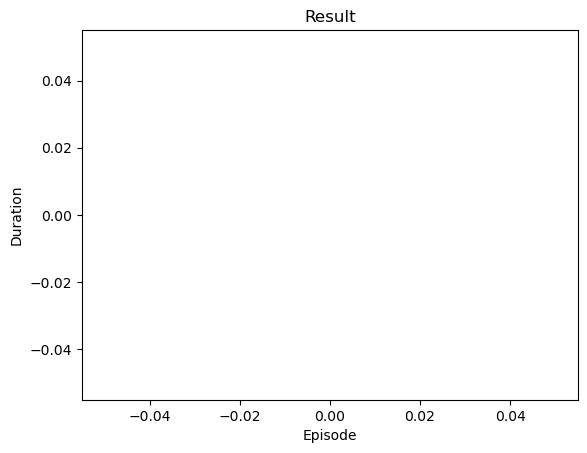

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    state, info = env.reset()
    # Initialize the environment and get it's state
    state = torch.tensor(state, dtype=torch.float32,
                         device=device).unsqueeze(0)
    for t in tqdm(count()):
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * \
                TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # episode_durations.append(t + 1)
            # plot_durations()
            # state, info = env.reset()
            # memory = ReplayMemory(64)
            print('reset', info)
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


## Evaluate Model

In [26]:
# save models
torch.save(policy_net.state_dict(), 'policy_net.pth')
torch.save(target_net.state_dict(), 'target_net.pth')

In [93]:
env = Environment(train=False)
np.random.seed(42)
torch.random.manual_seed(42)
def run_eval(collection_num):
    observation, info = env.reset()

    actions = []
    rewards = []
    infos = []

    for t in tqdm(range(1000)):
        state = torch.tensor(observation, dtype=torch.float32,
                             device=device).unsqueeze(0)
        with torch.no_grad():
            action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(
            action.item())
        actions.append(action)
        rewards.append(reward)
        infos.append(info)
        if terminated:
            break

    infos_df = pd.DataFrame(infos)
    infos_df.head()

    # plot the prices and rewards in the same figure, using different y-axis
    fig, ax1 = plt.subplots(figsize=(6, 4))

    fig.set_dpi(400)

    color = 'tab:red'
    ax1.set_xlabel('time (days)')
    ax1.set_ylabel('price', color=color)
    ax1.plot([i['current_price_usd'] for i in infos], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    # we already handled the x-label with ax1
    ax2.set_ylabel('reward', color=color)
    ax2.plot(rewards, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # annotate the buy and sell points from the actions. 0 is buy, 1 is sell, 2 is hold. Annotate the signal with the price, use green point for buy and yellow point for sell
    for i in range(len(actions)):
        if actions[i] == 0:
            ax1.scatter(i, infos[i]['current_price_usd'], color='green')
            # annotate the price, 3 digits after decimal point
            ax1.annotate('{:.0f}'.format(infos[i]['current_price_usd']), (i, infos[i]['current_price_usd']),
                         textcoords="offset points",  # how to position the text
                         xytext=(0, 10),  # distance from text to points (x,y)
                         ha='center')
        elif actions[i] == 1:
            ax1.scatter(i, infos[i]['current_price_usd'], color='black')
            ax1.annotate('{:.0f}'.format(infos[i]['current_price_usd']), (i, infos[i]['current_price_usd']),
                         textcoords="offset points",  # how to position the text
                         xytext=(0, 10),  # distance from text to points (x,y)
                         ha='center')

    # legend for buy and sell points
    ax1.scatter([], [], color='green', label='buy')
    ax1.scatter([], [], color='black', label='sell')
    ax1.legend(loc='upper left')

    plt.title(
        f'Buy and sell signals from RL agent on collection number {collection_num}')

    plt.show()


  6%|▋         | 63/1000 [00:06<01:32, 10.08it/s]


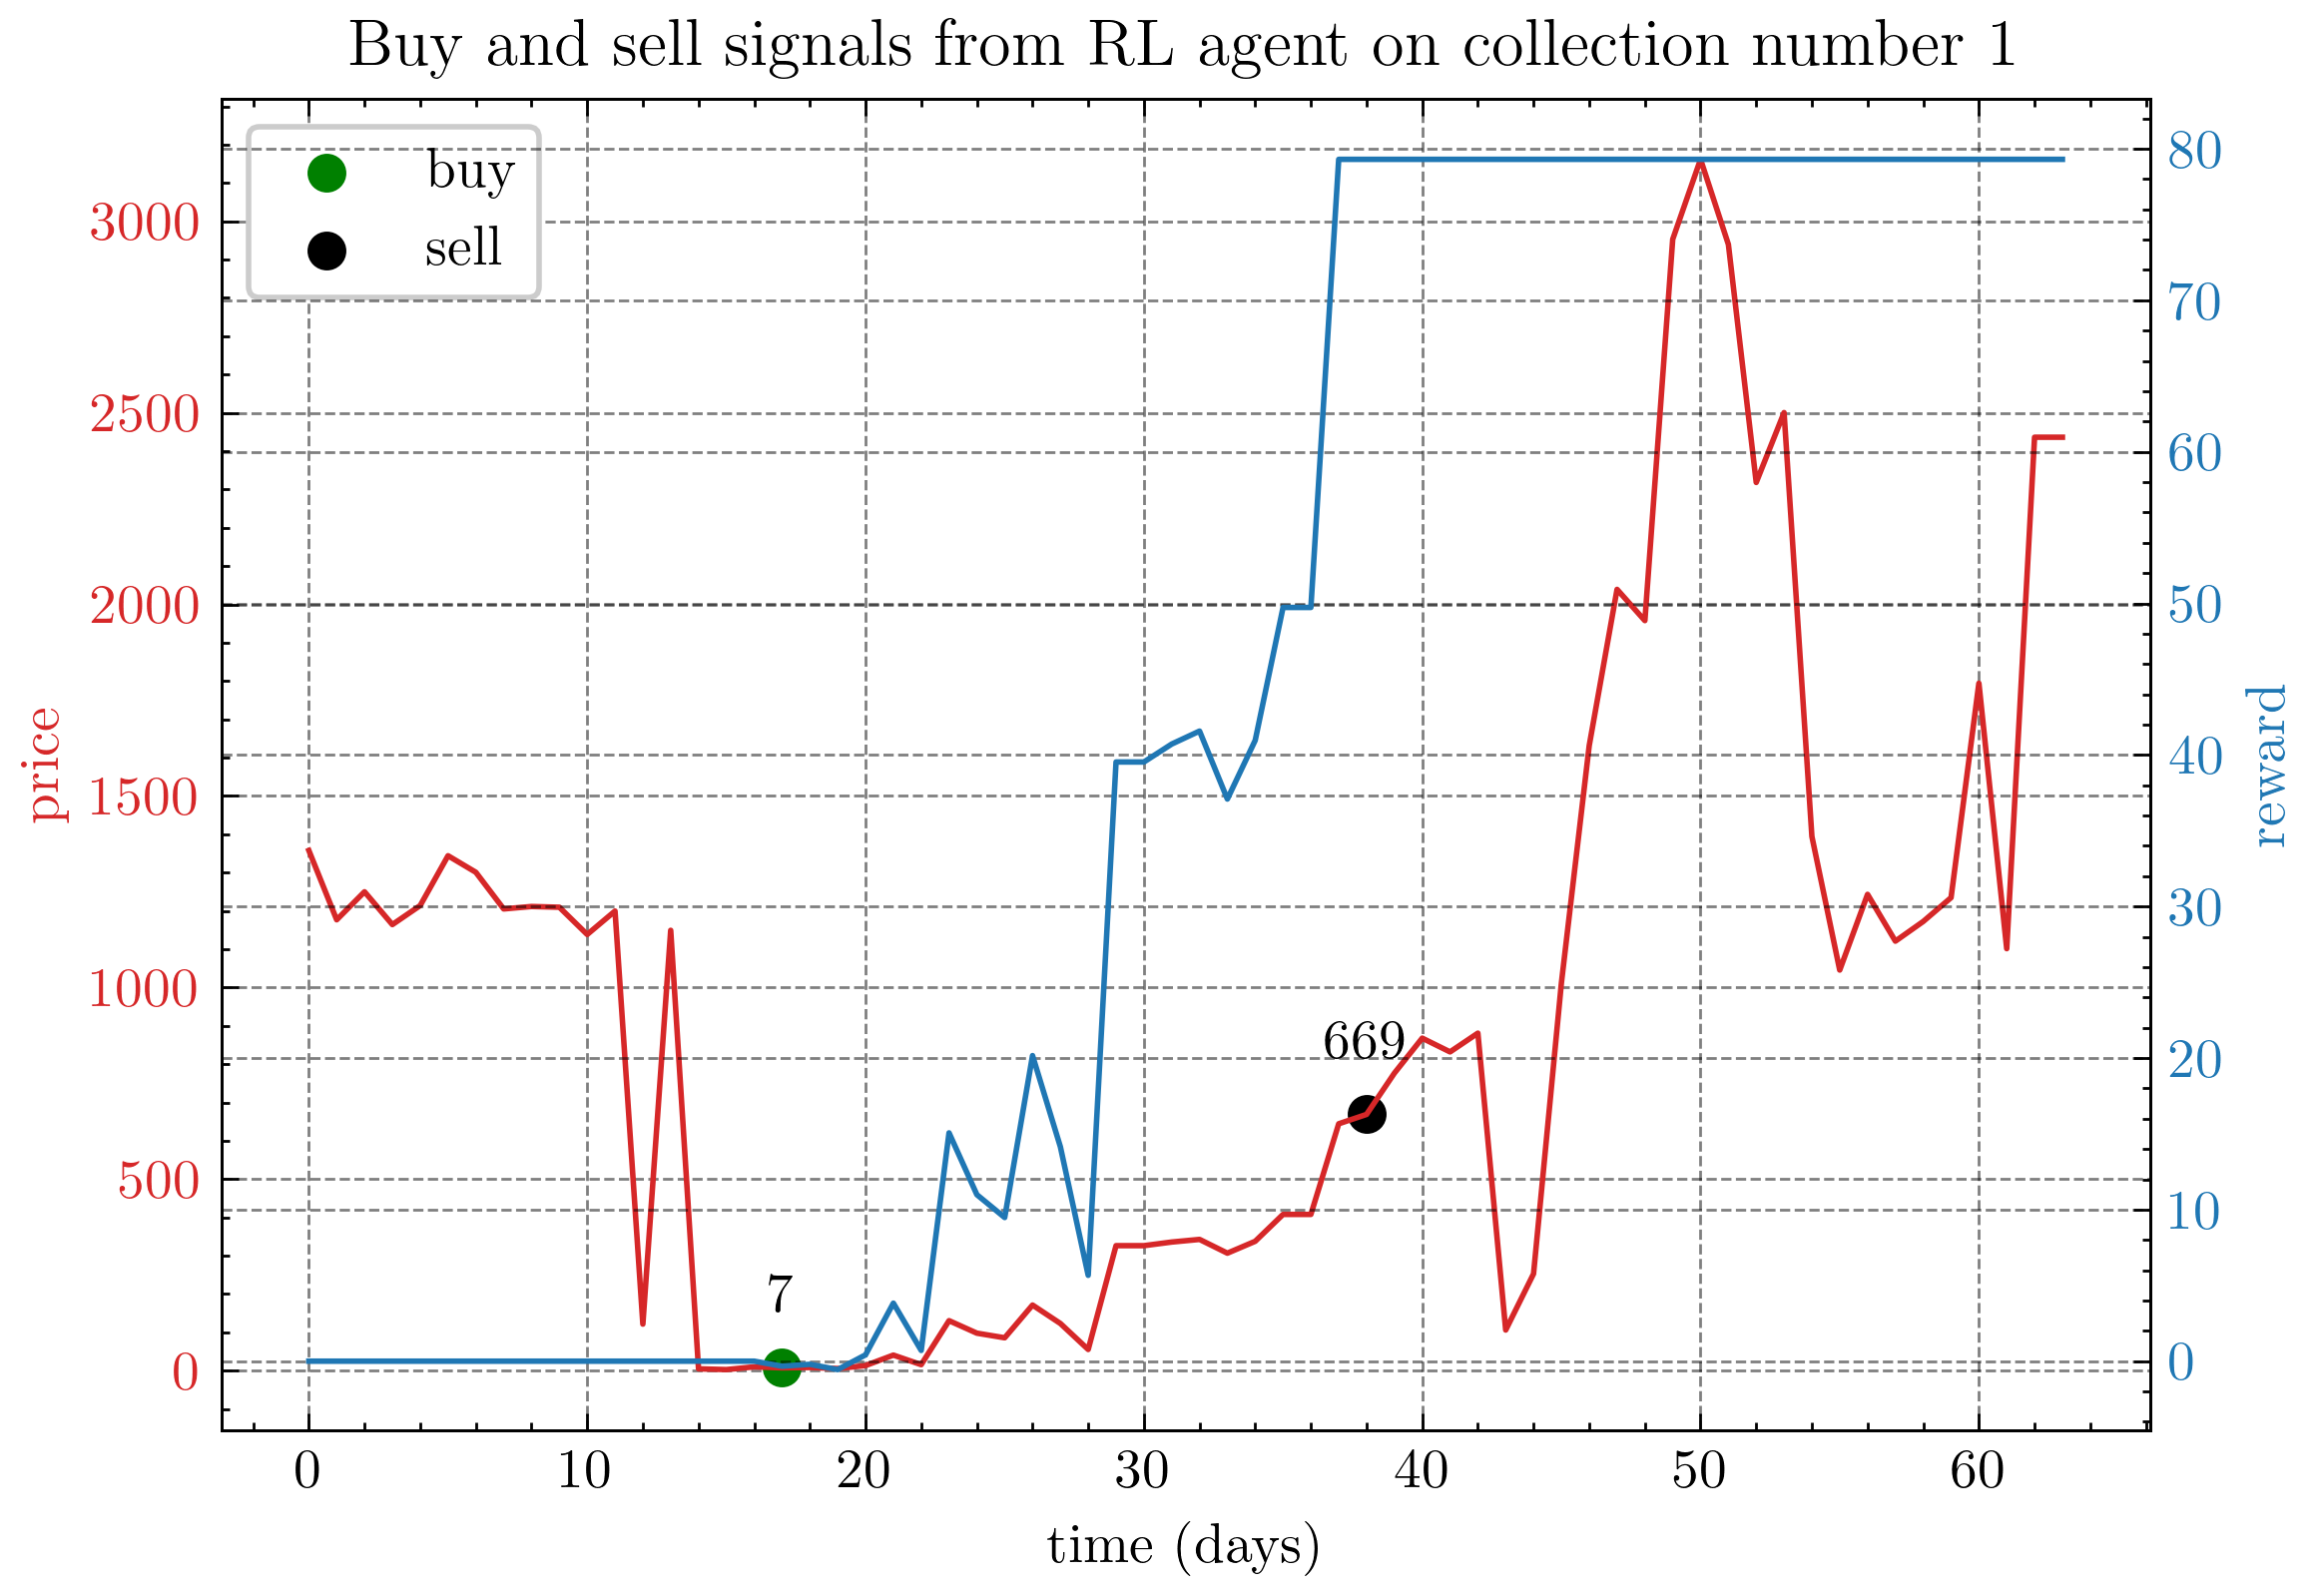

In [100]:
run_eval(1)

  6%|▋         | 63/1000 [00:06<01:34,  9.92it/s]


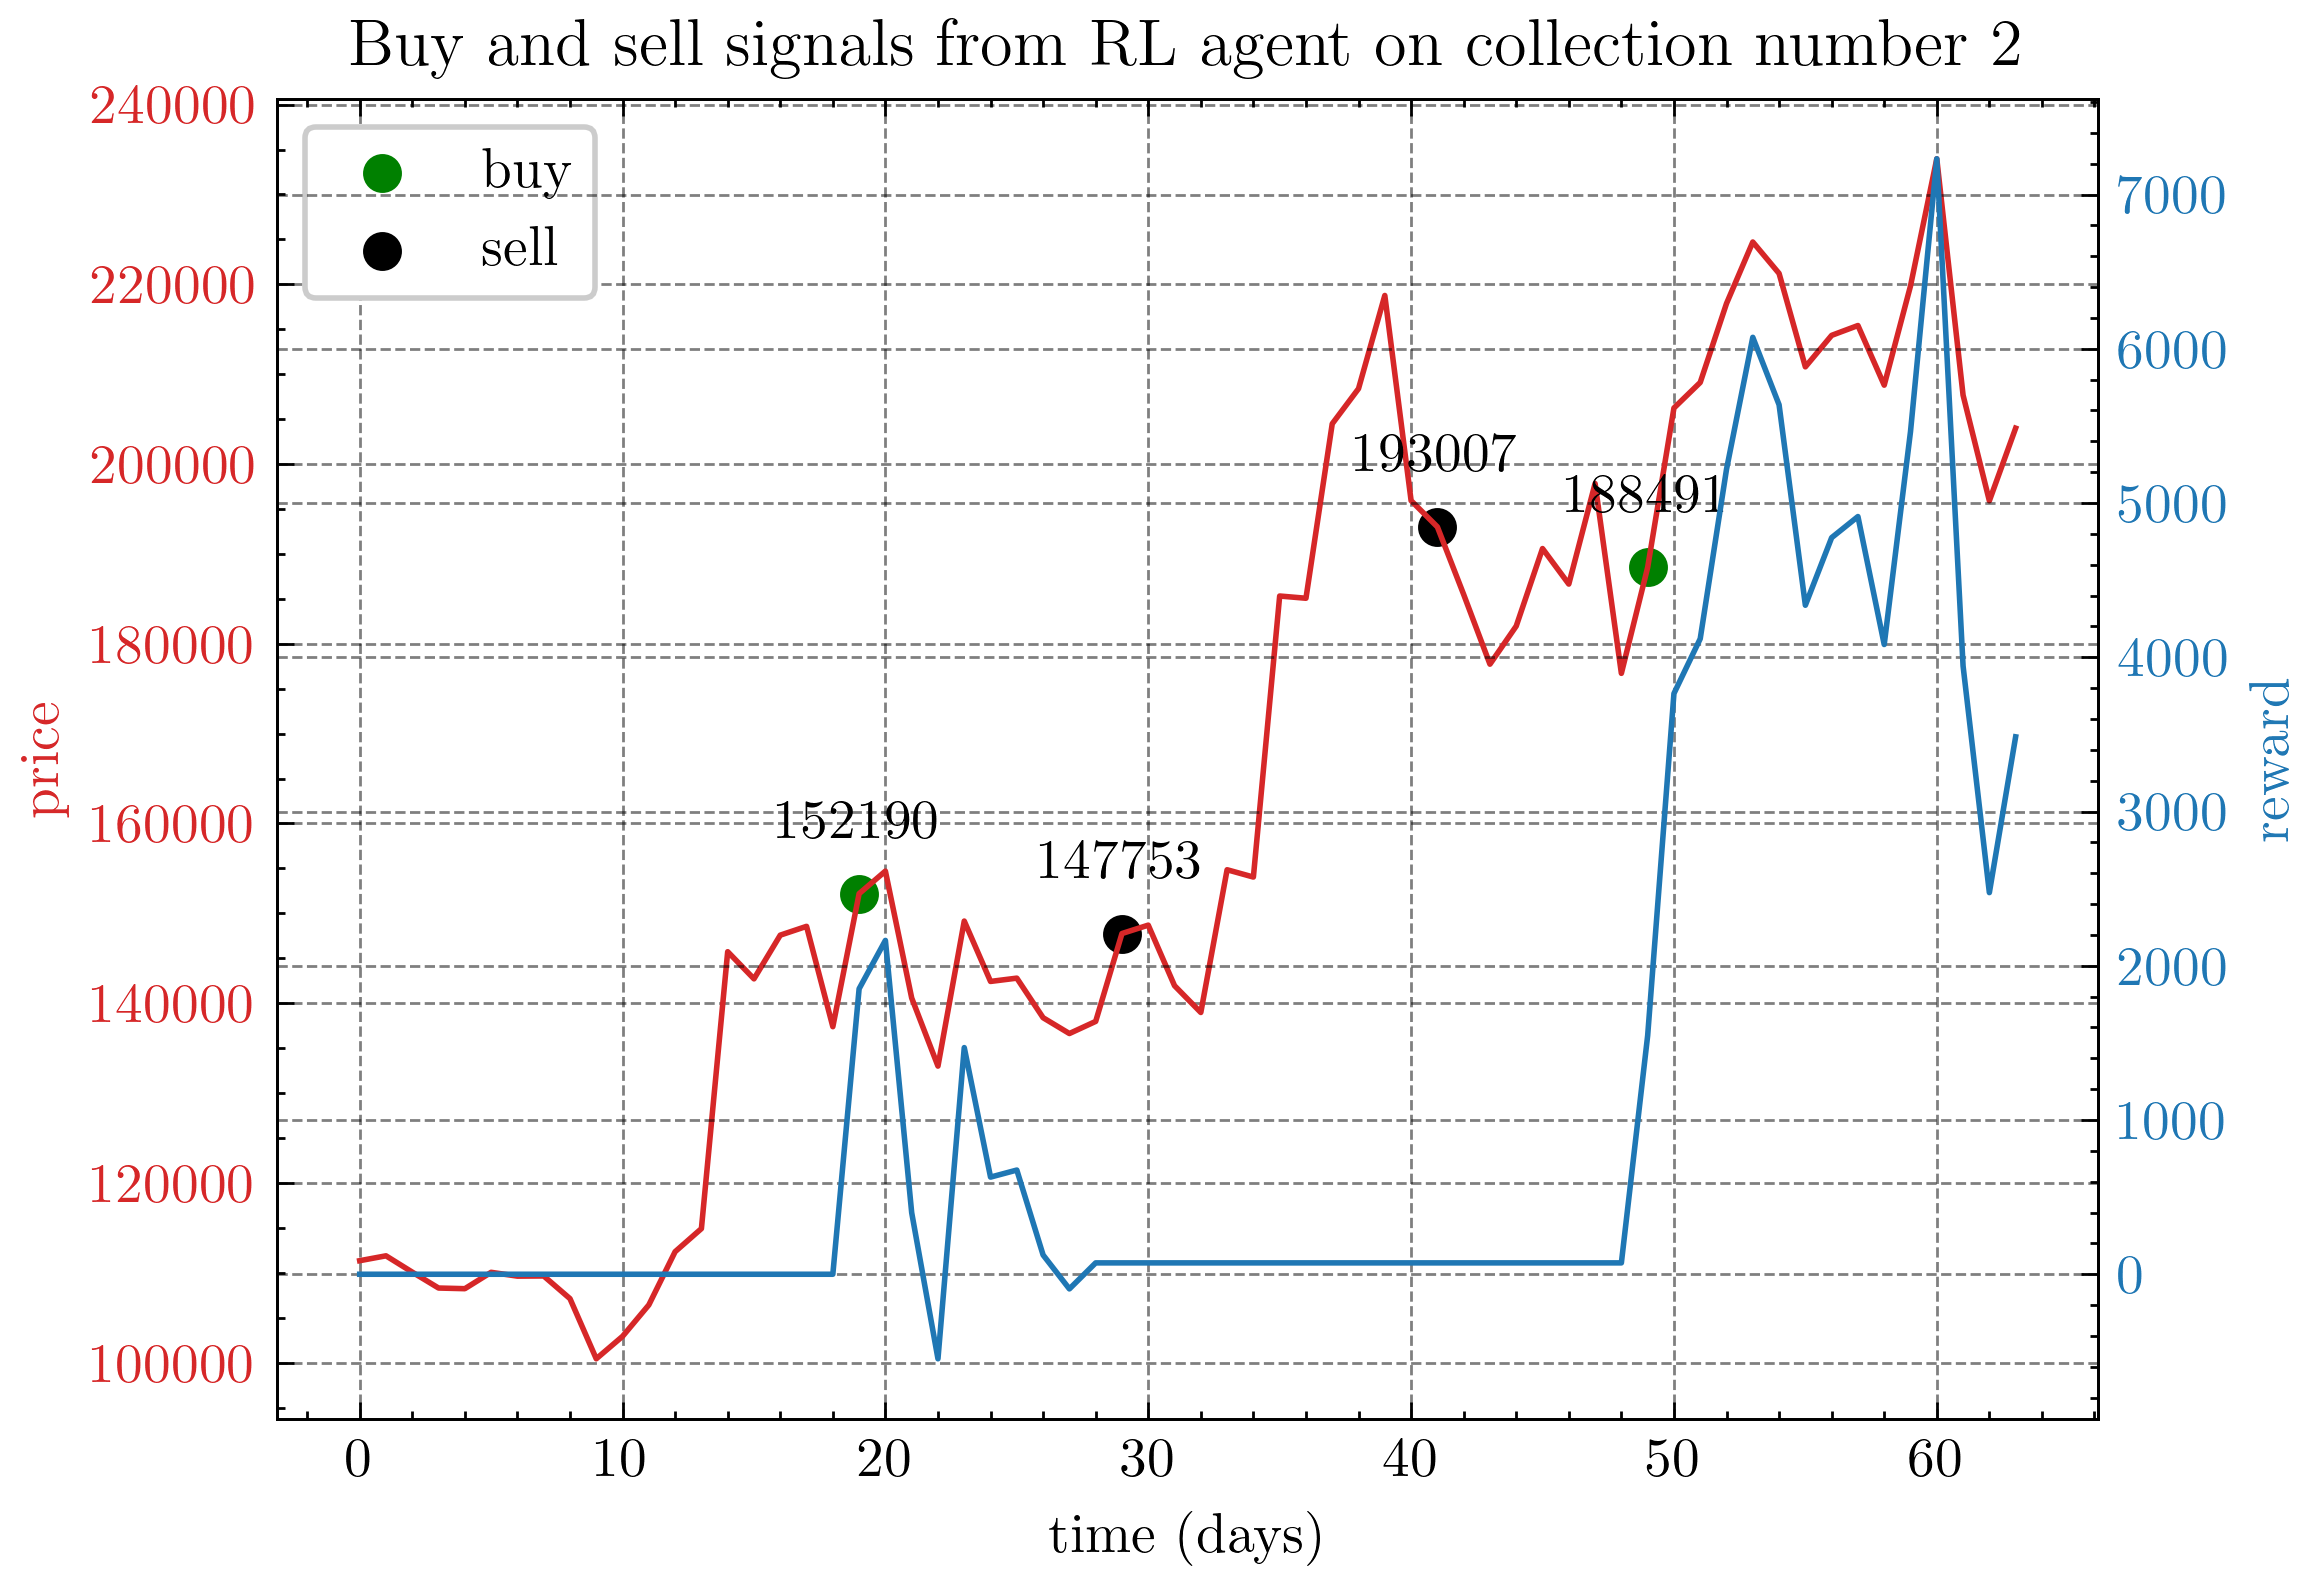

In [105]:
run_eval(2)

  6%|▋         | 63/1000 [00:06<01:38,  9.53it/s]


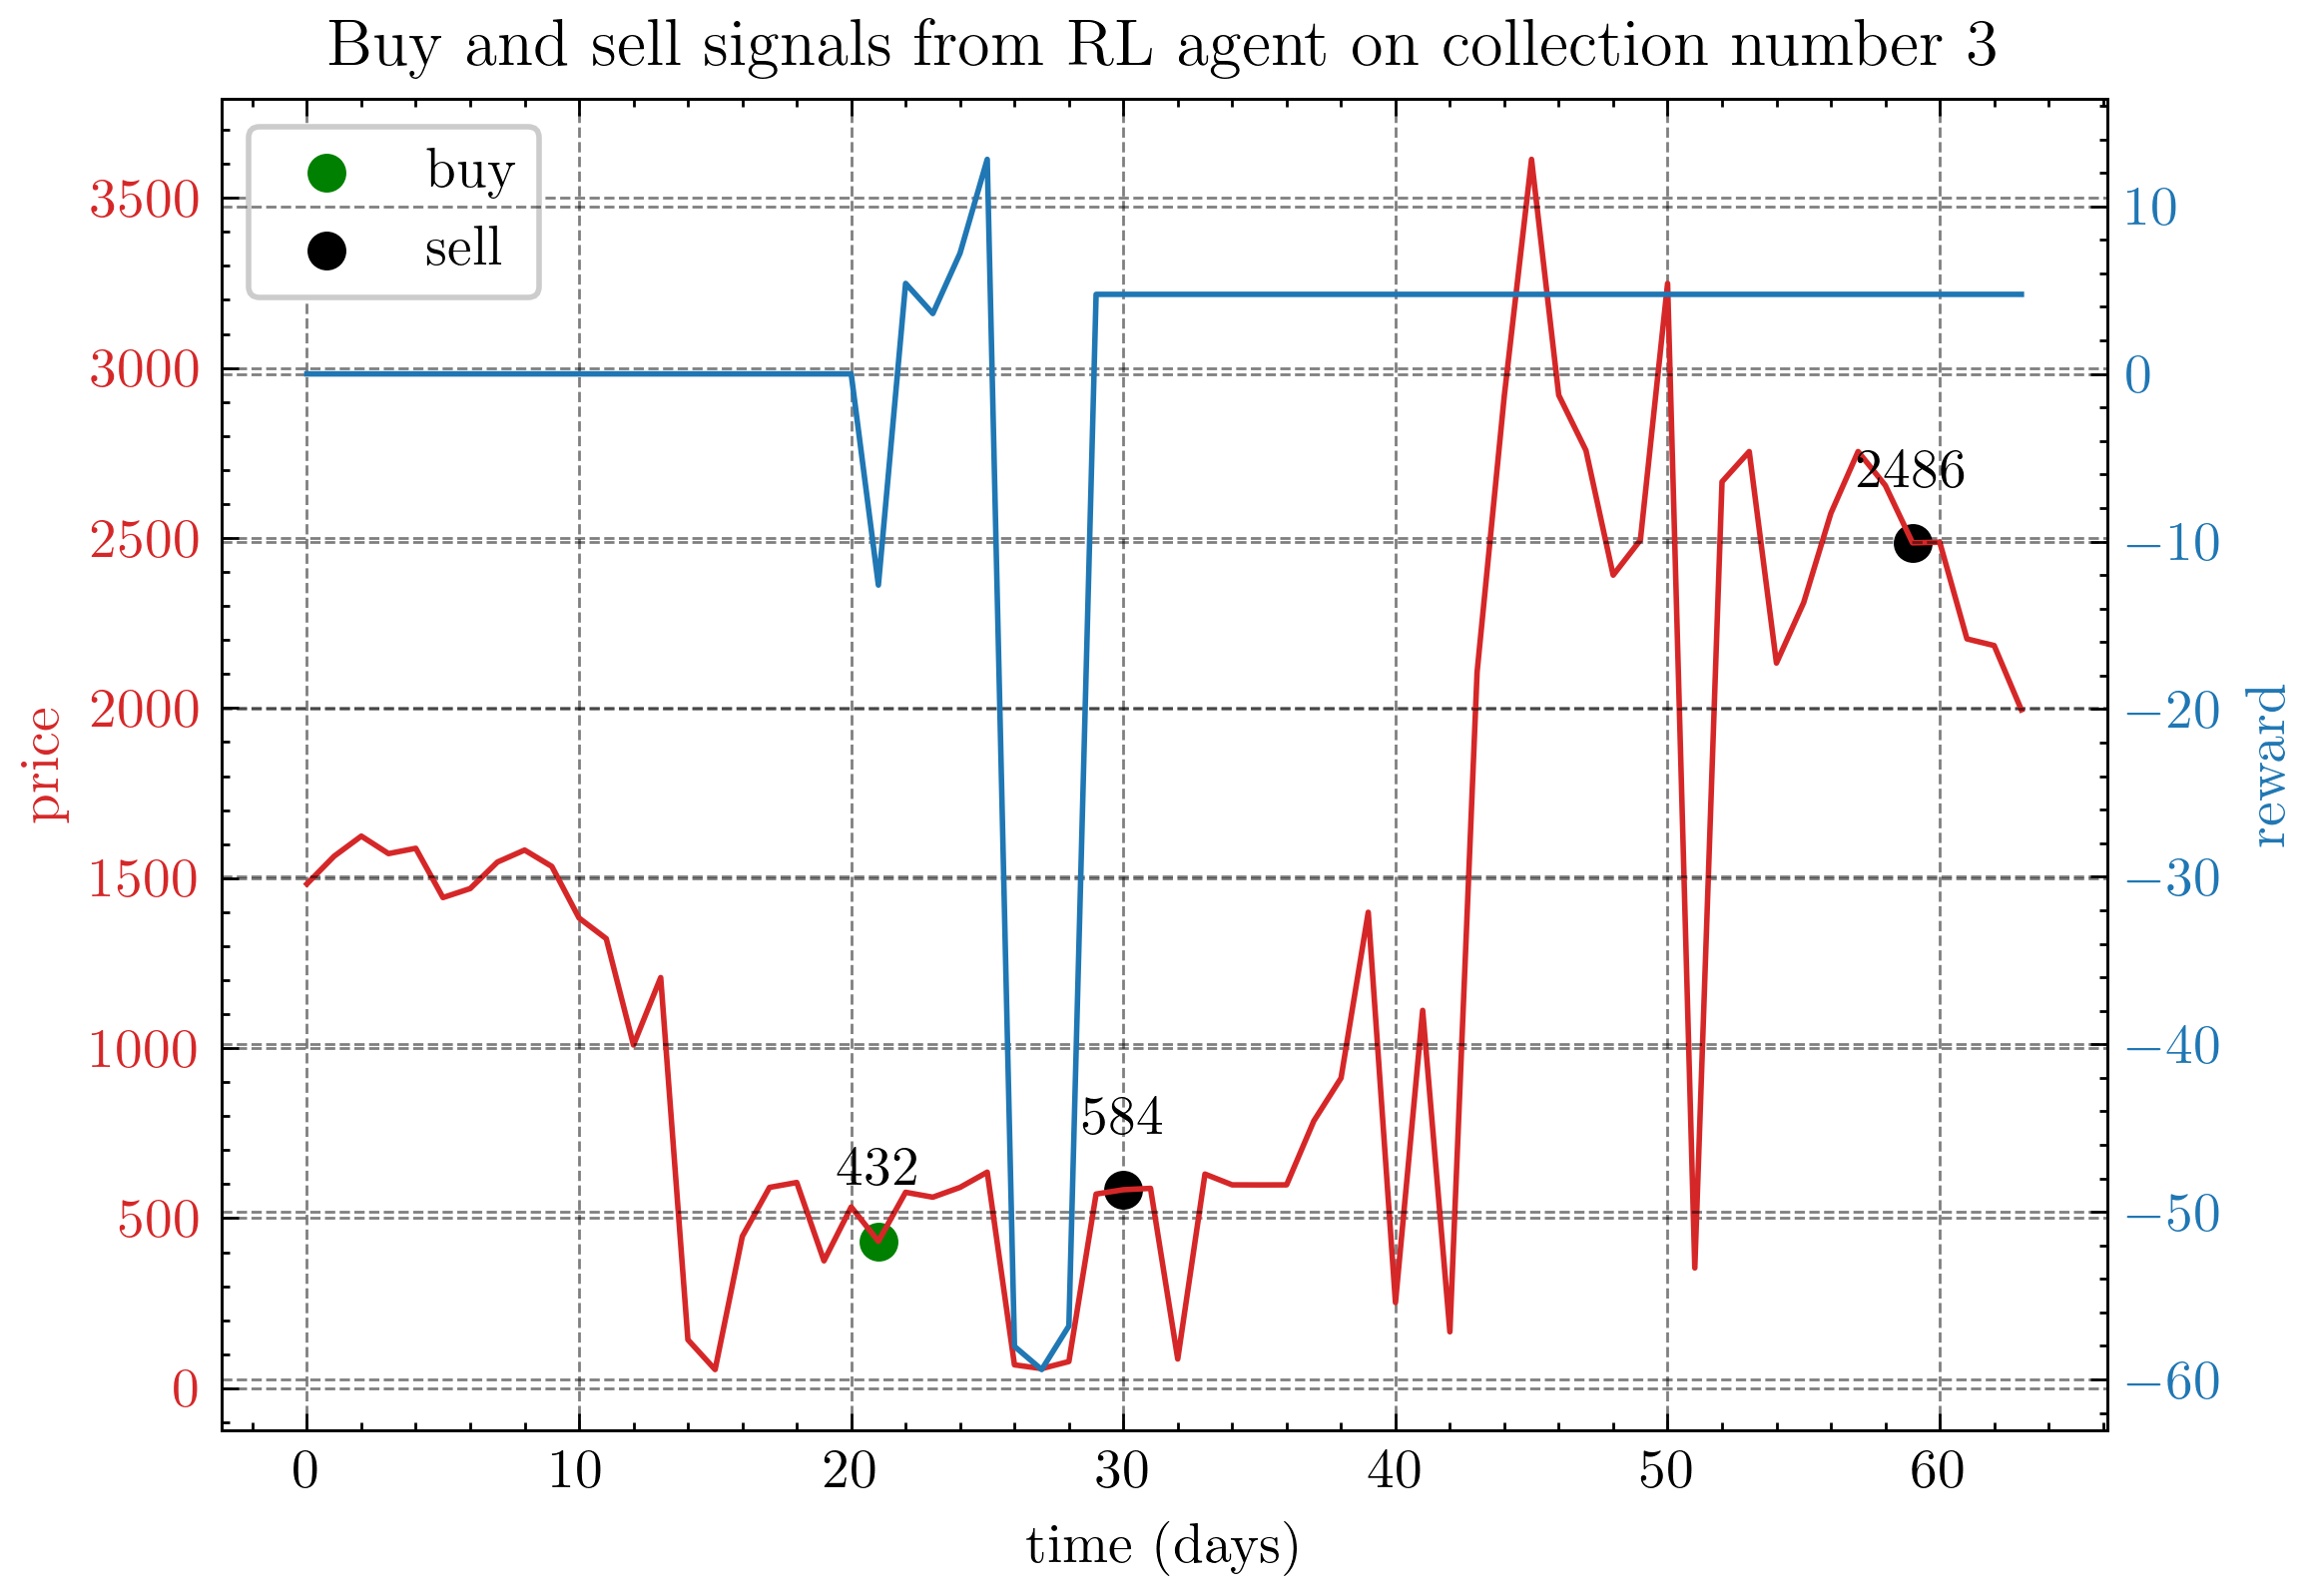

In [115]:
run_eval(3)

  6%|▋         | 63/1000 [00:06<01:35,  9.86it/s]


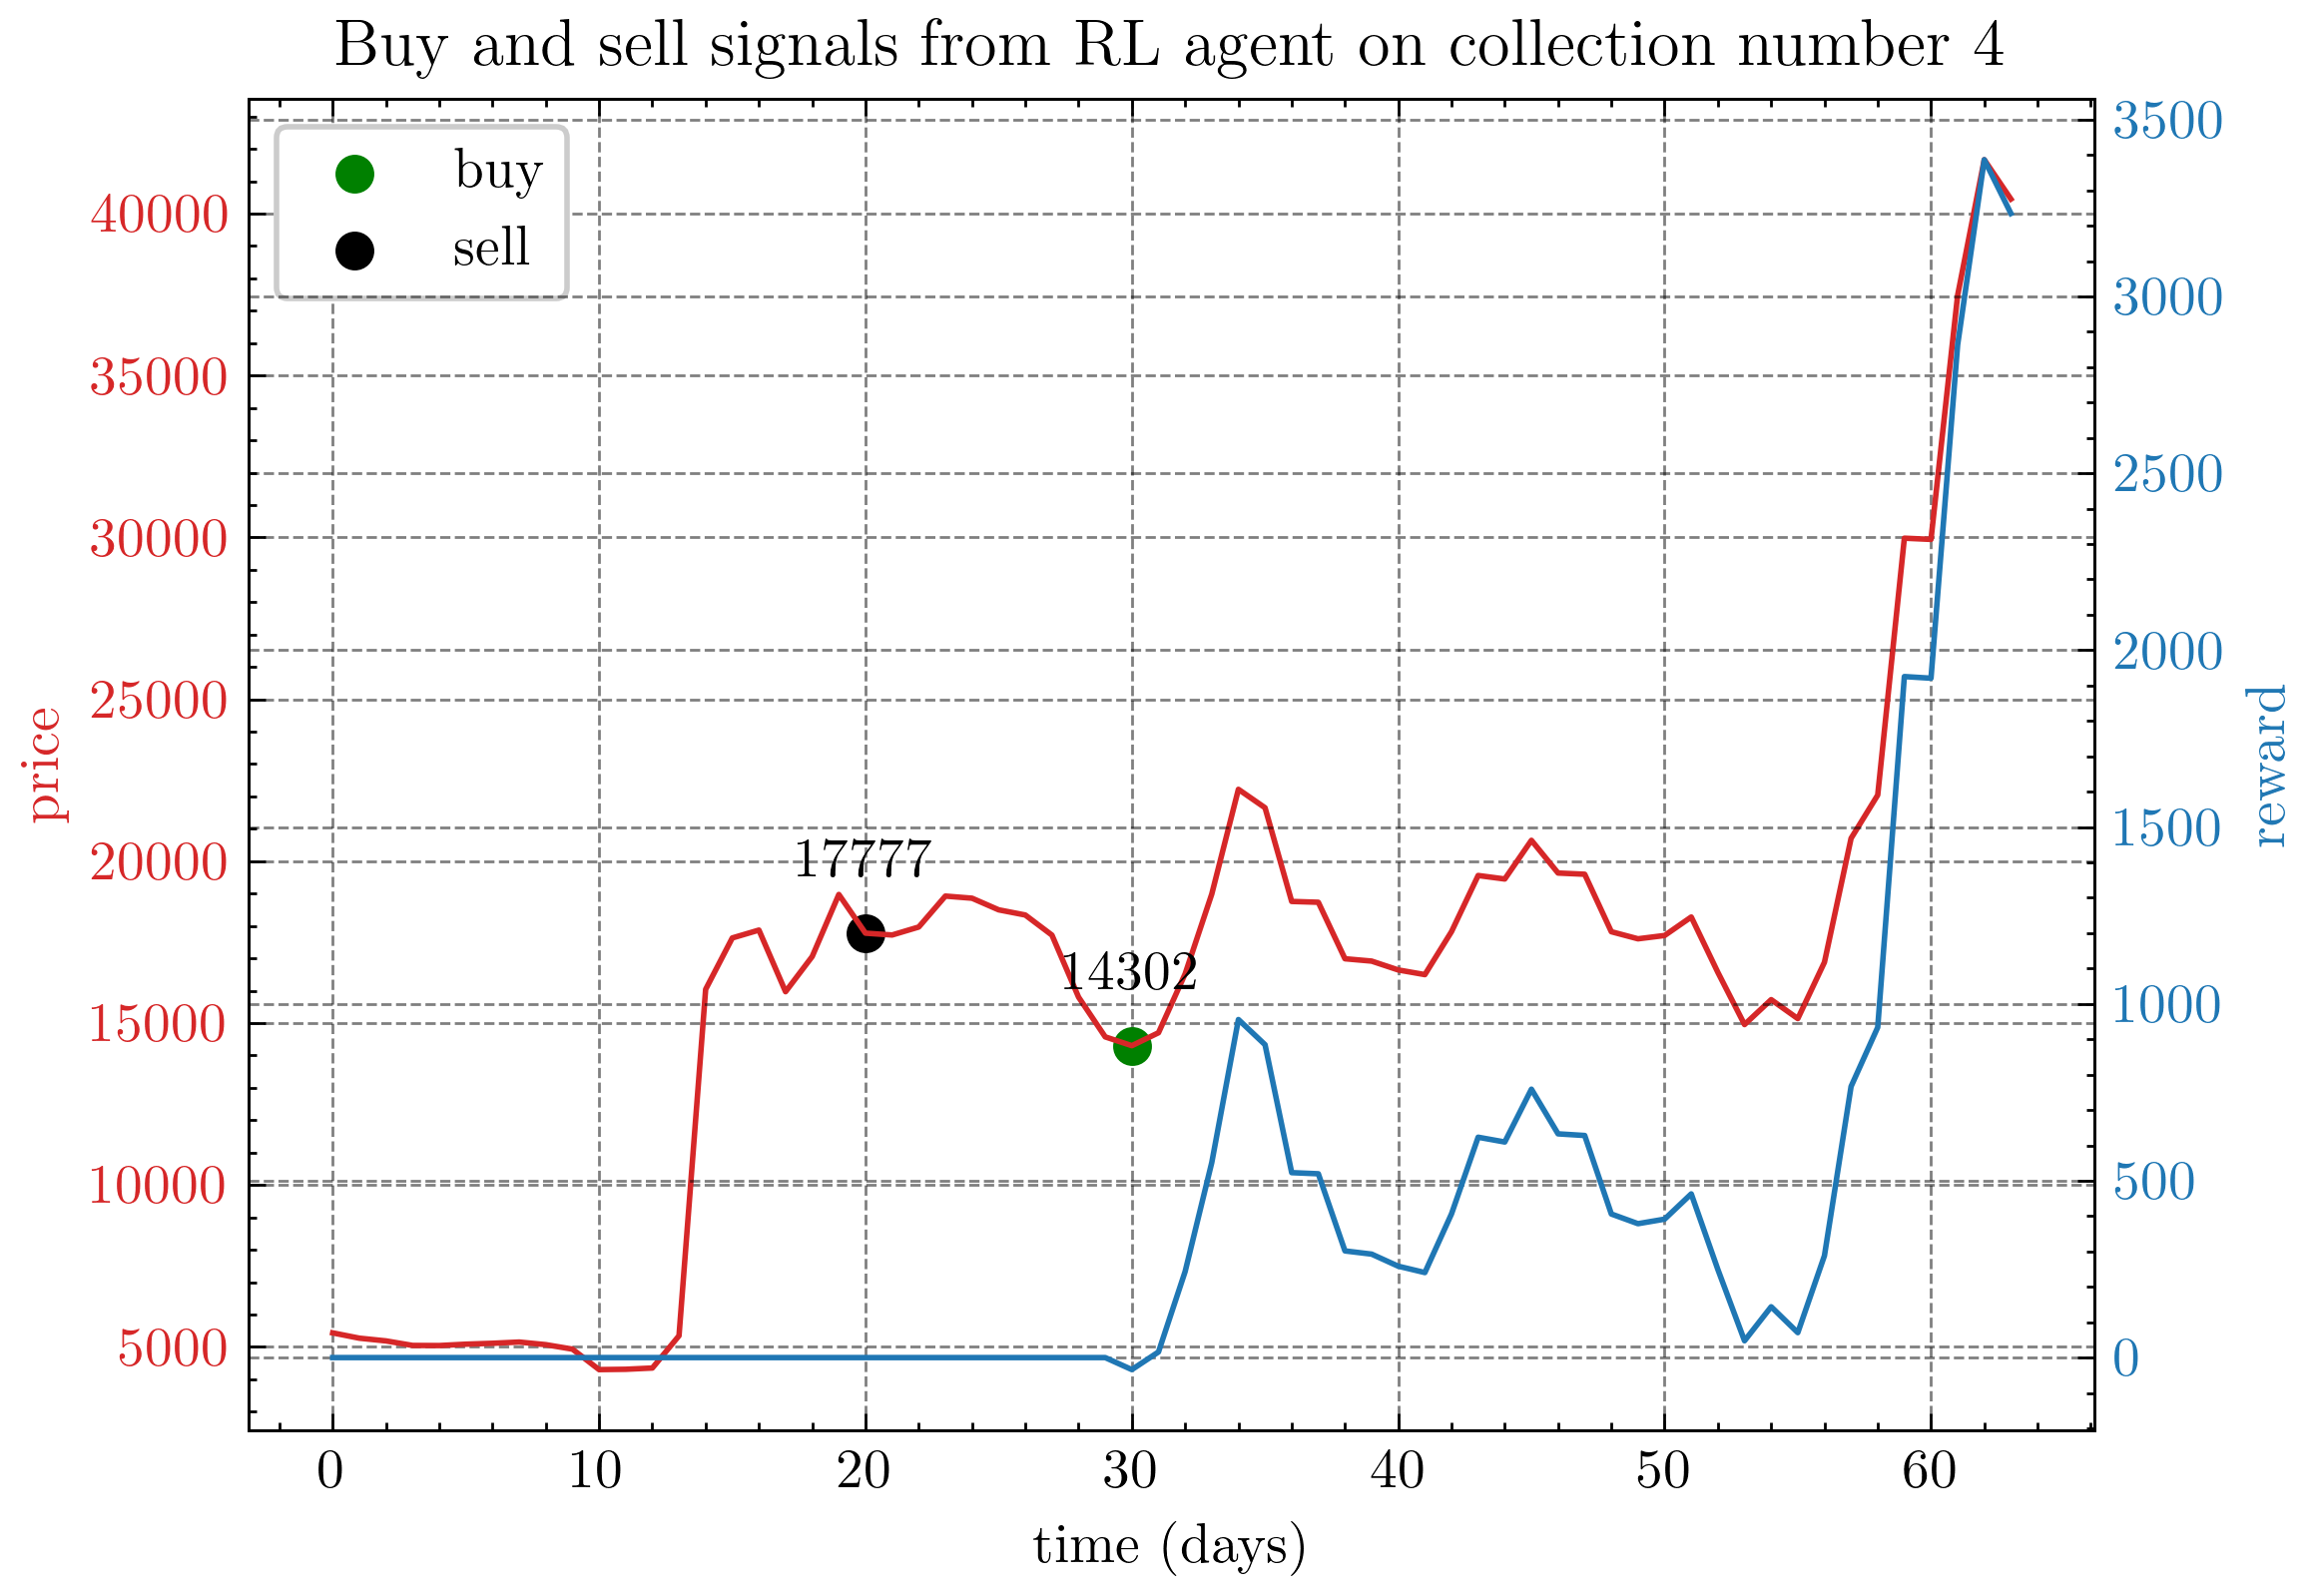

In [123]:
run_eval(4)

  6%|▋         | 63/1000 [00:06<01:39,  9.40it/s]


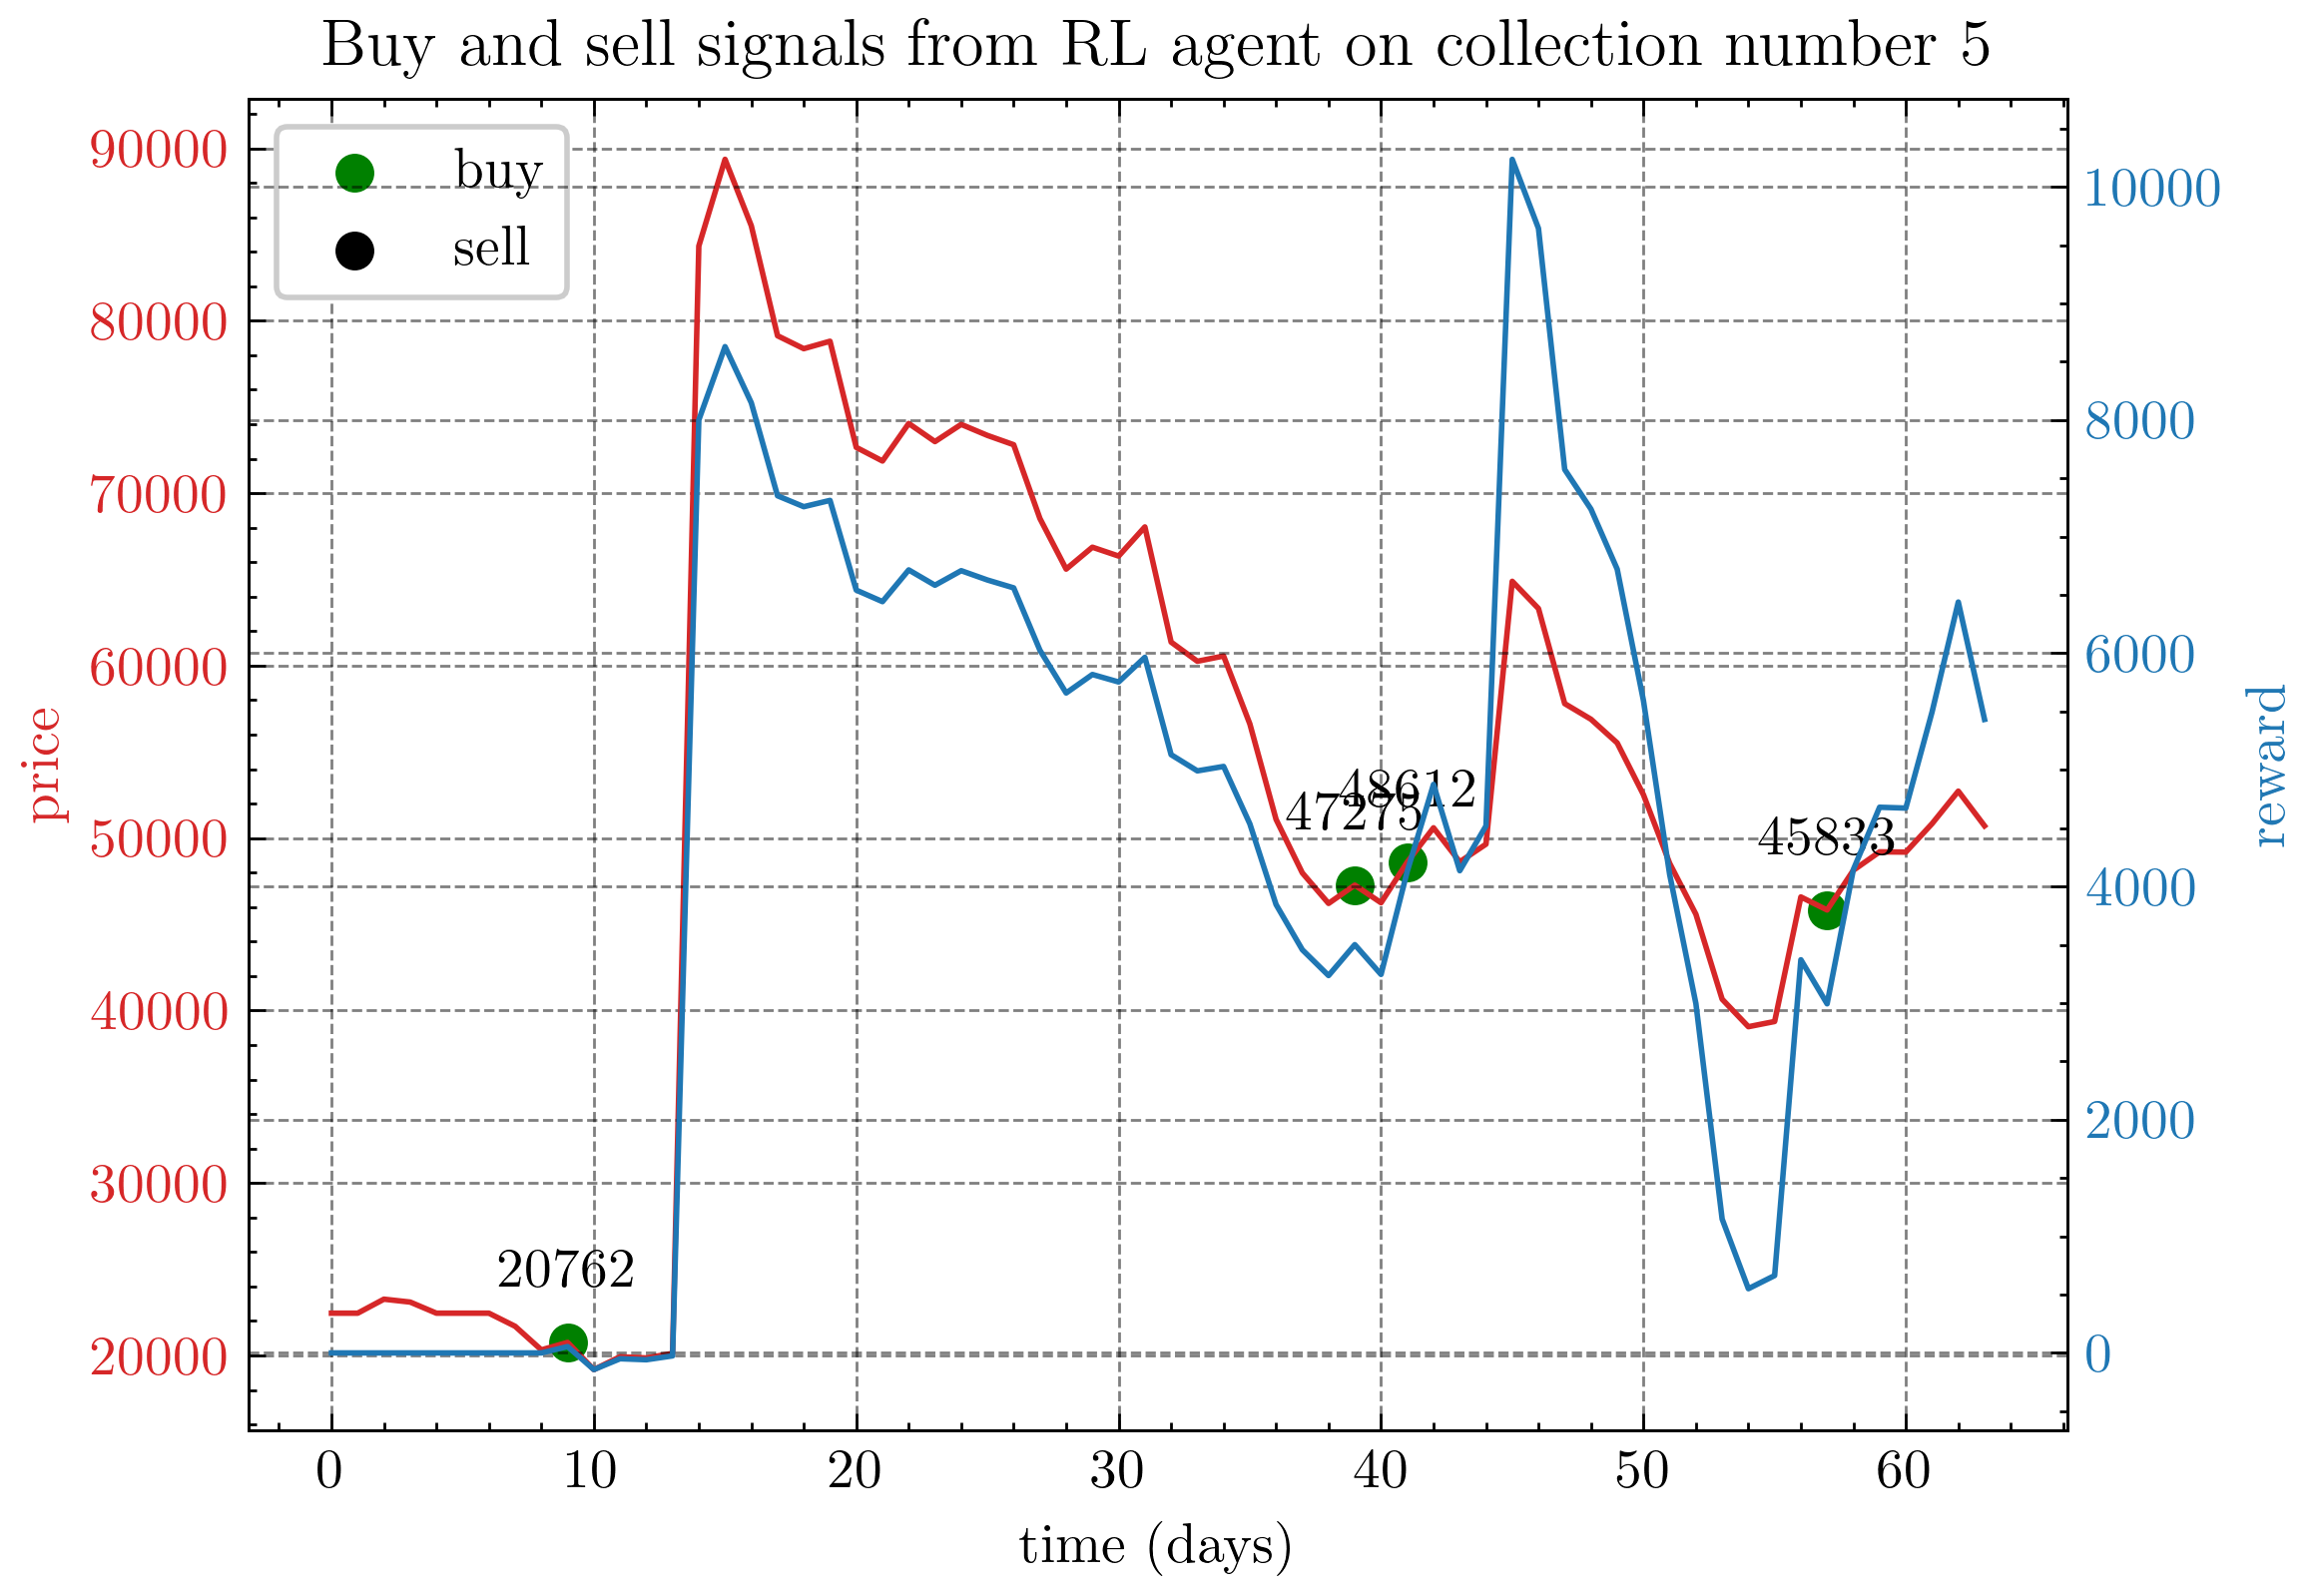

In [124]:
run_eval(5)

  6%|▋         | 63/1000 [00:07<01:44,  8.96it/s]


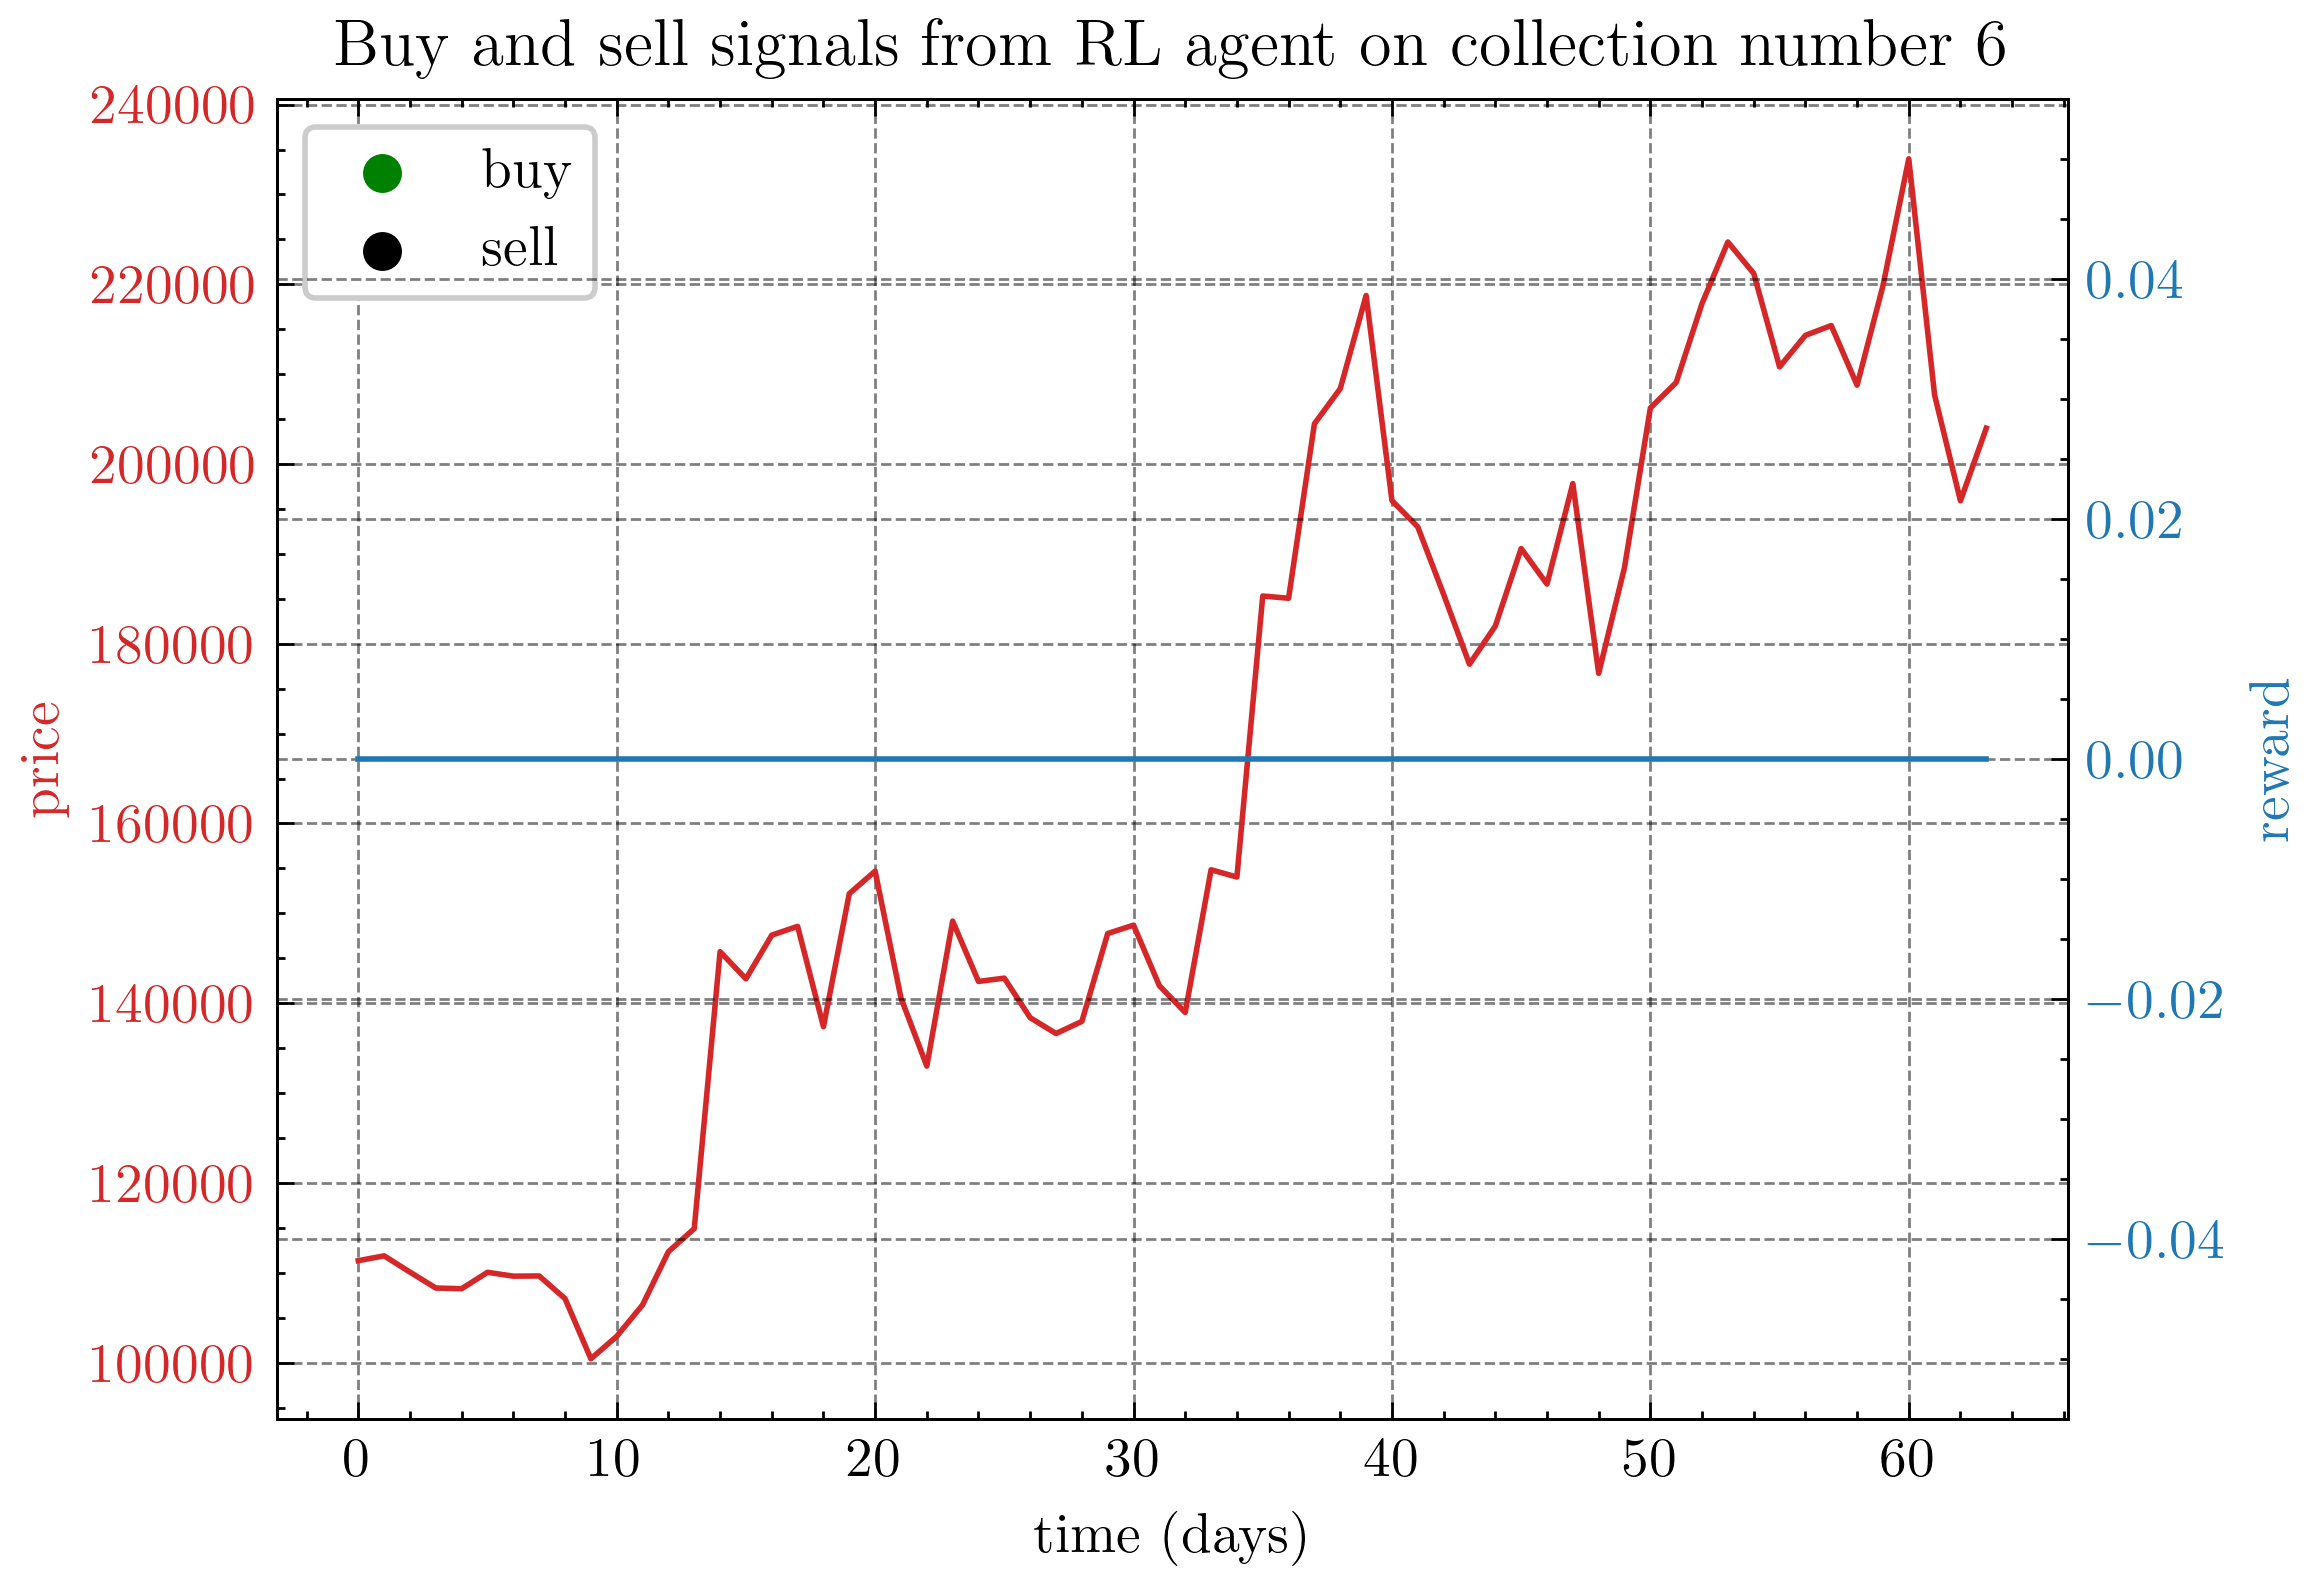

In [125]:
run_eval(6)

  1%|▏         | 14/1000 [00:01<01:39,  9.90it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  2%|▏         | 16/1000 [00:01<01:51,  8.83it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  6%|▋         | 63/1000 [00:06<01:31, 10.29it/s]


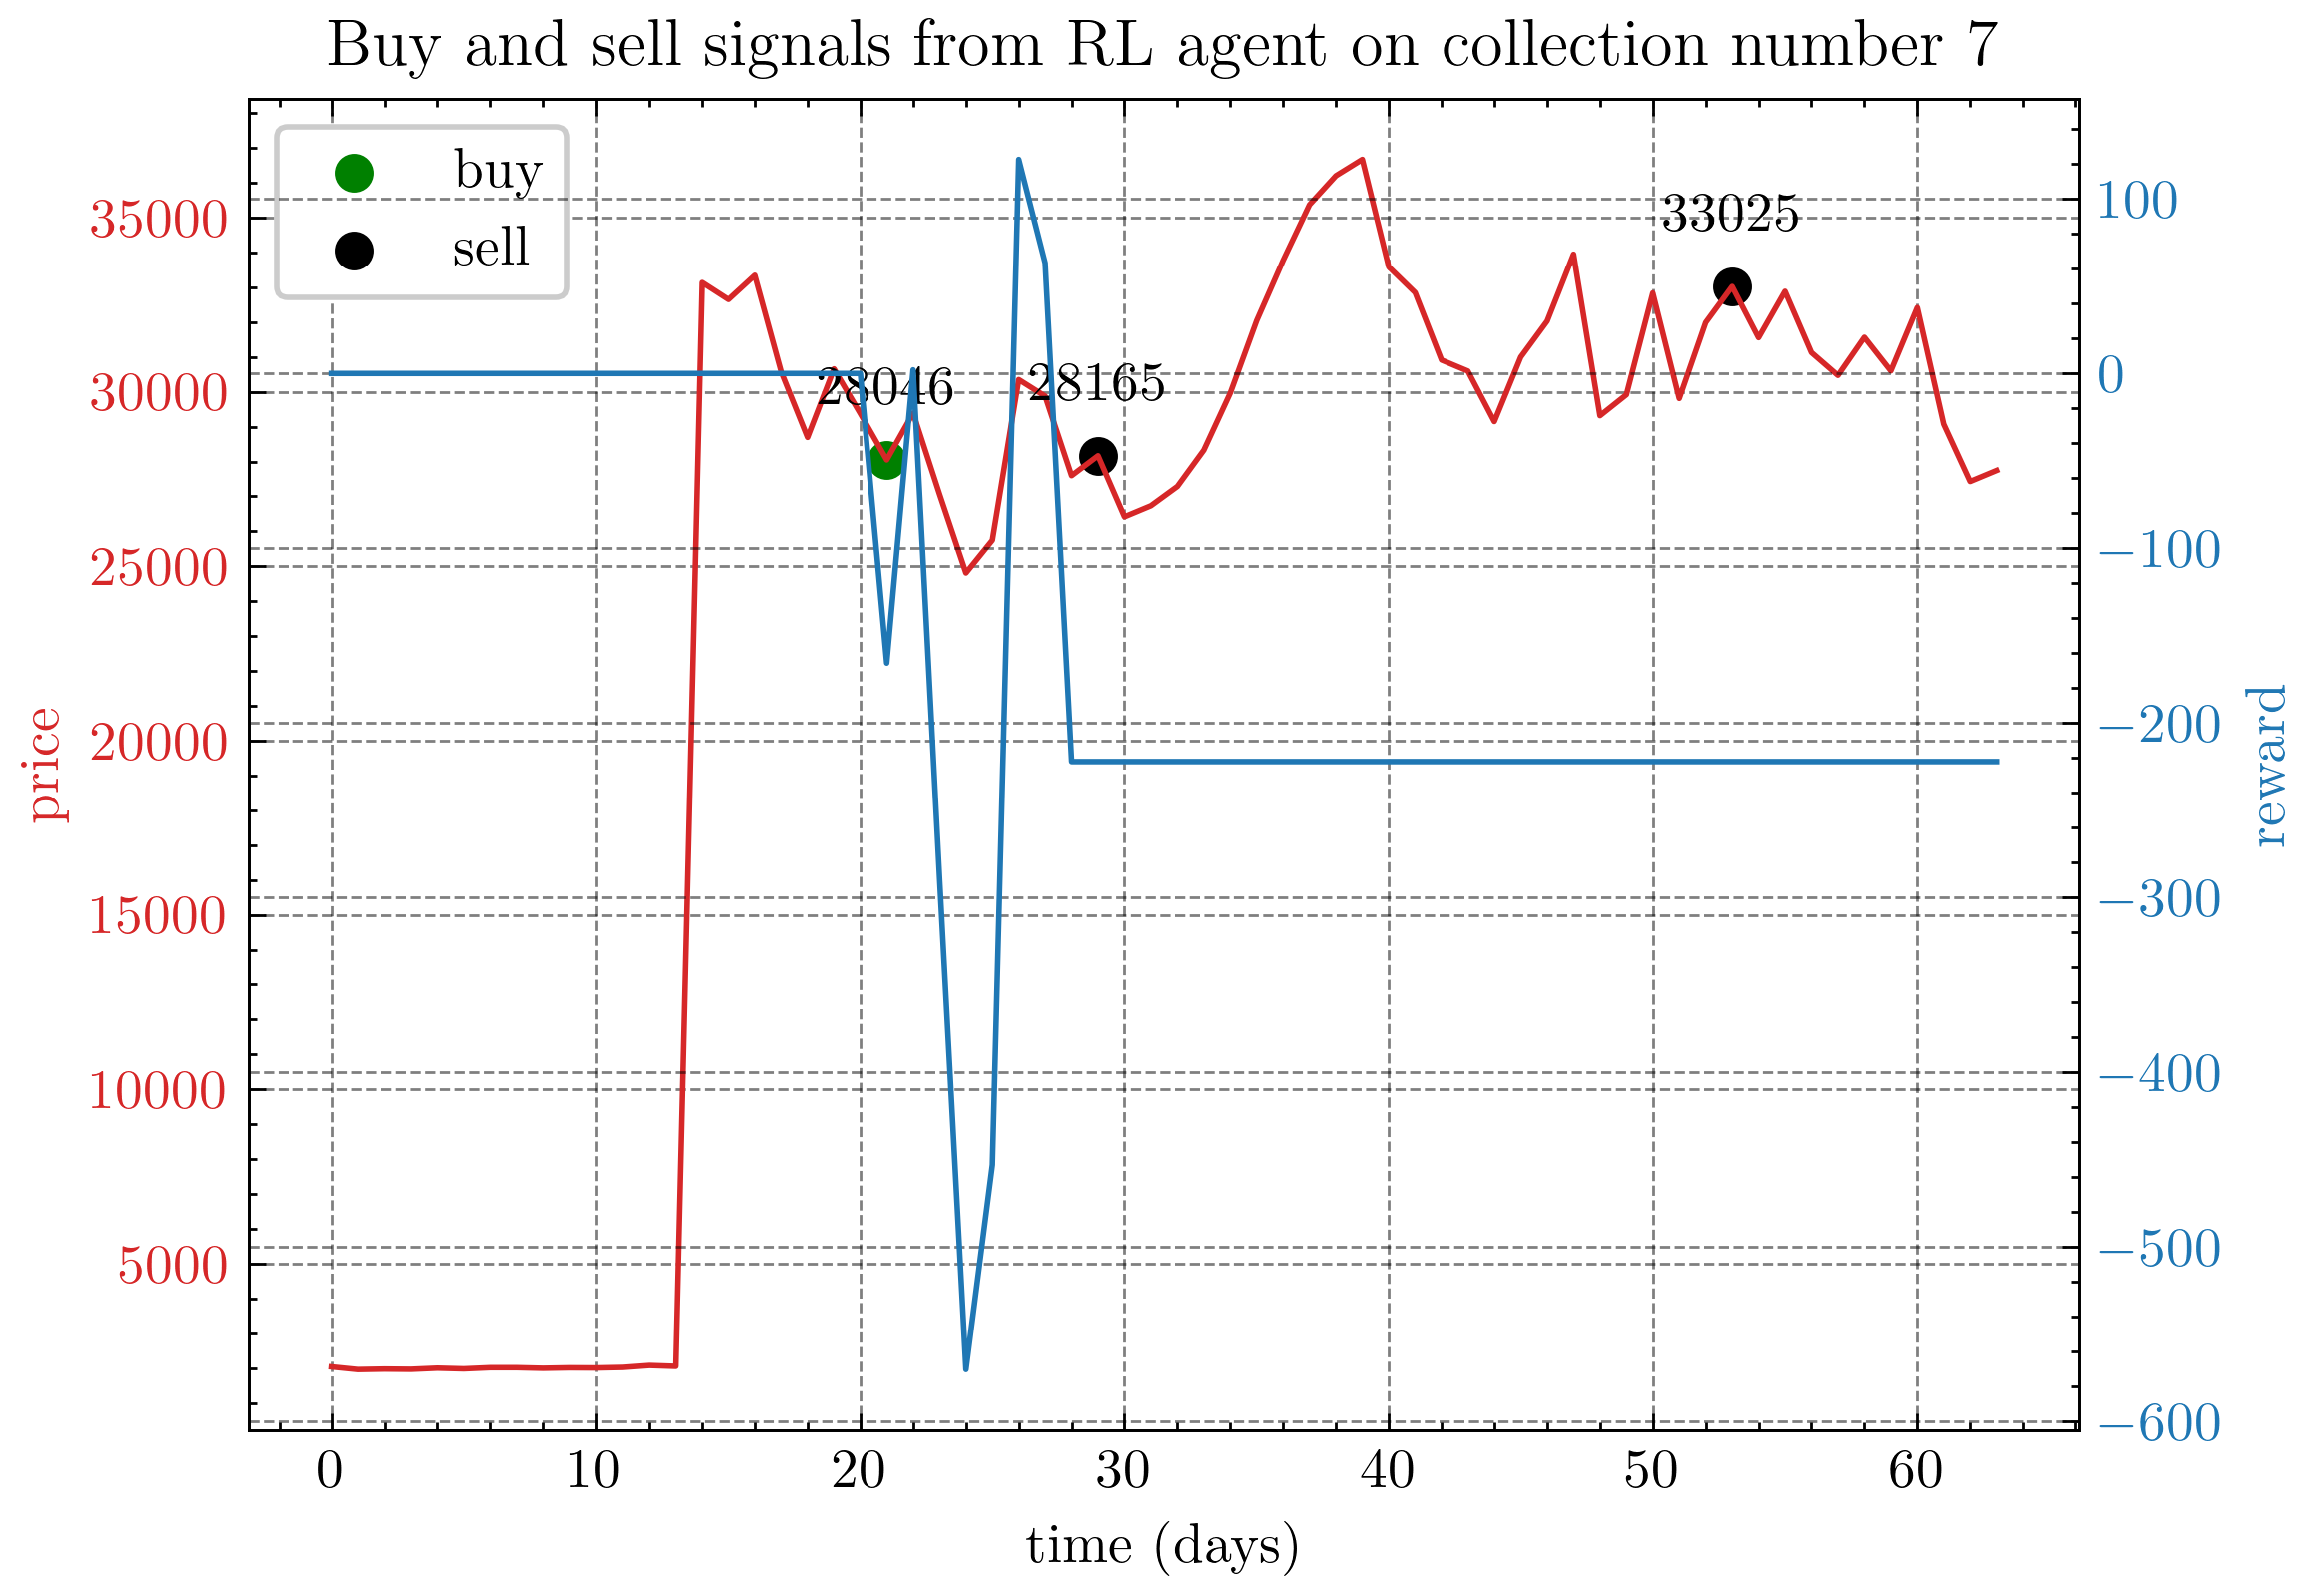

  1%|▏         | 14/1000 [00:01<01:38,  9.99it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  2%|▏         | 16/1000 [00:01<01:40,  9.79it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  6%|▋         | 63/1000 [00:05<01:28, 10.57it/s]


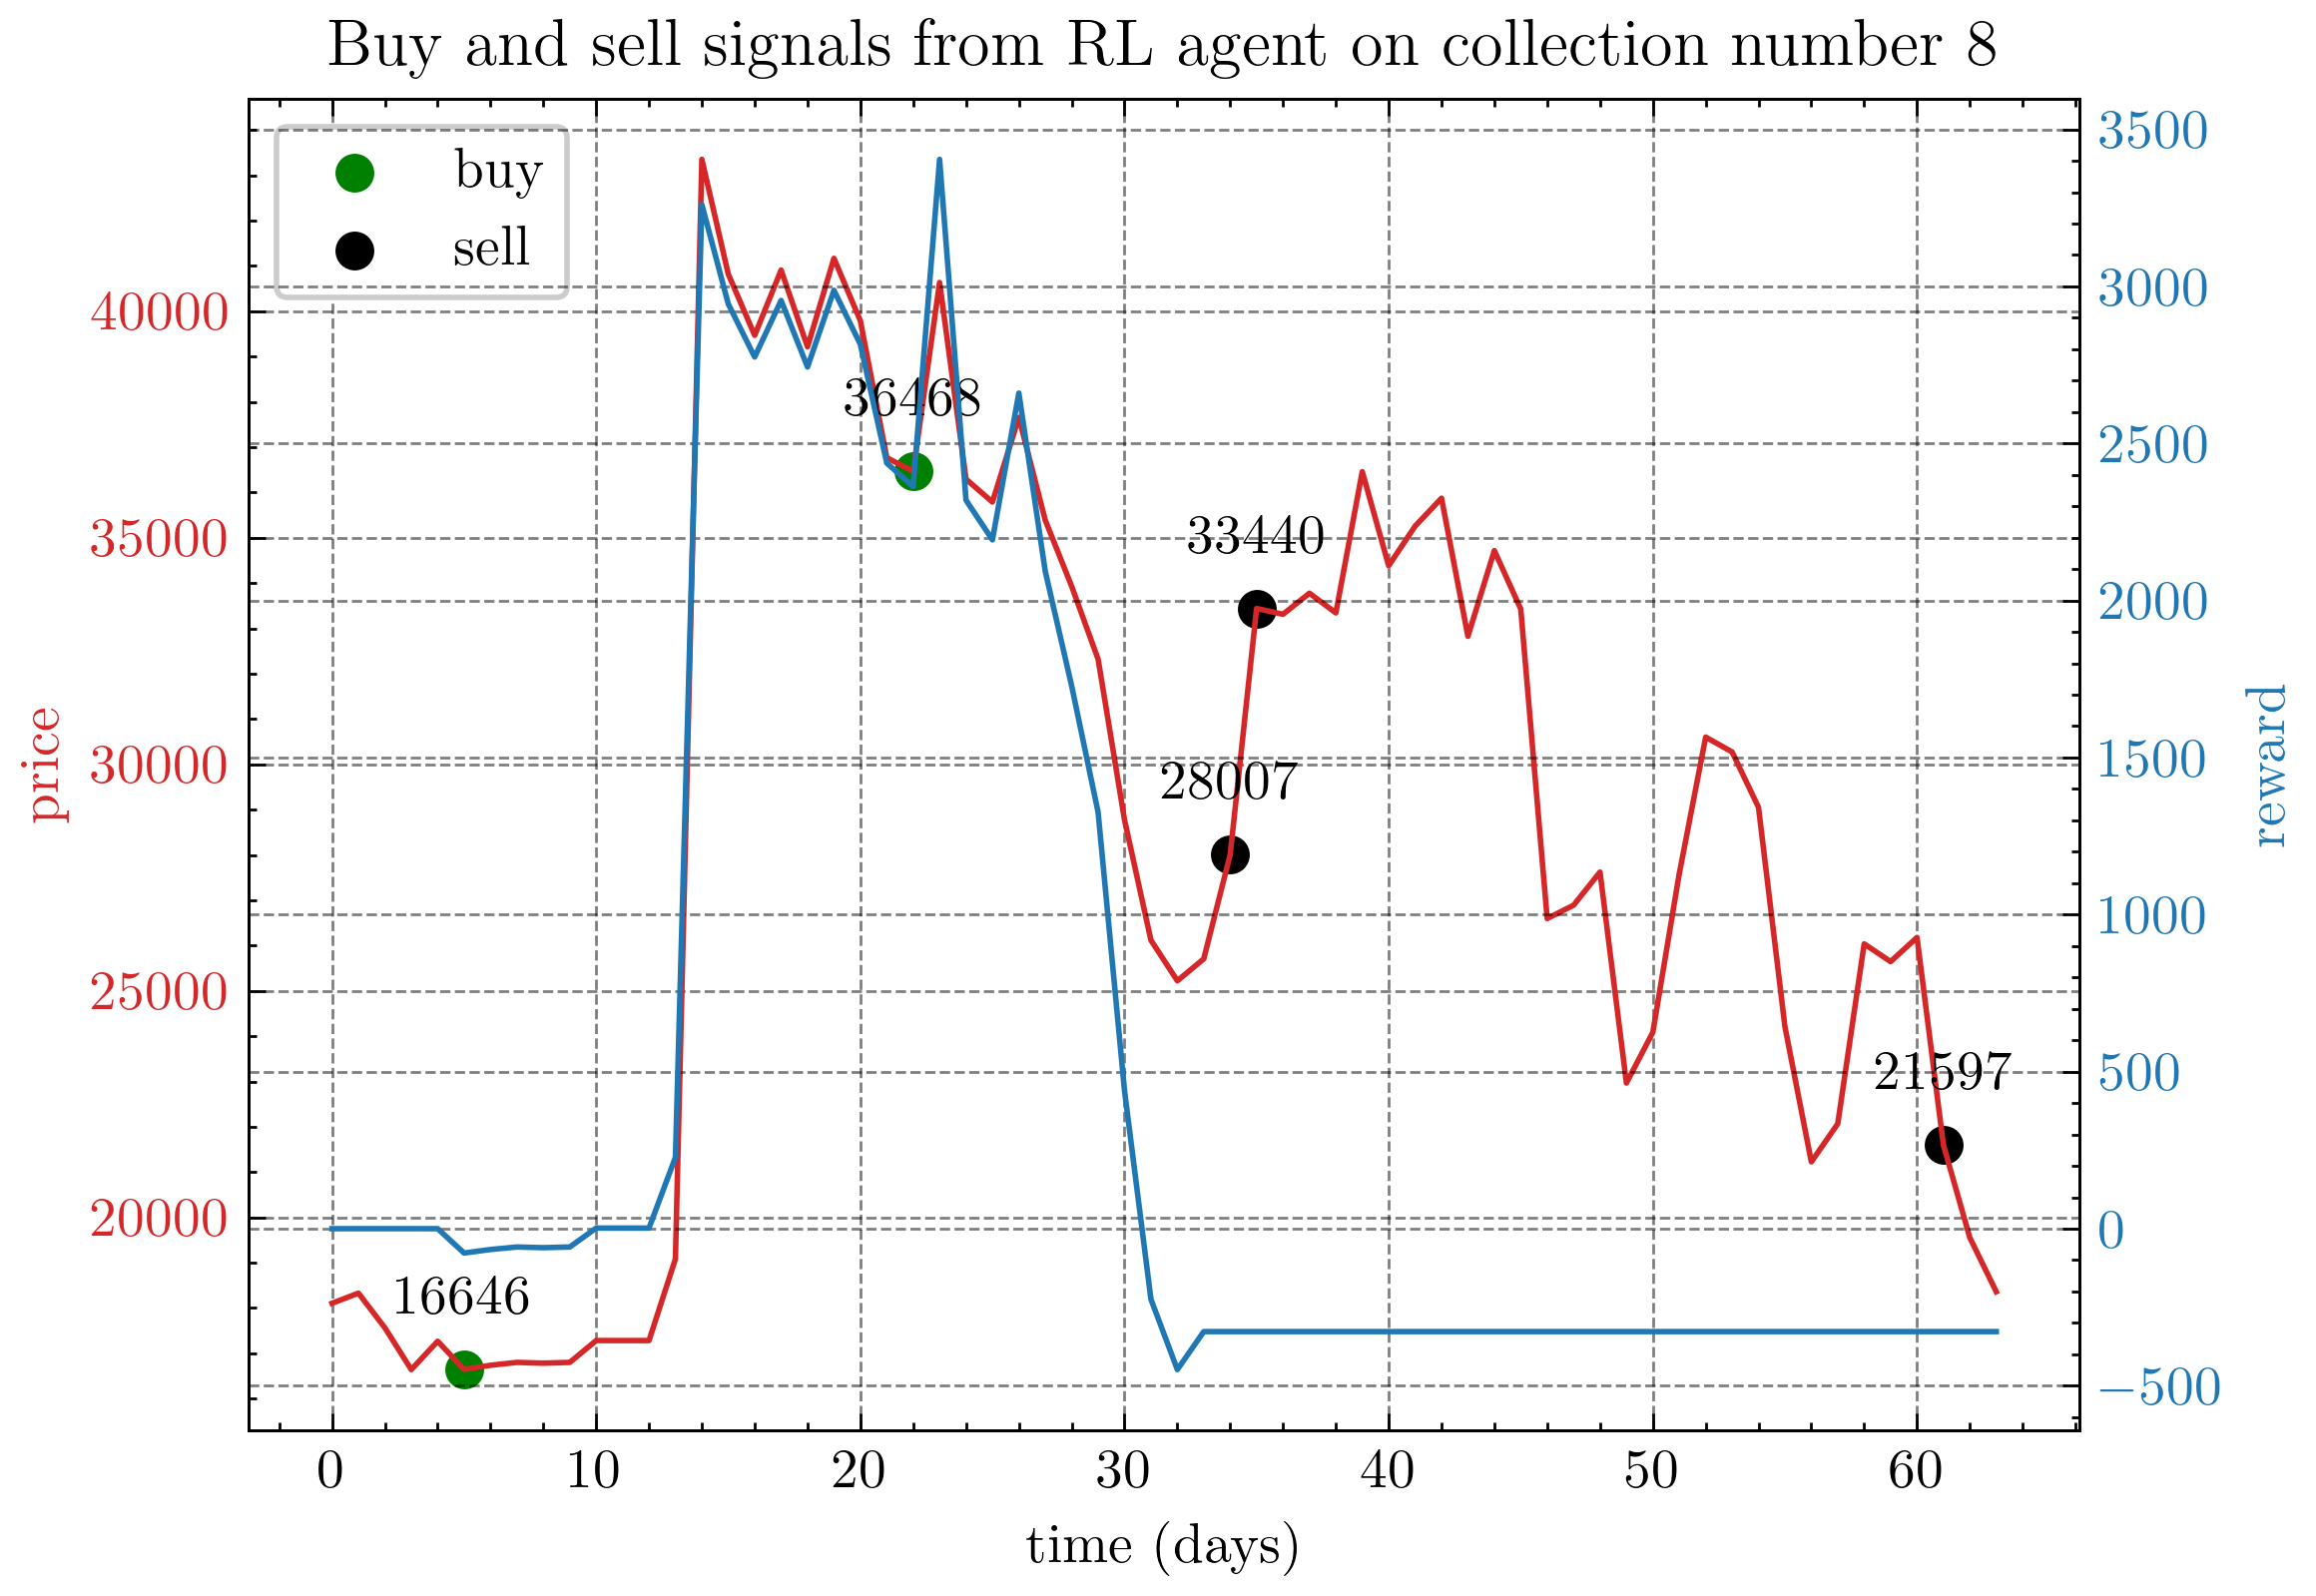

  1%|▏         | 14/1000 [00:01<01:43,  9.50it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  2%|▏         | 16/1000 [00:01<01:57,  8.35it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  6%|▋         | 63/1000 [00:06<01:29, 10.42it/s]


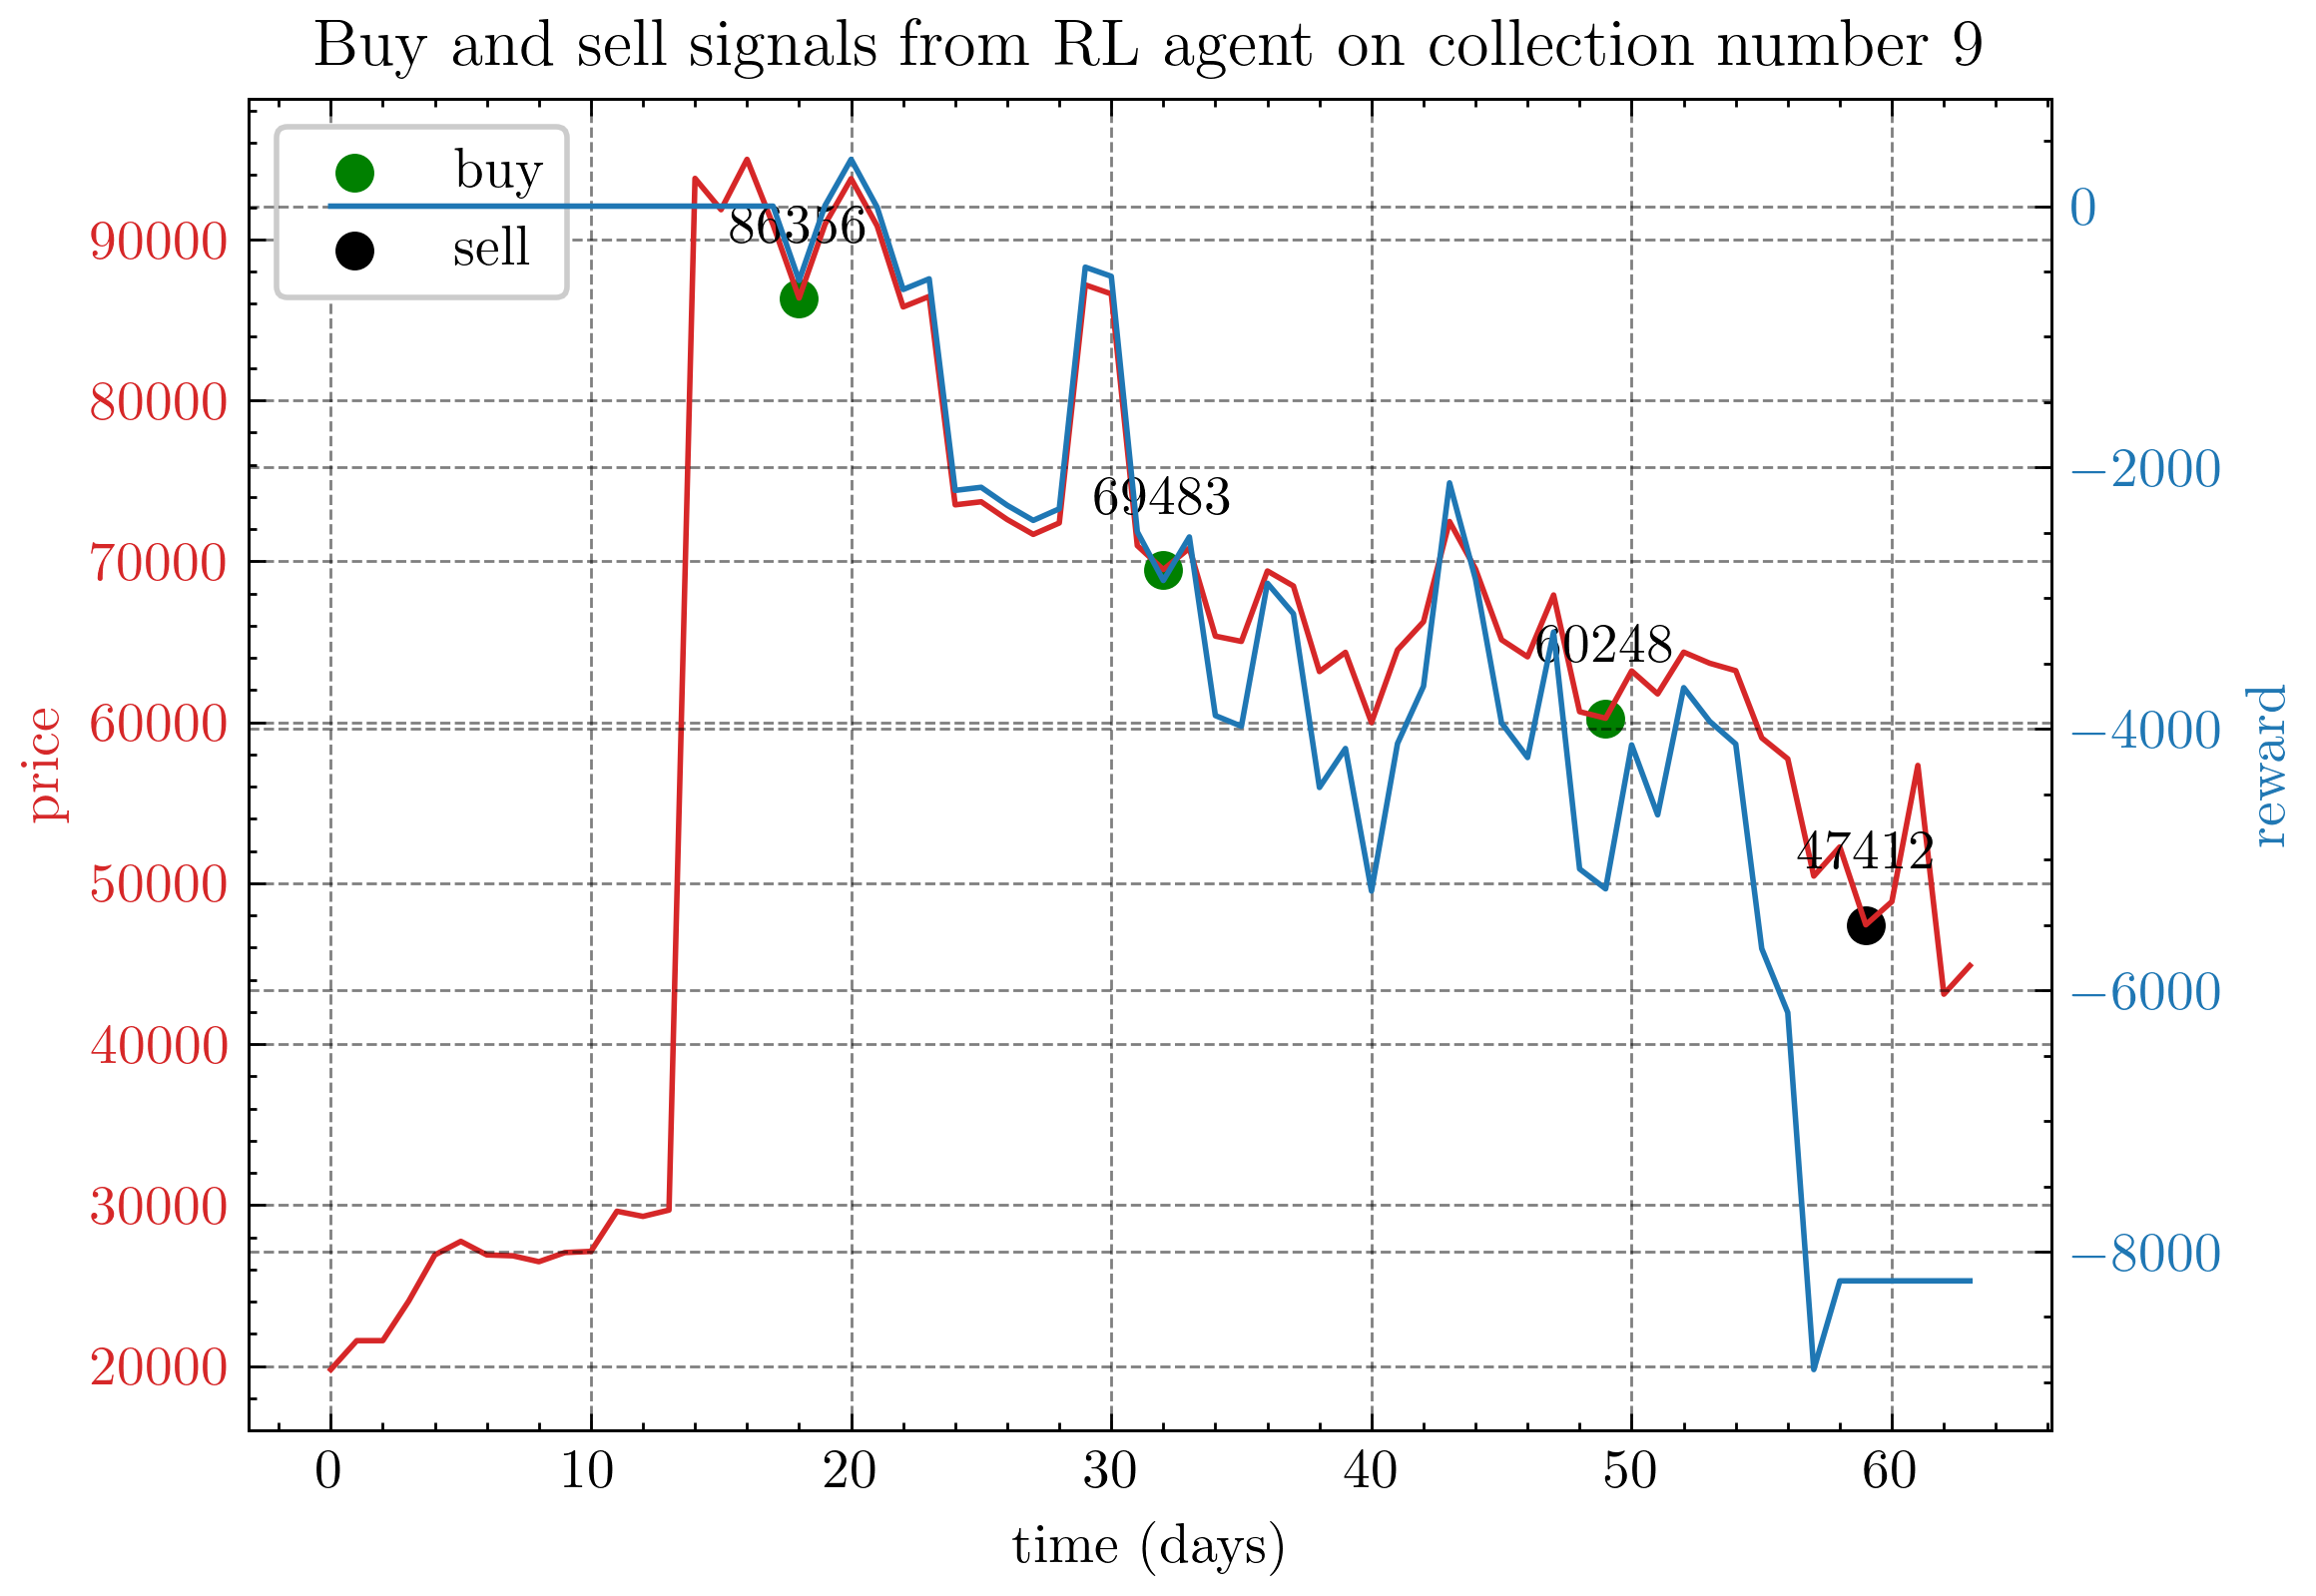

  6%|▋         | 63/1000 [00:06<01:32, 10.18it/s]


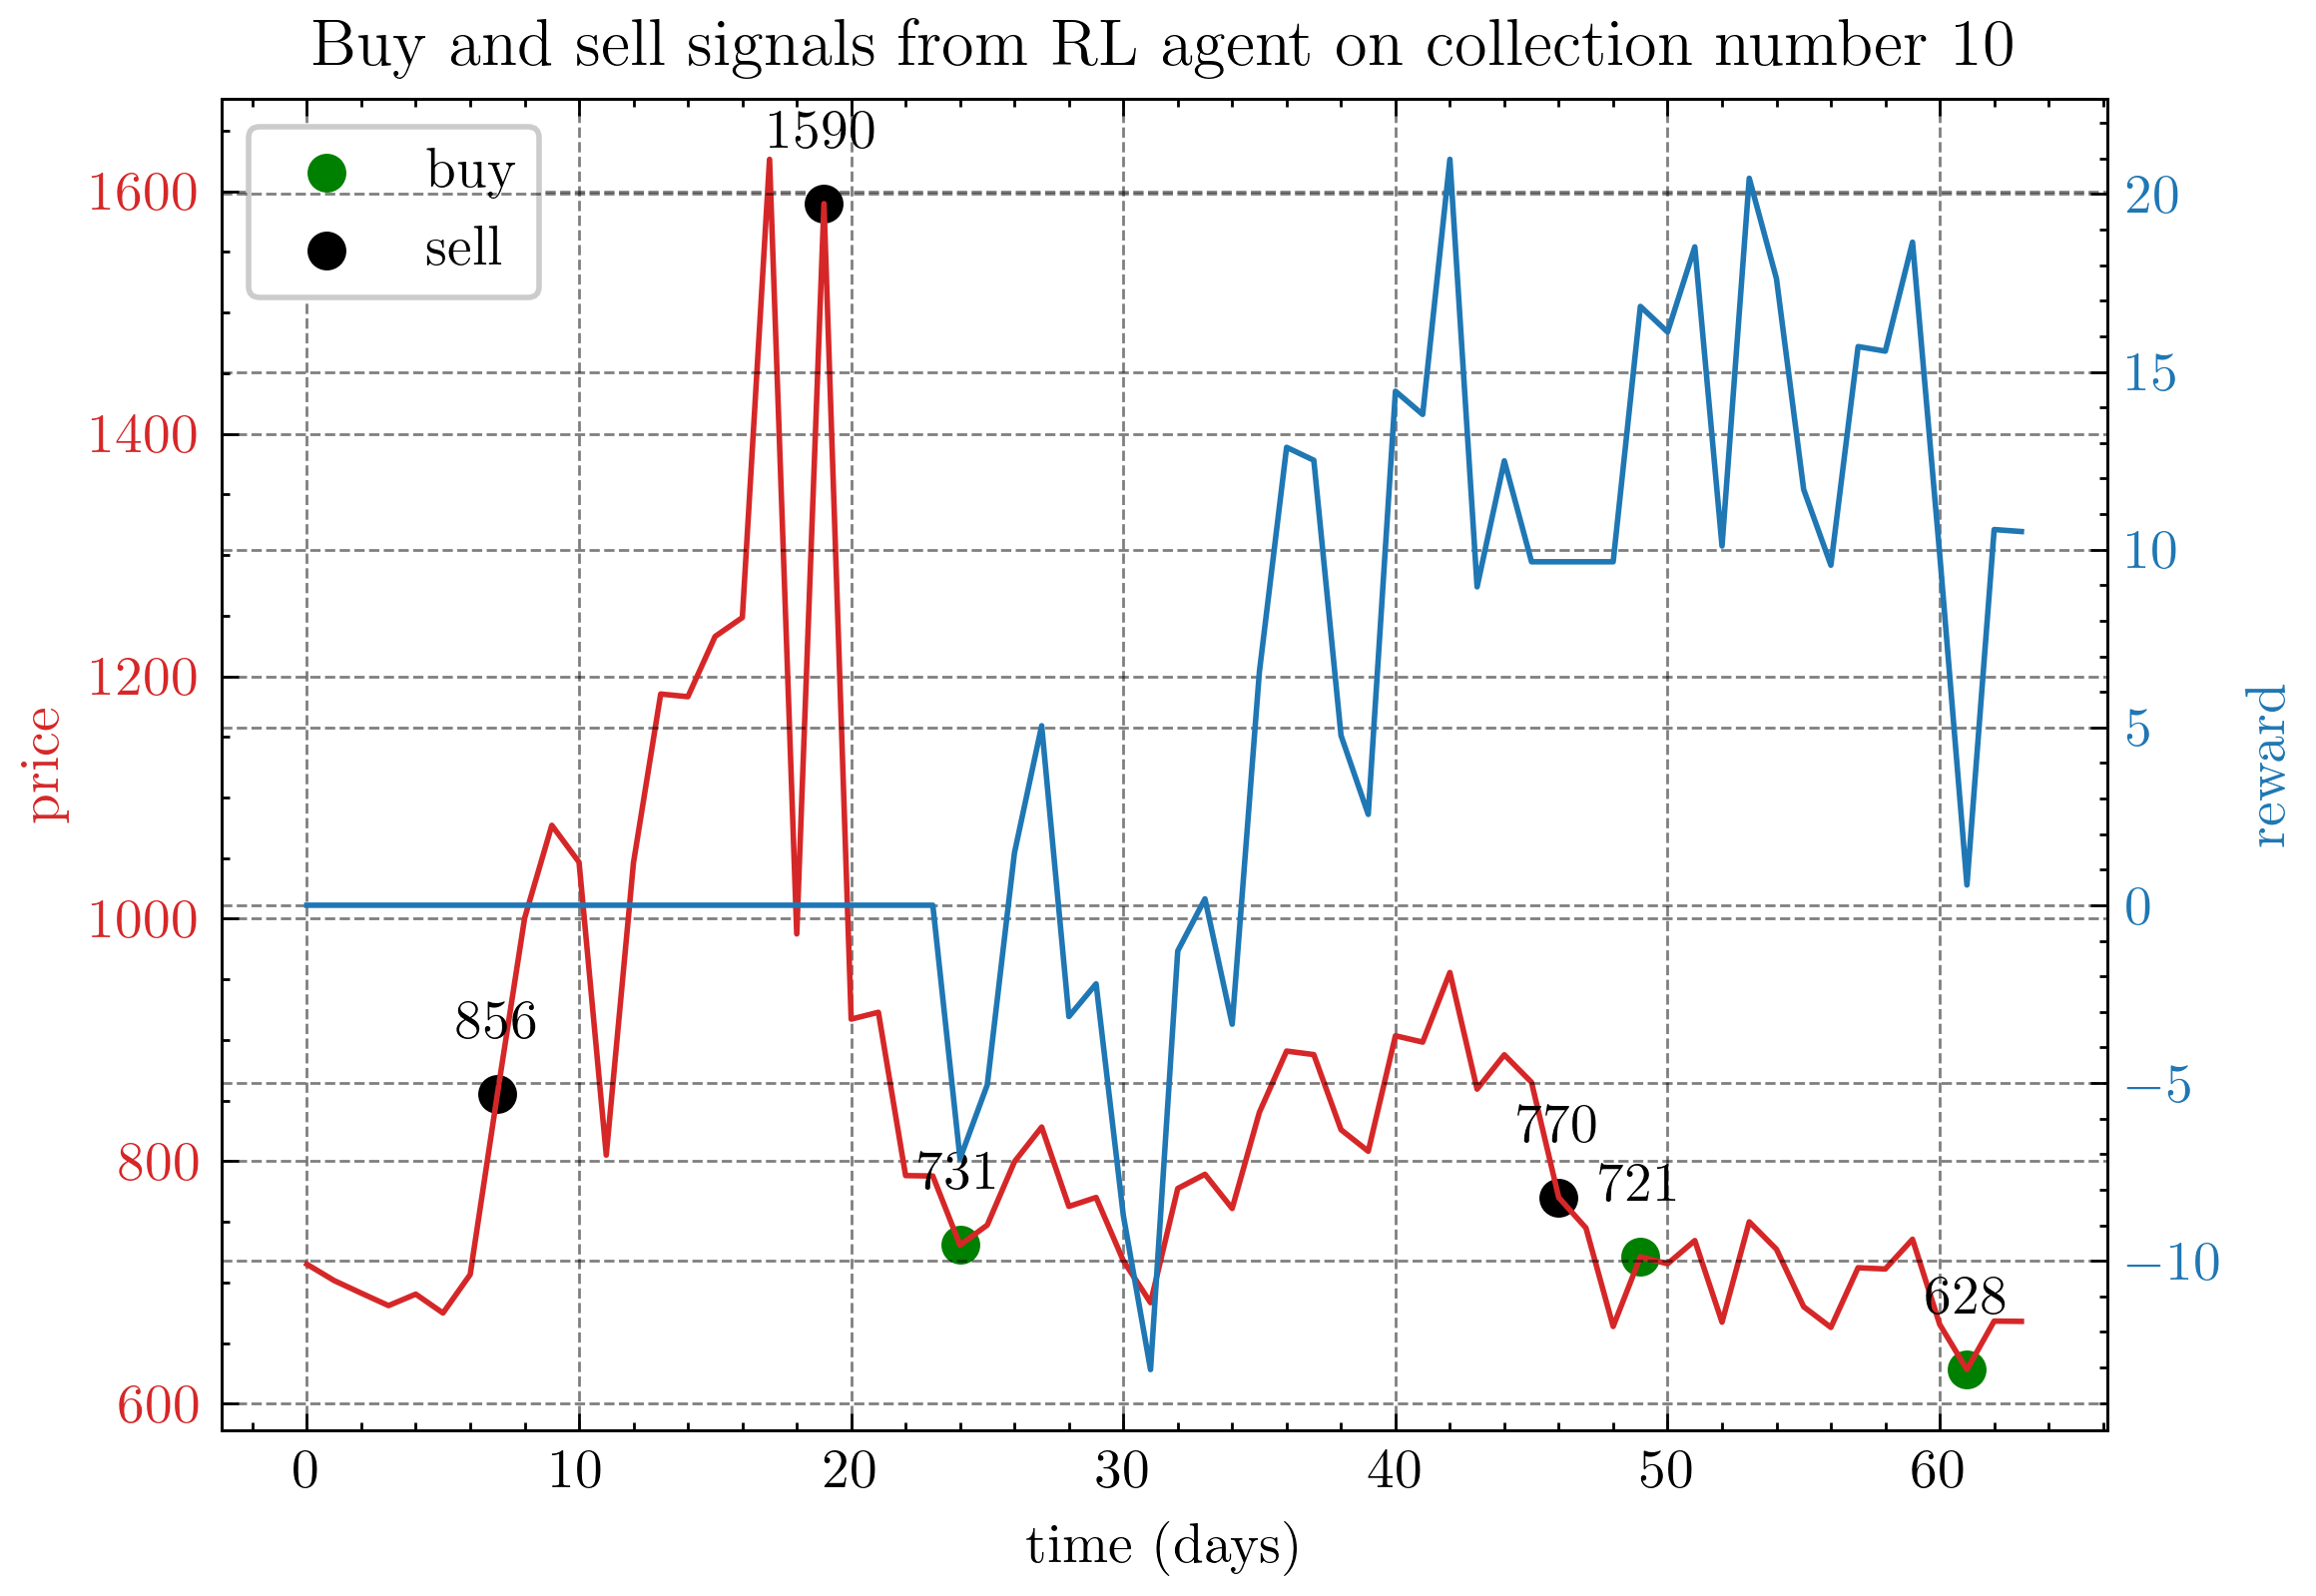

  6%|▋         | 63/1000 [00:06<01:33, 10.01it/s]


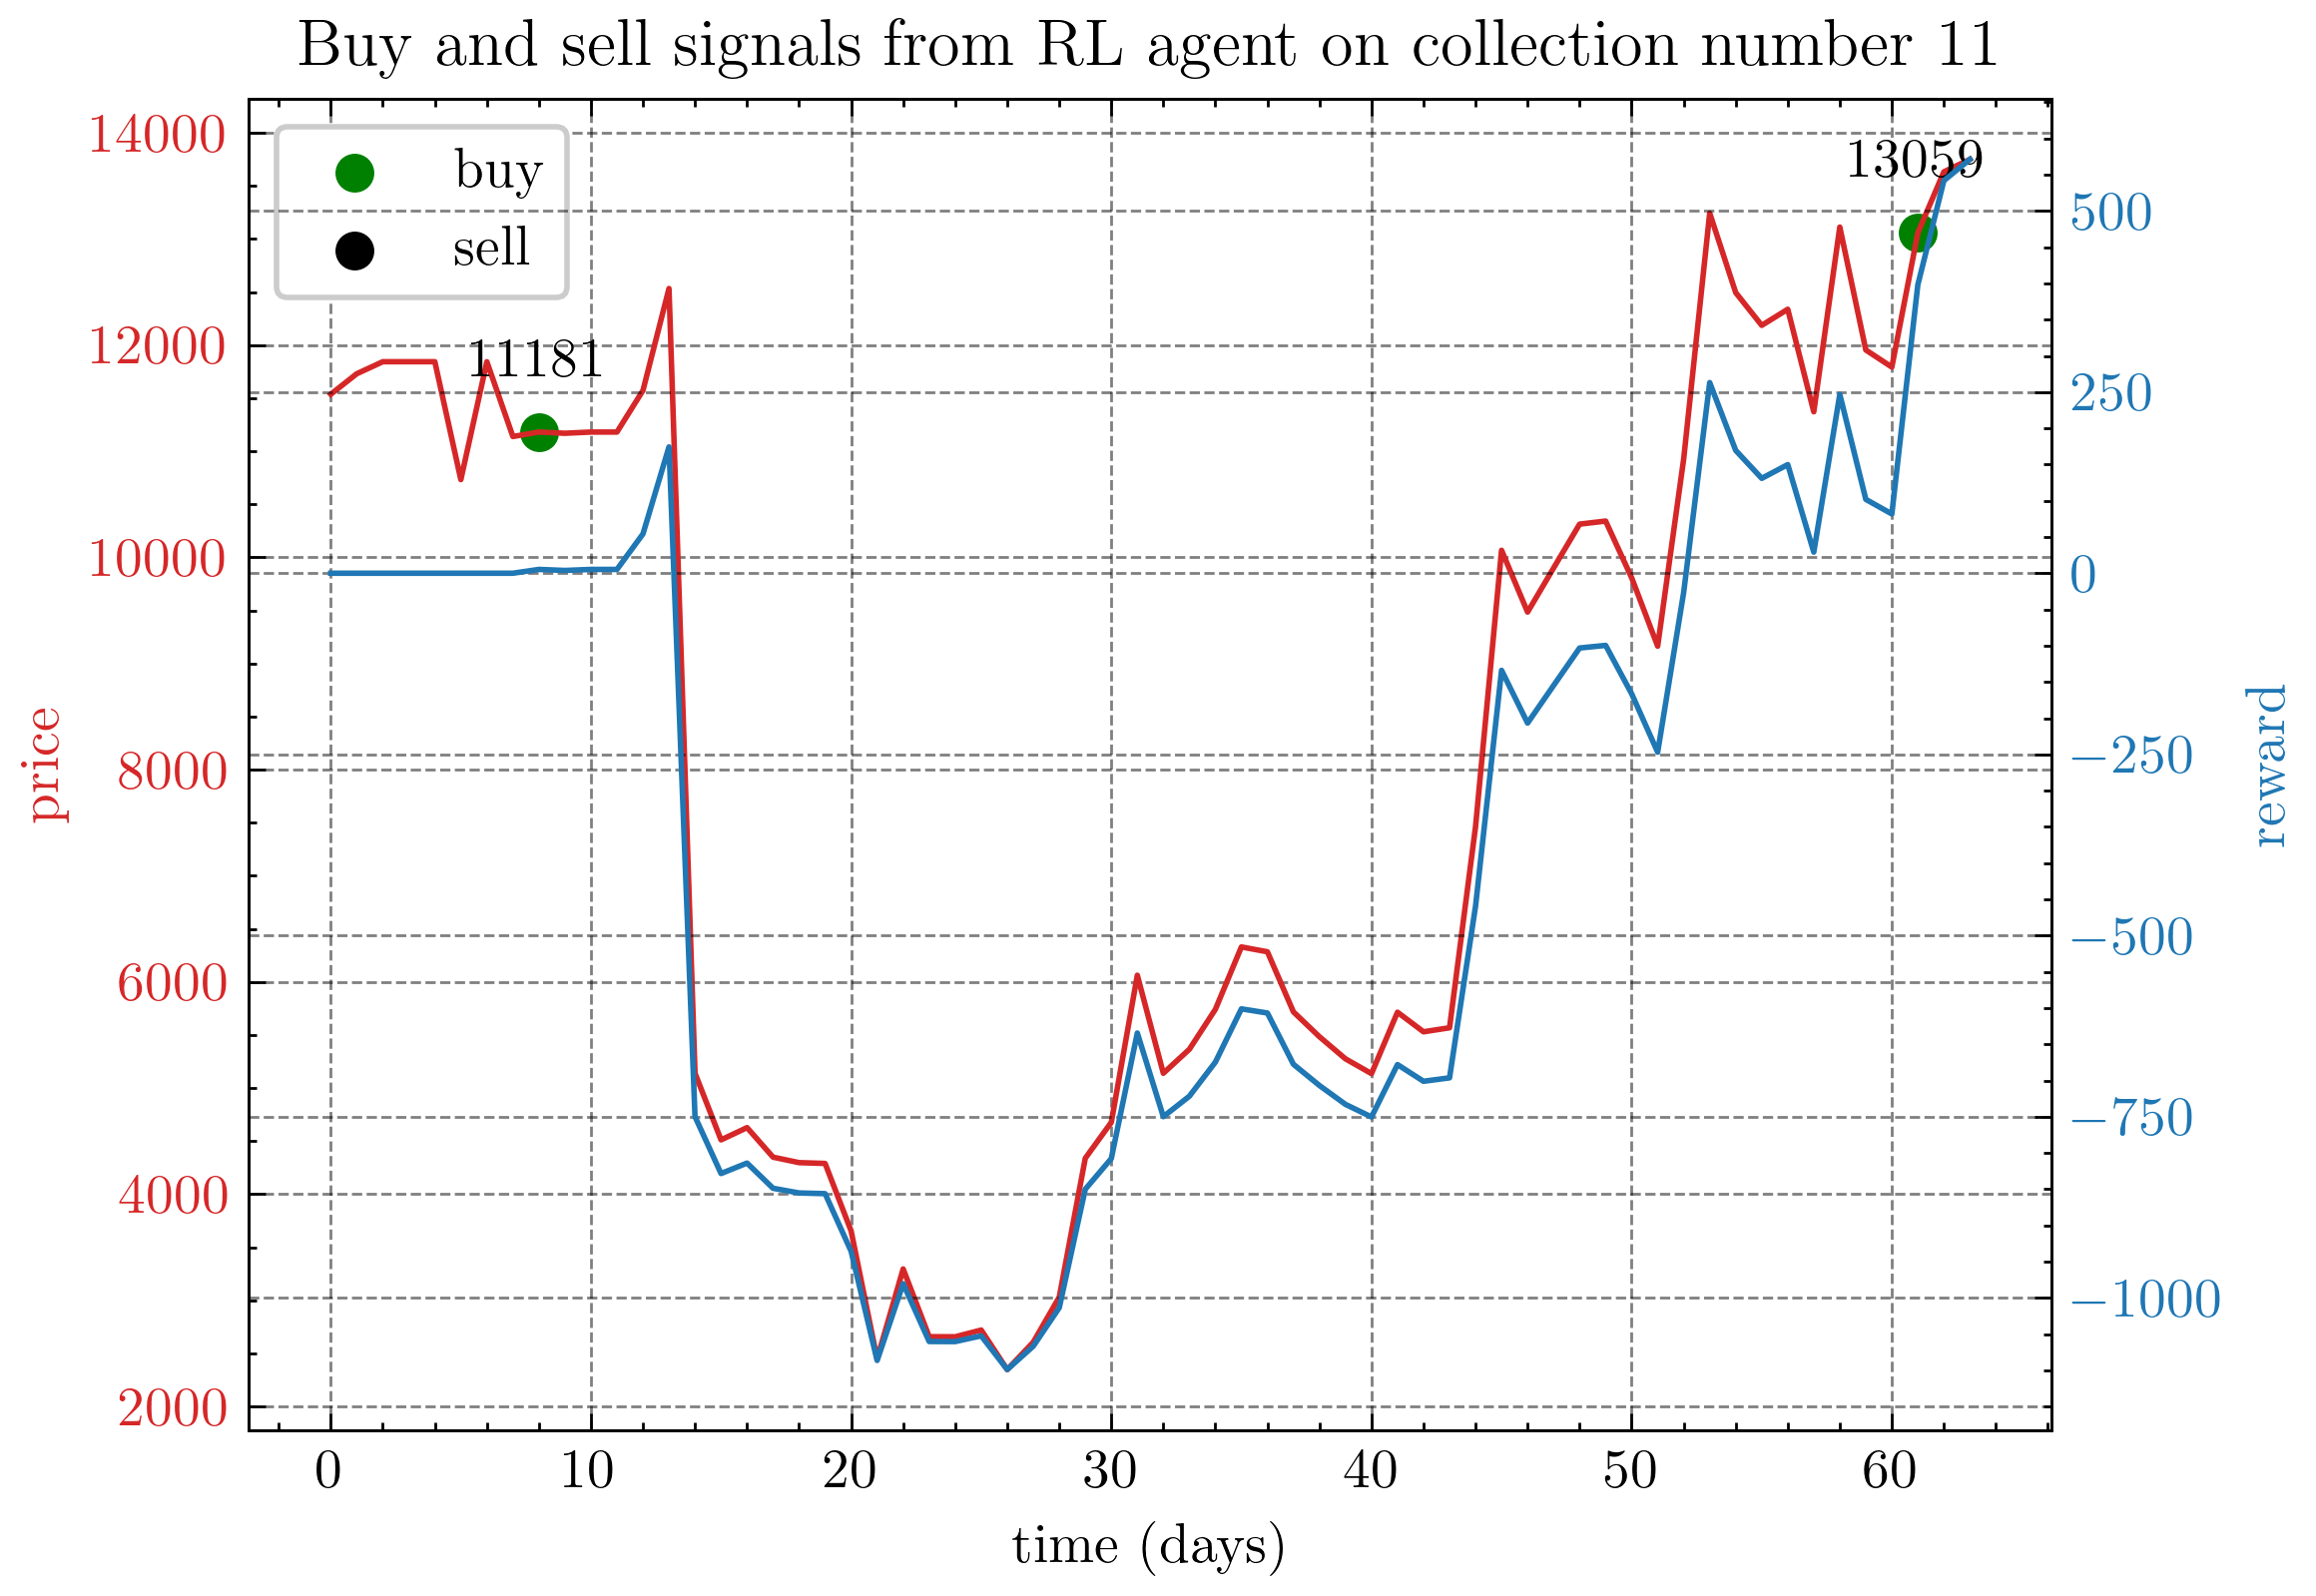

  6%|▋         | 63/1000 [00:06<01:33,  9.99it/s]


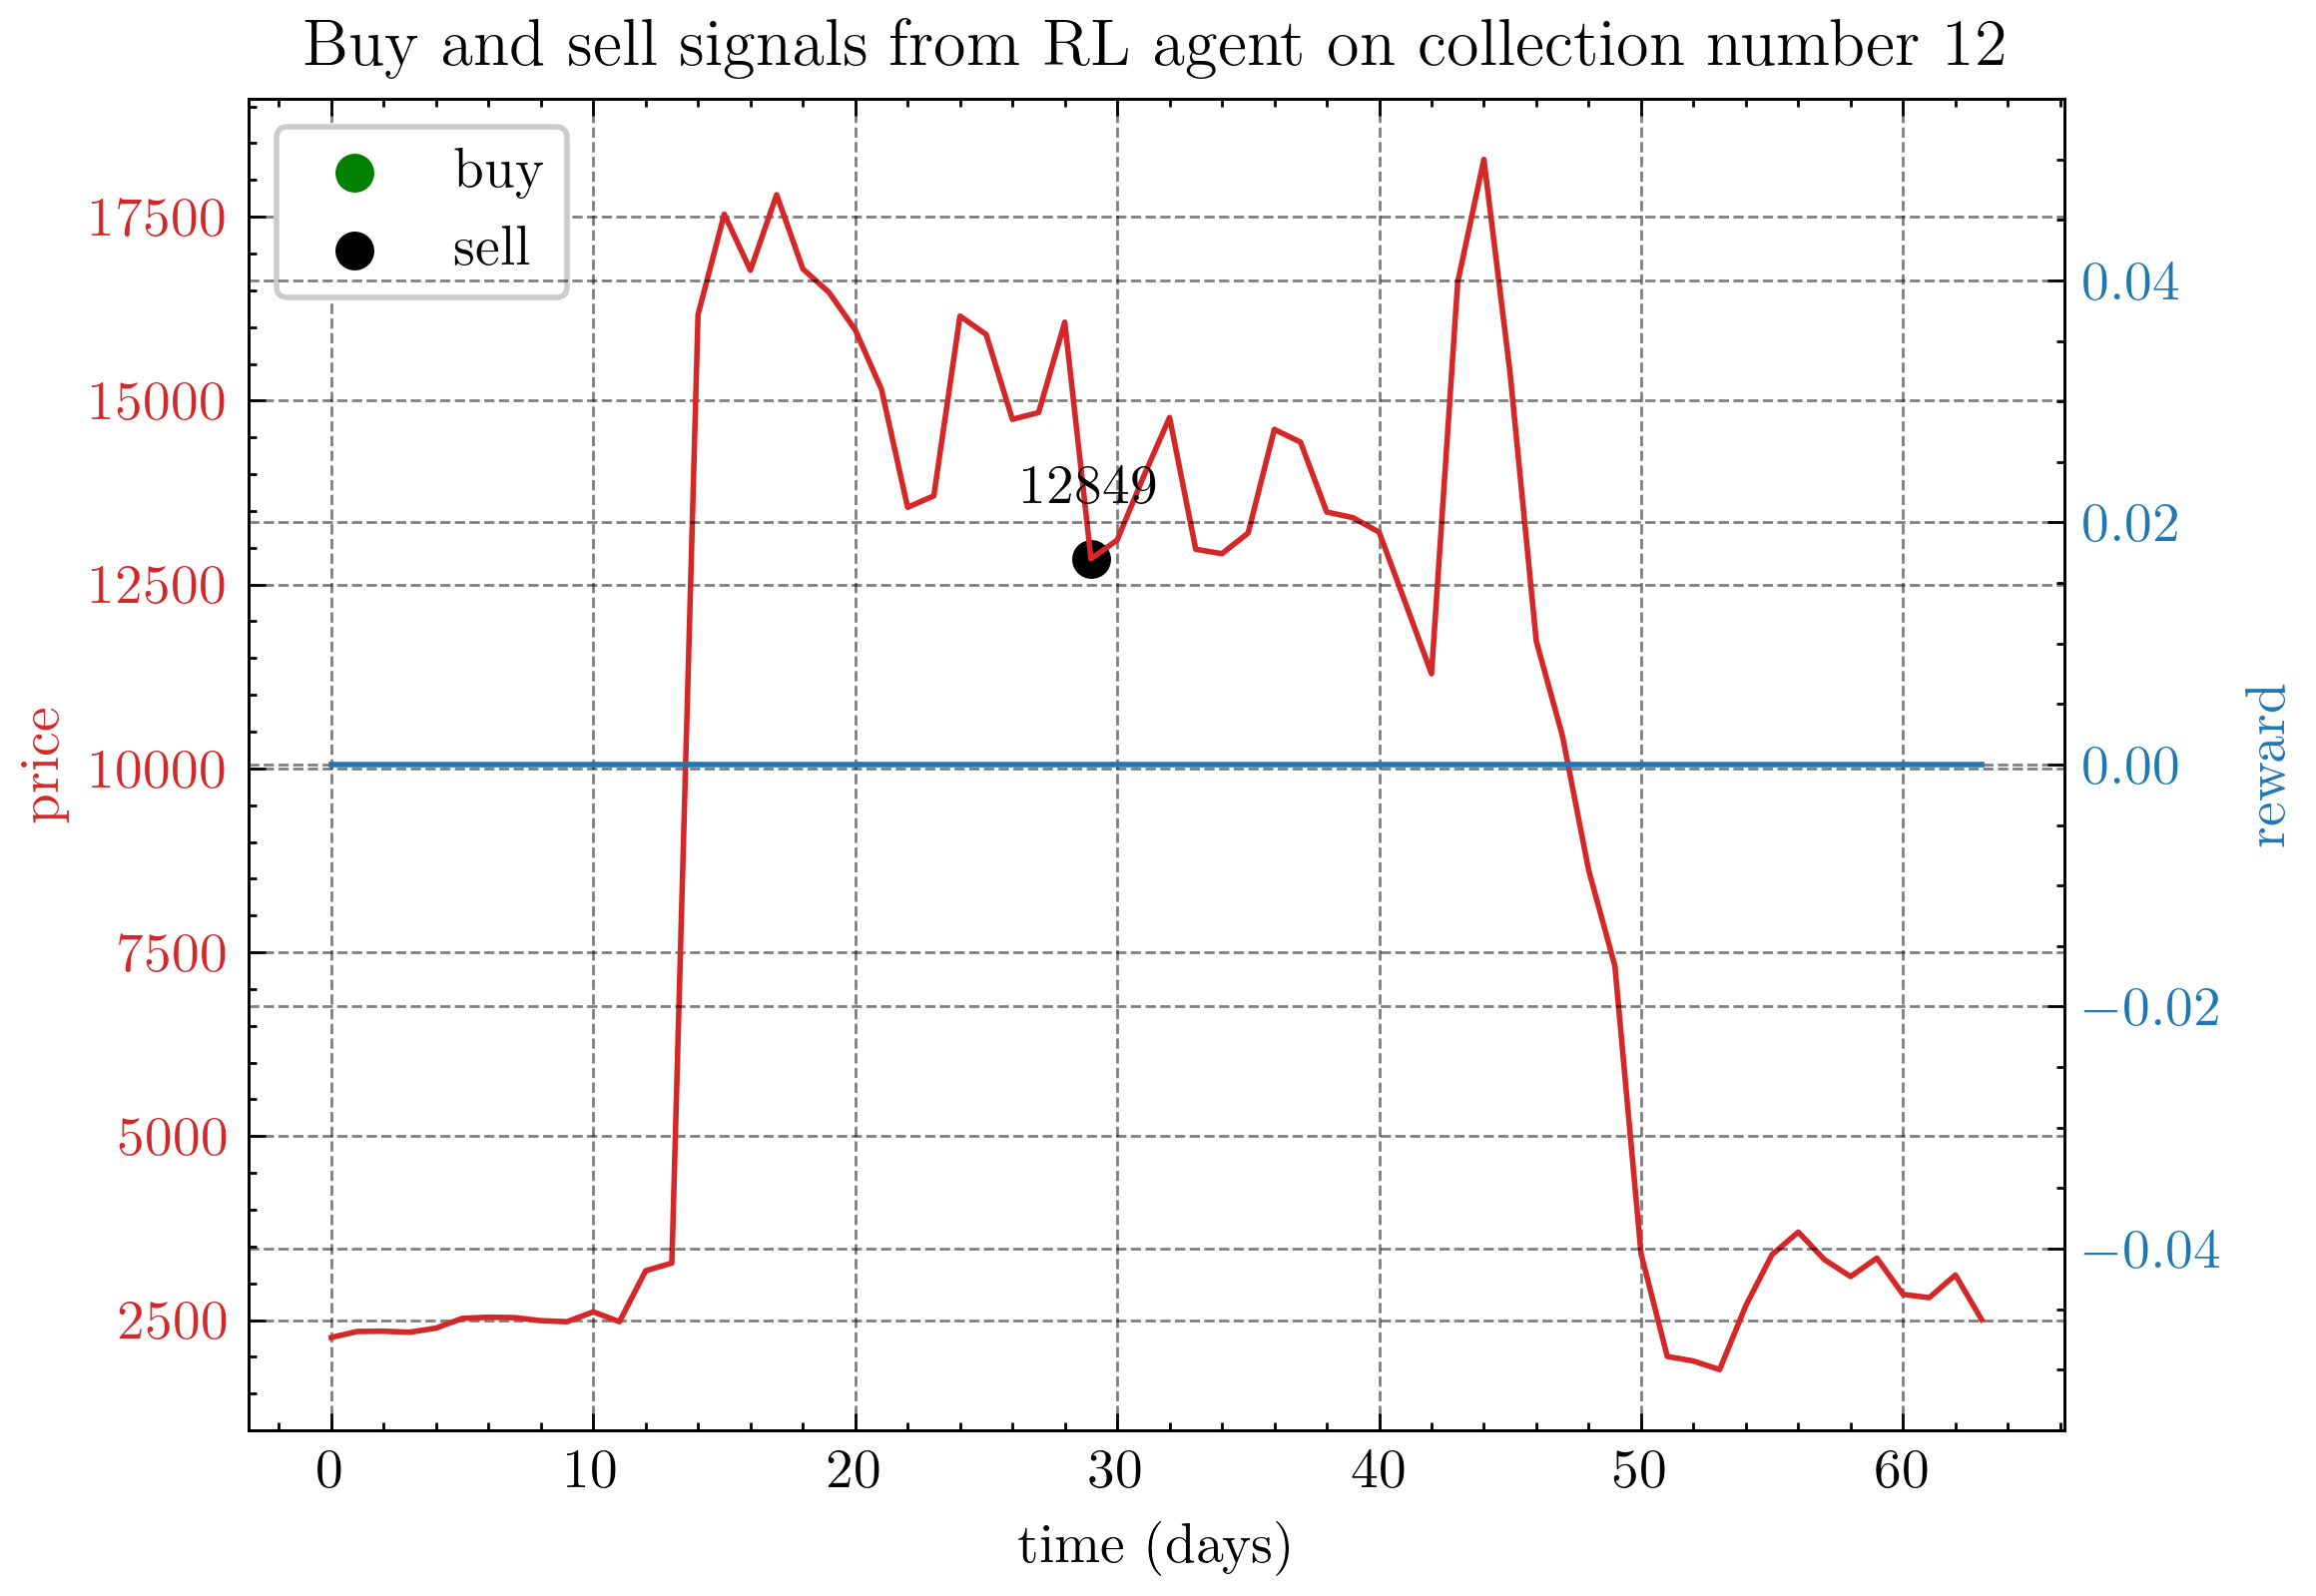

  6%|▋         | 63/1000 [00:05<01:27, 10.66it/s]


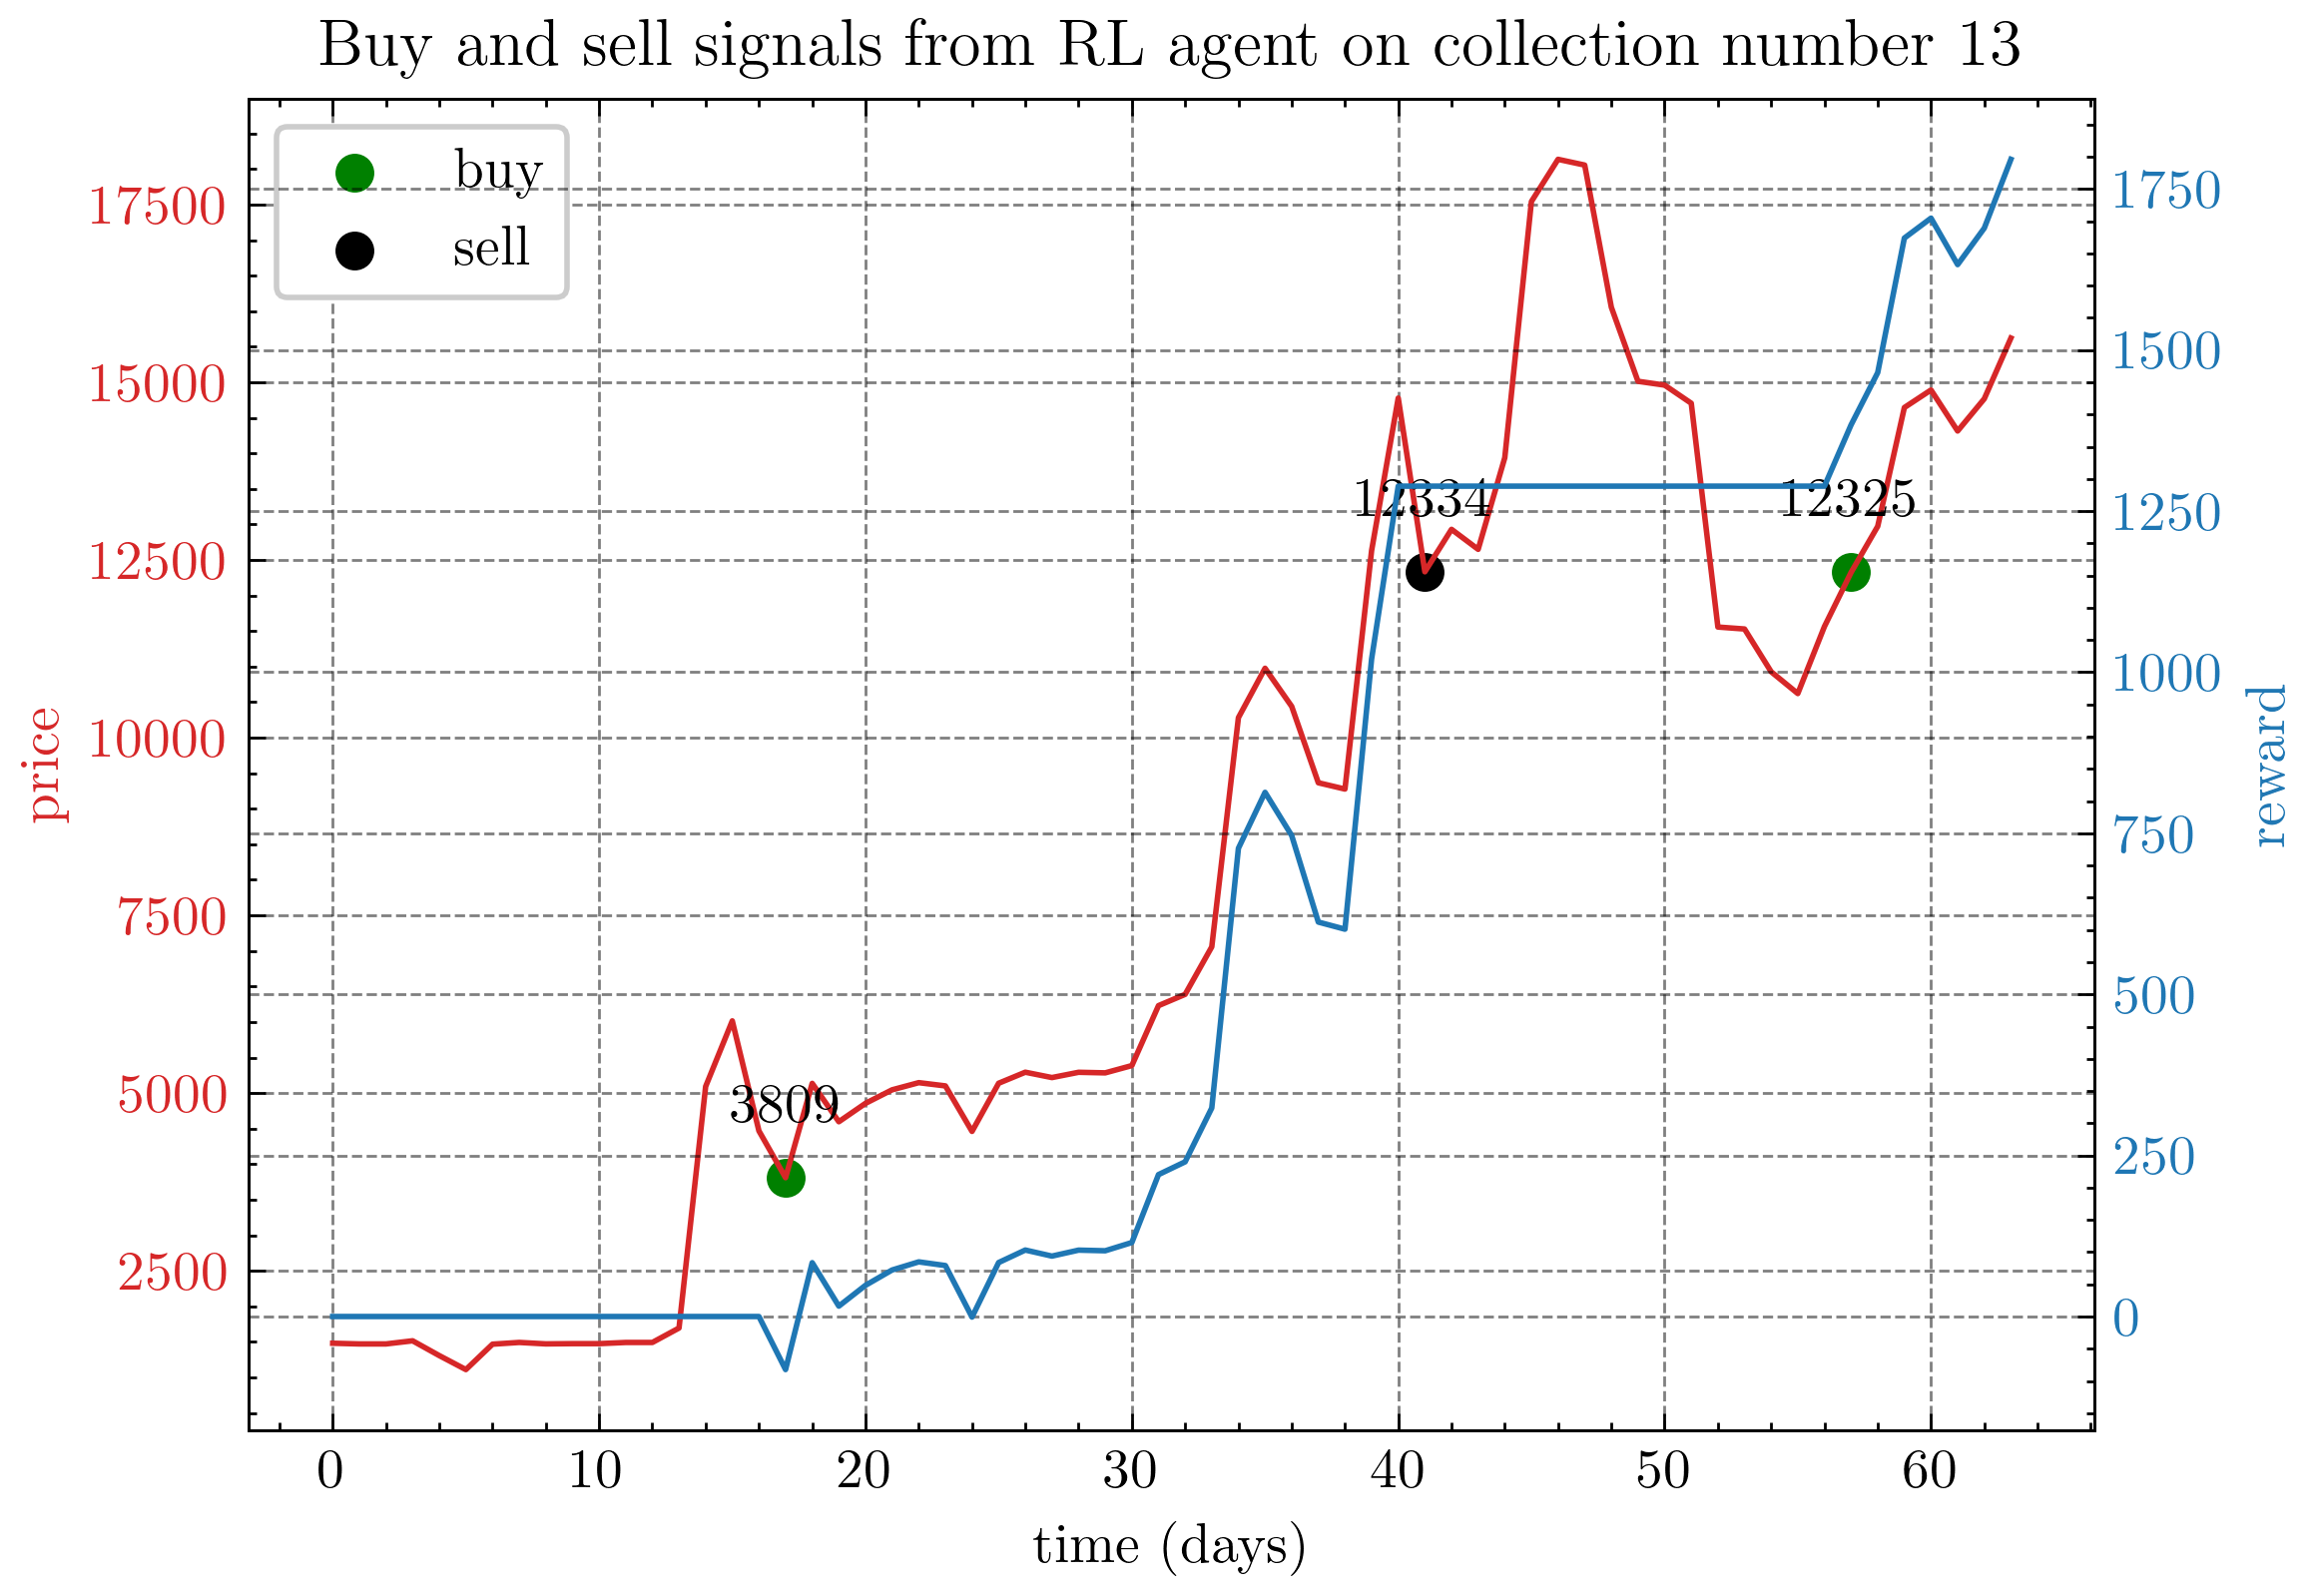

  6%|▋         | 63/1000 [00:06<01:40,  9.34it/s]


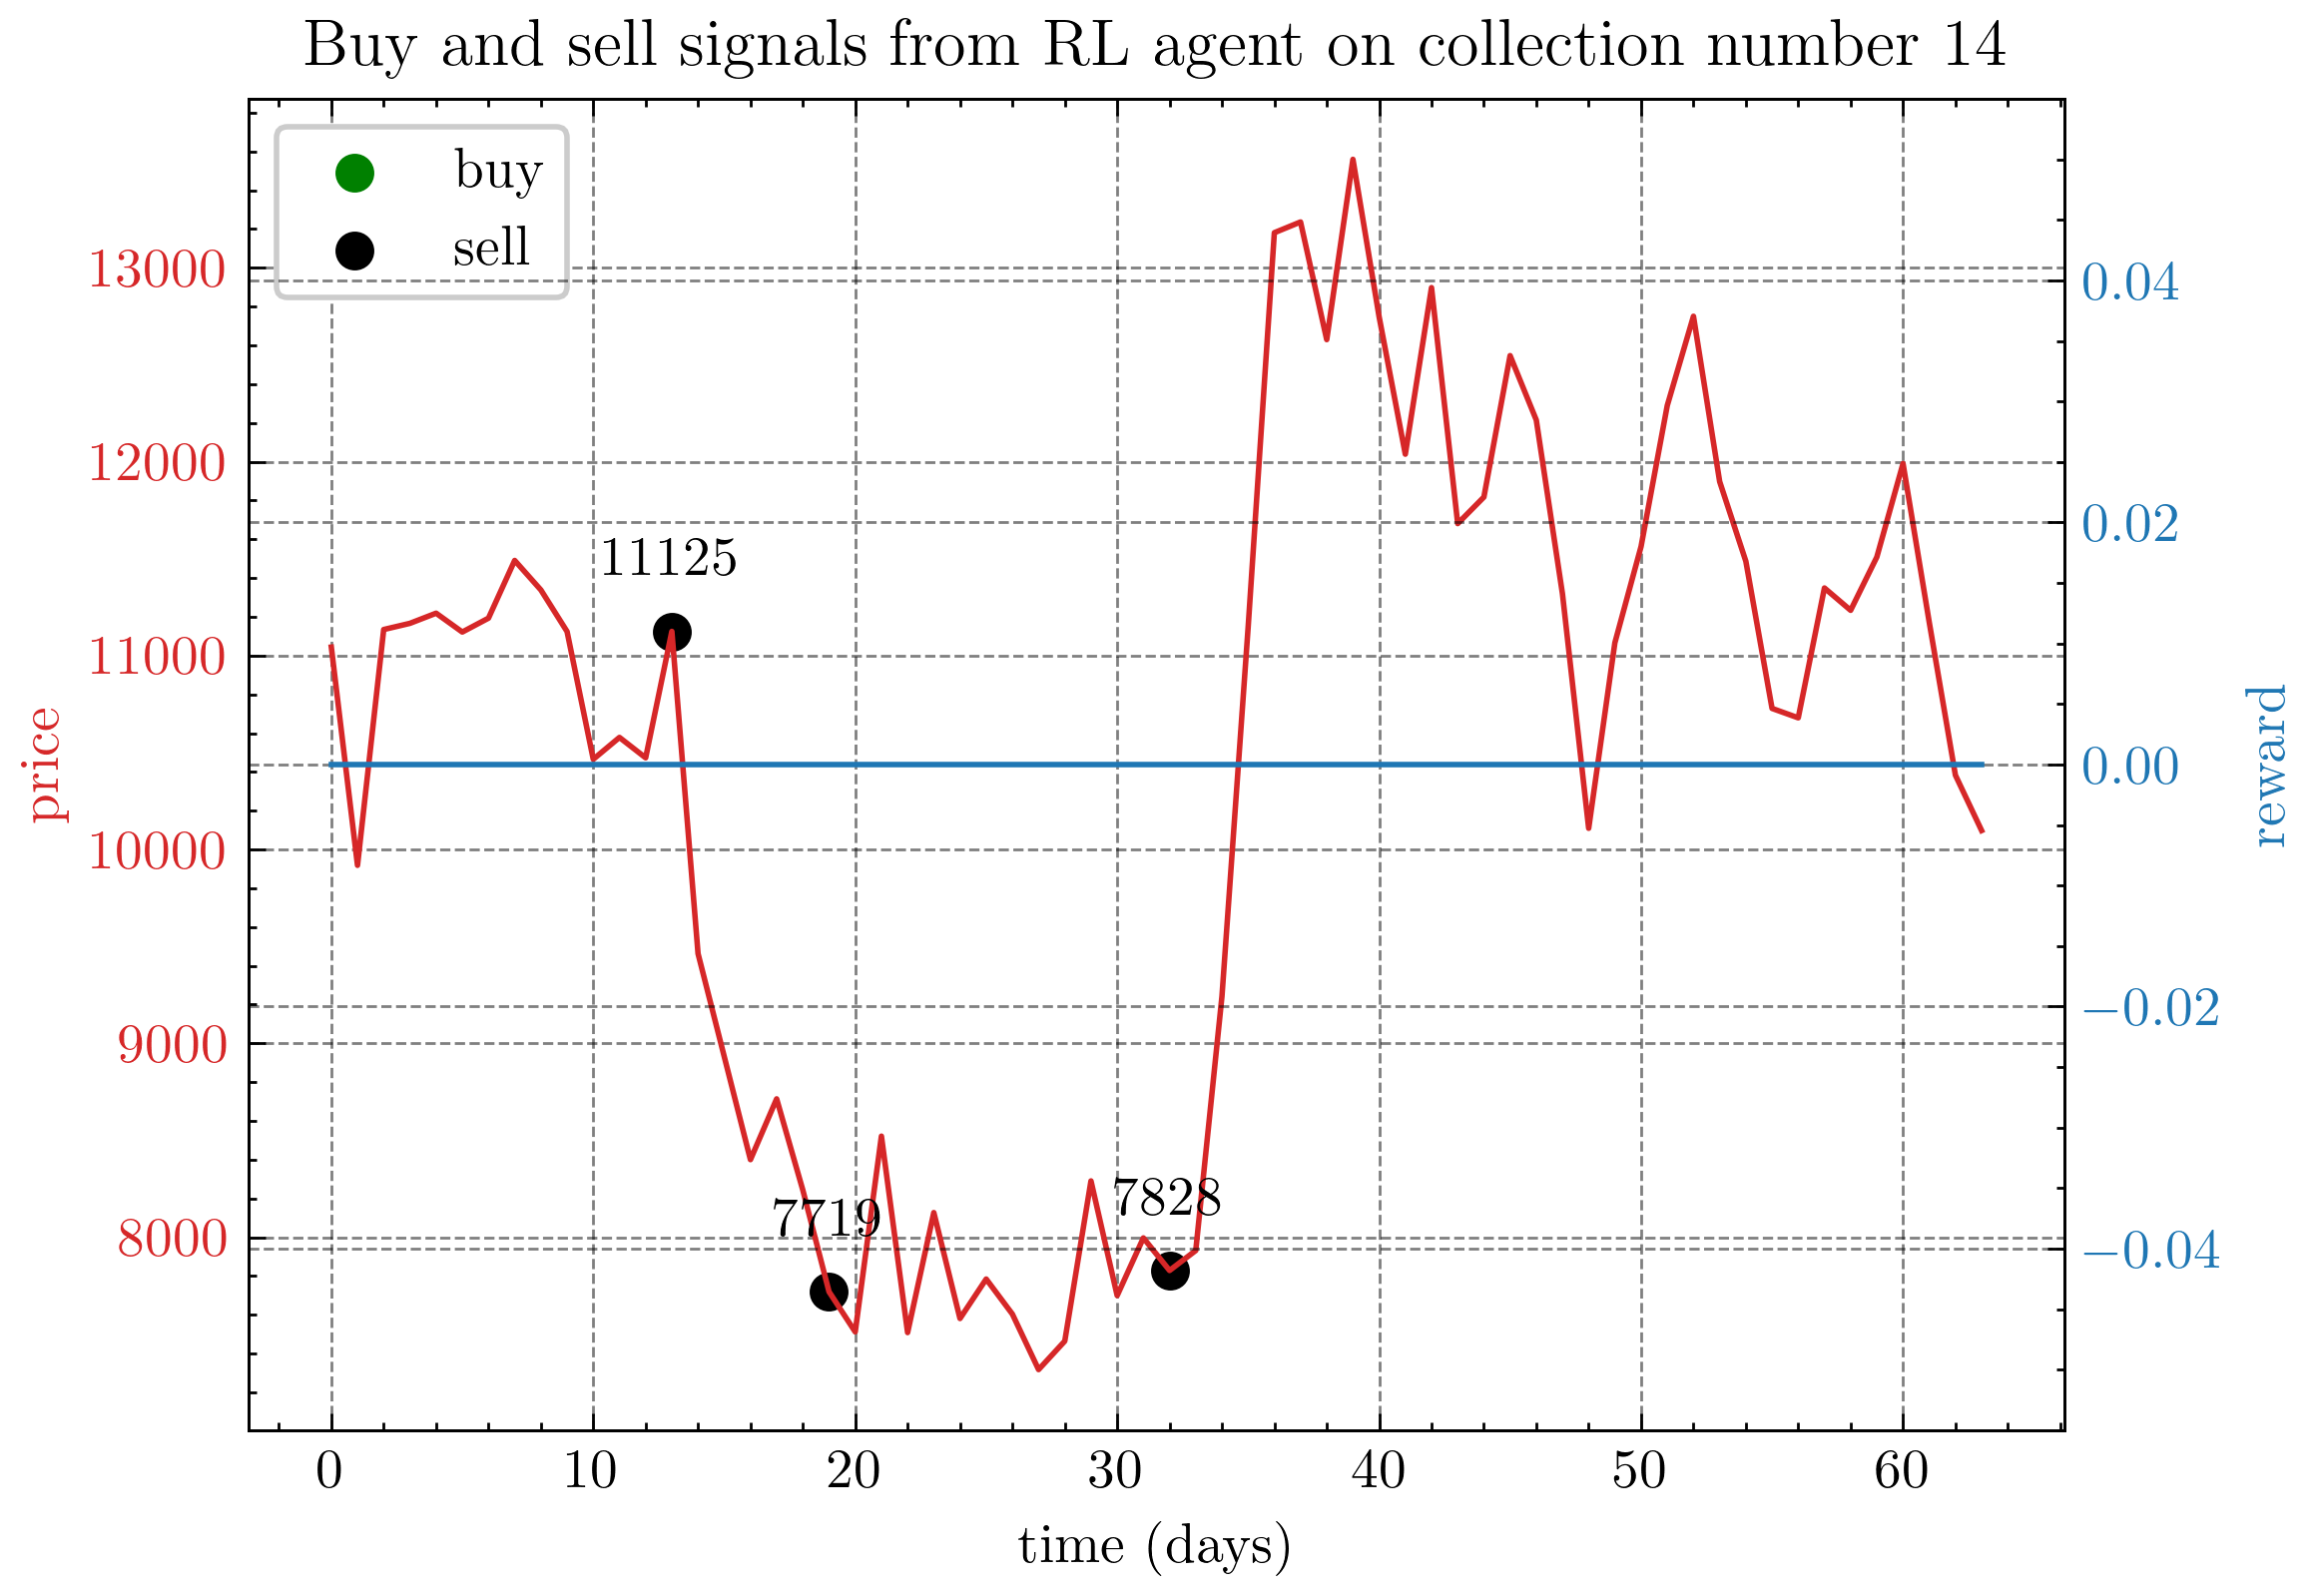

  6%|▋         | 63/1000 [00:06<01:34,  9.89it/s]


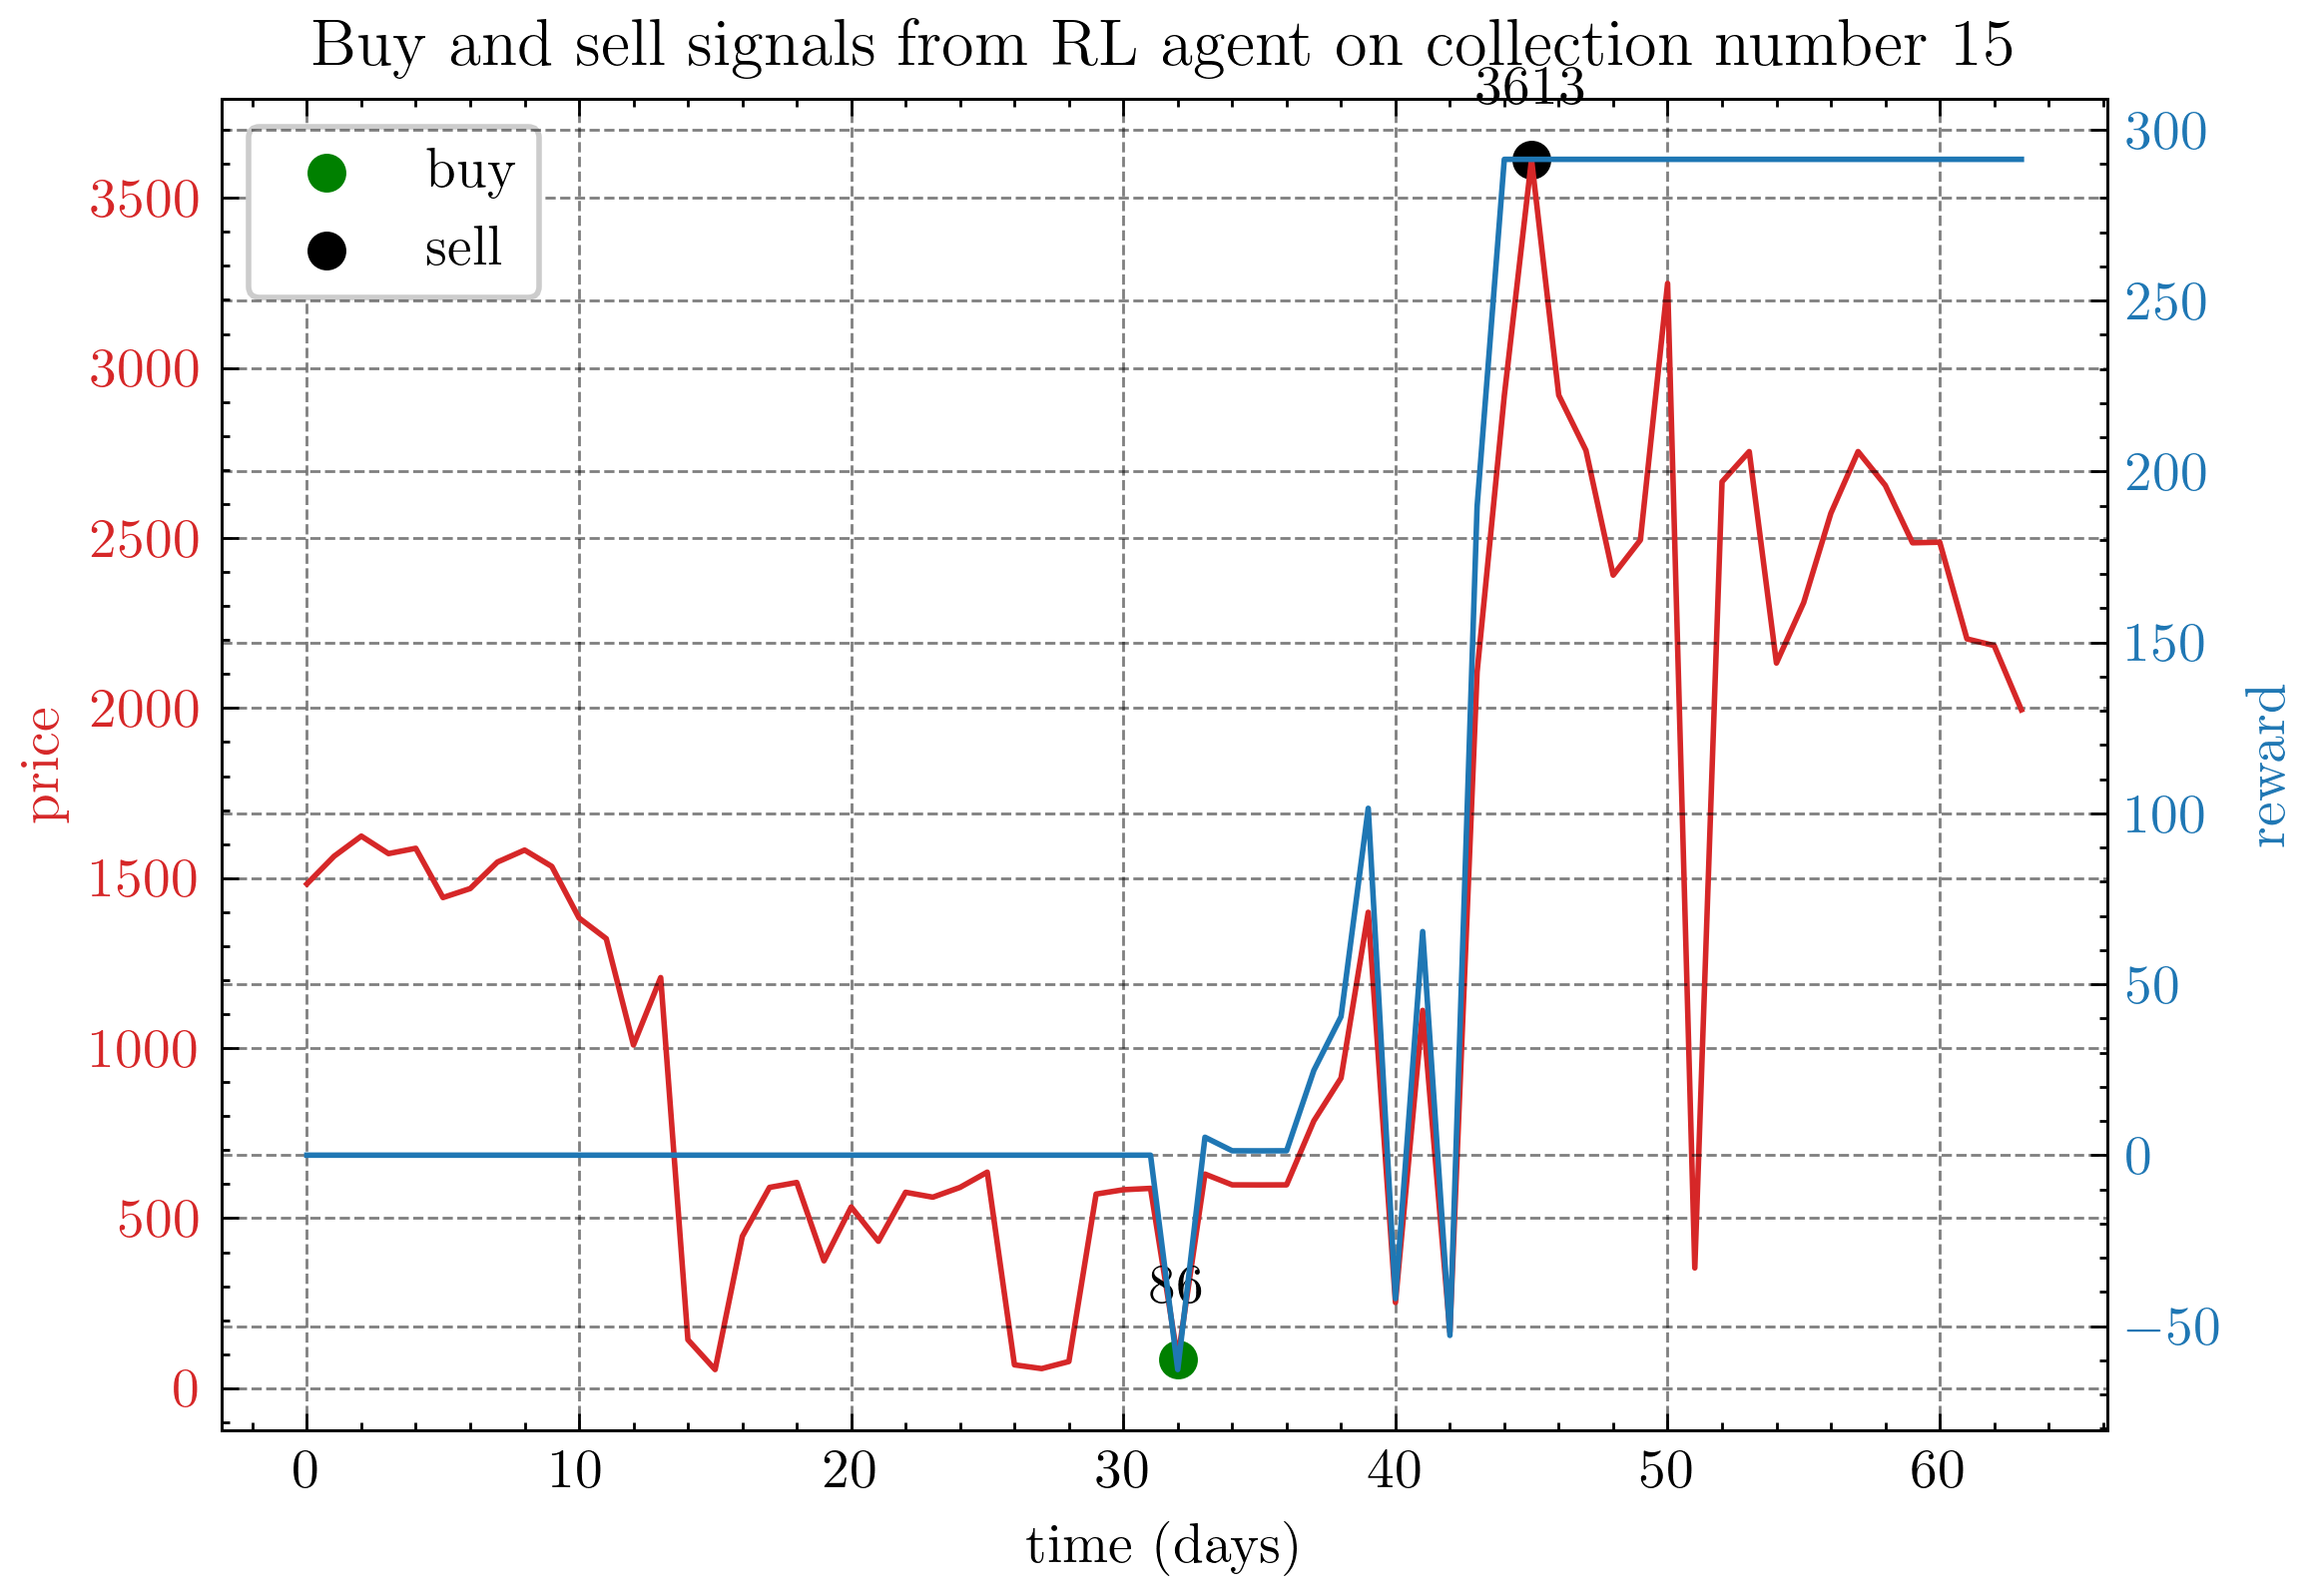

  6%|▋         | 63/1000 [00:05<01:28, 10.62it/s]


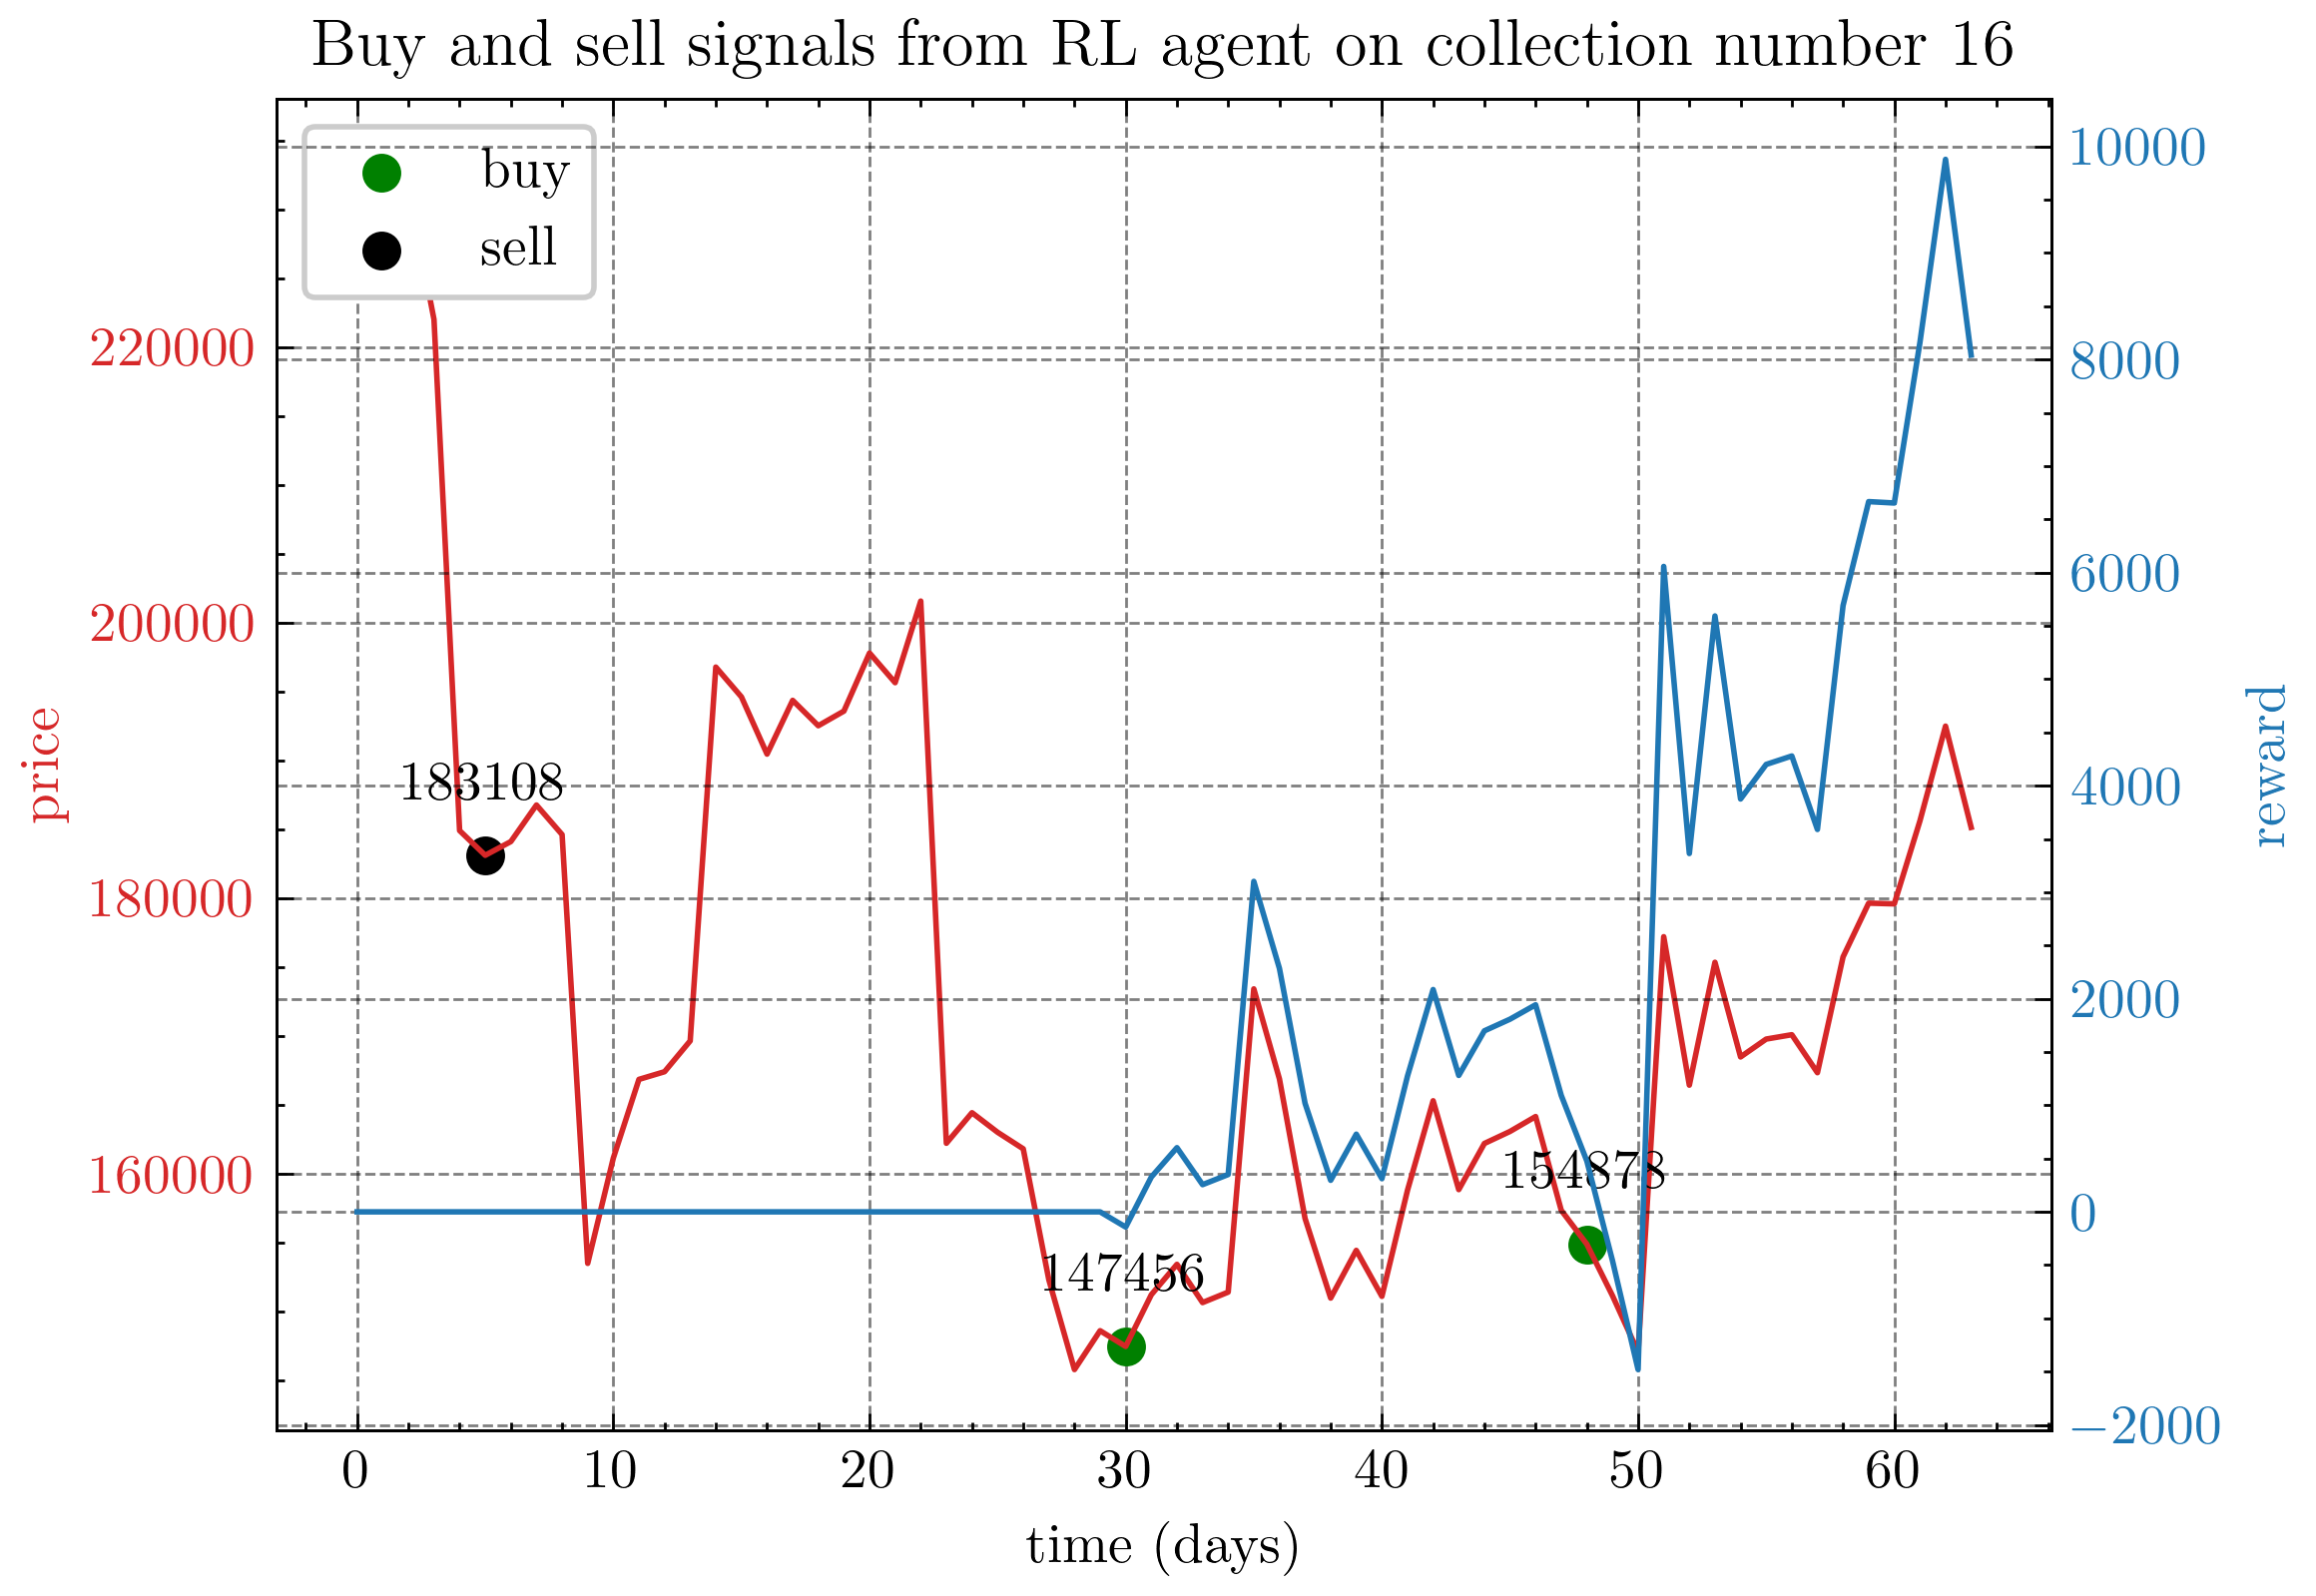

  6%|▋         | 63/1000 [00:06<01:33,  9.99it/s]


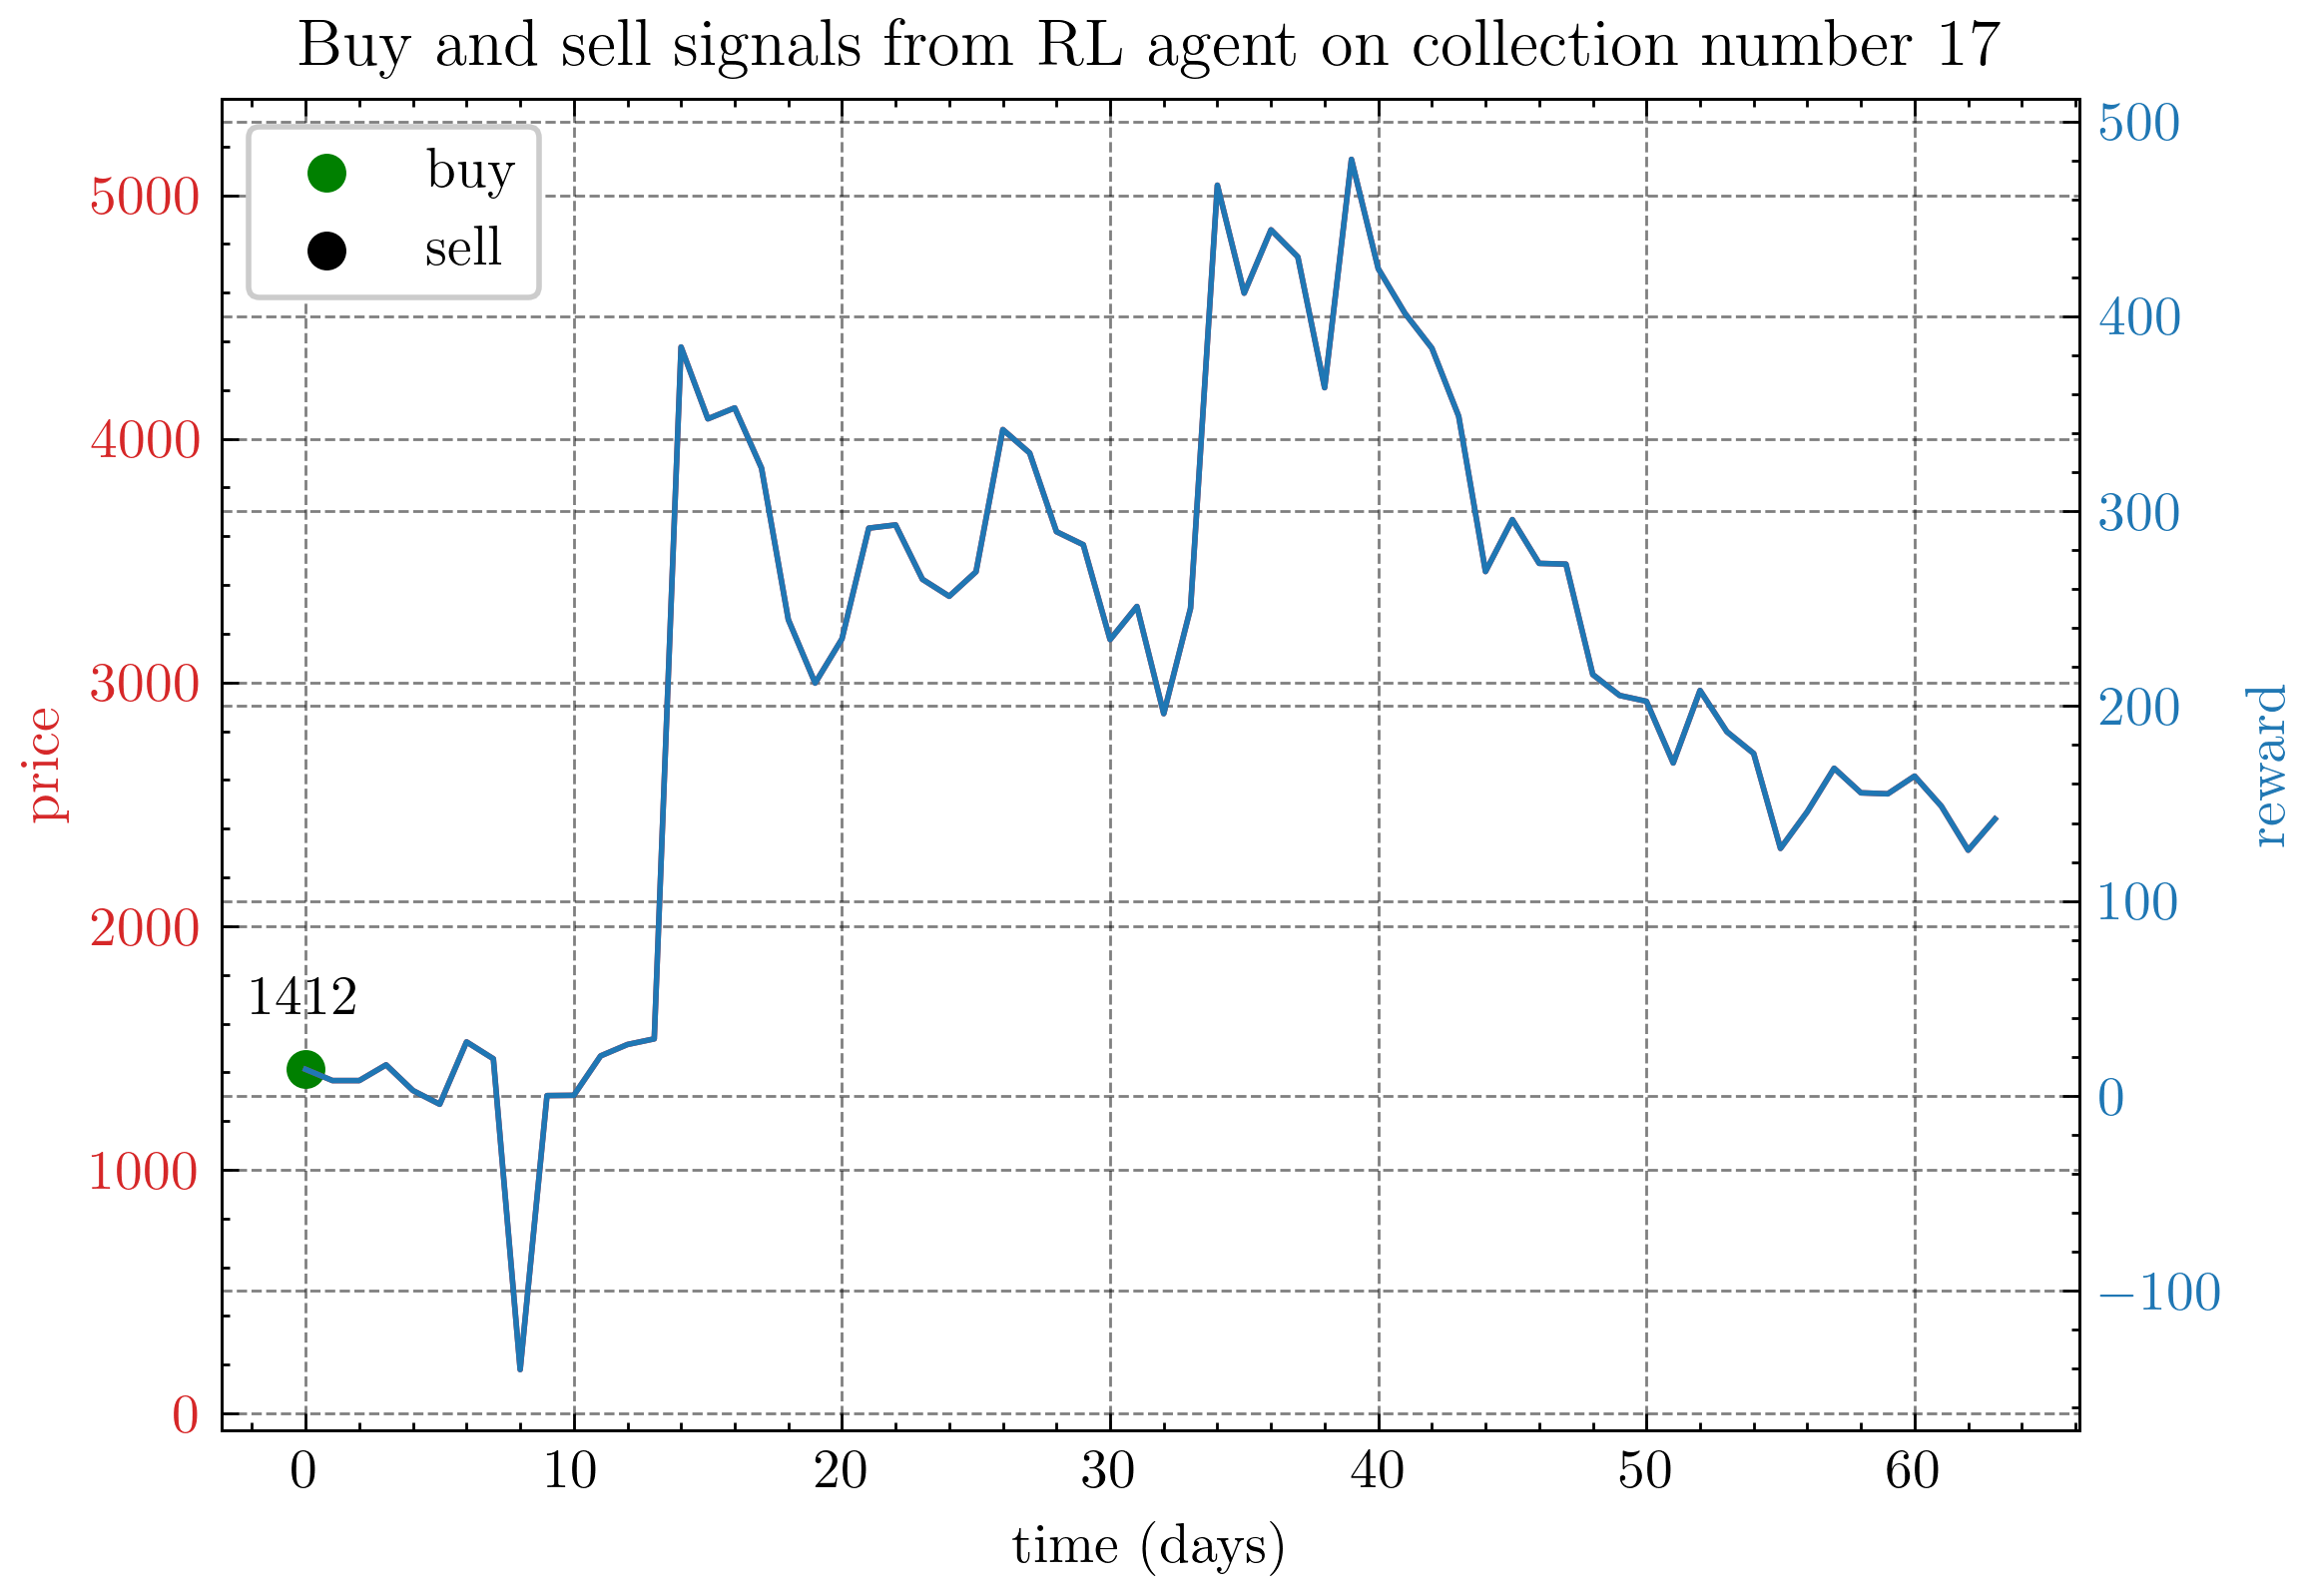

  1%|▏         | 14/1000 [00:01<01:21, 12.06it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  2%|▏         | 16/1000 [00:01<01:40,  9.75it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  6%|▋         | 63/1000 [00:06<01:34,  9.91it/s]


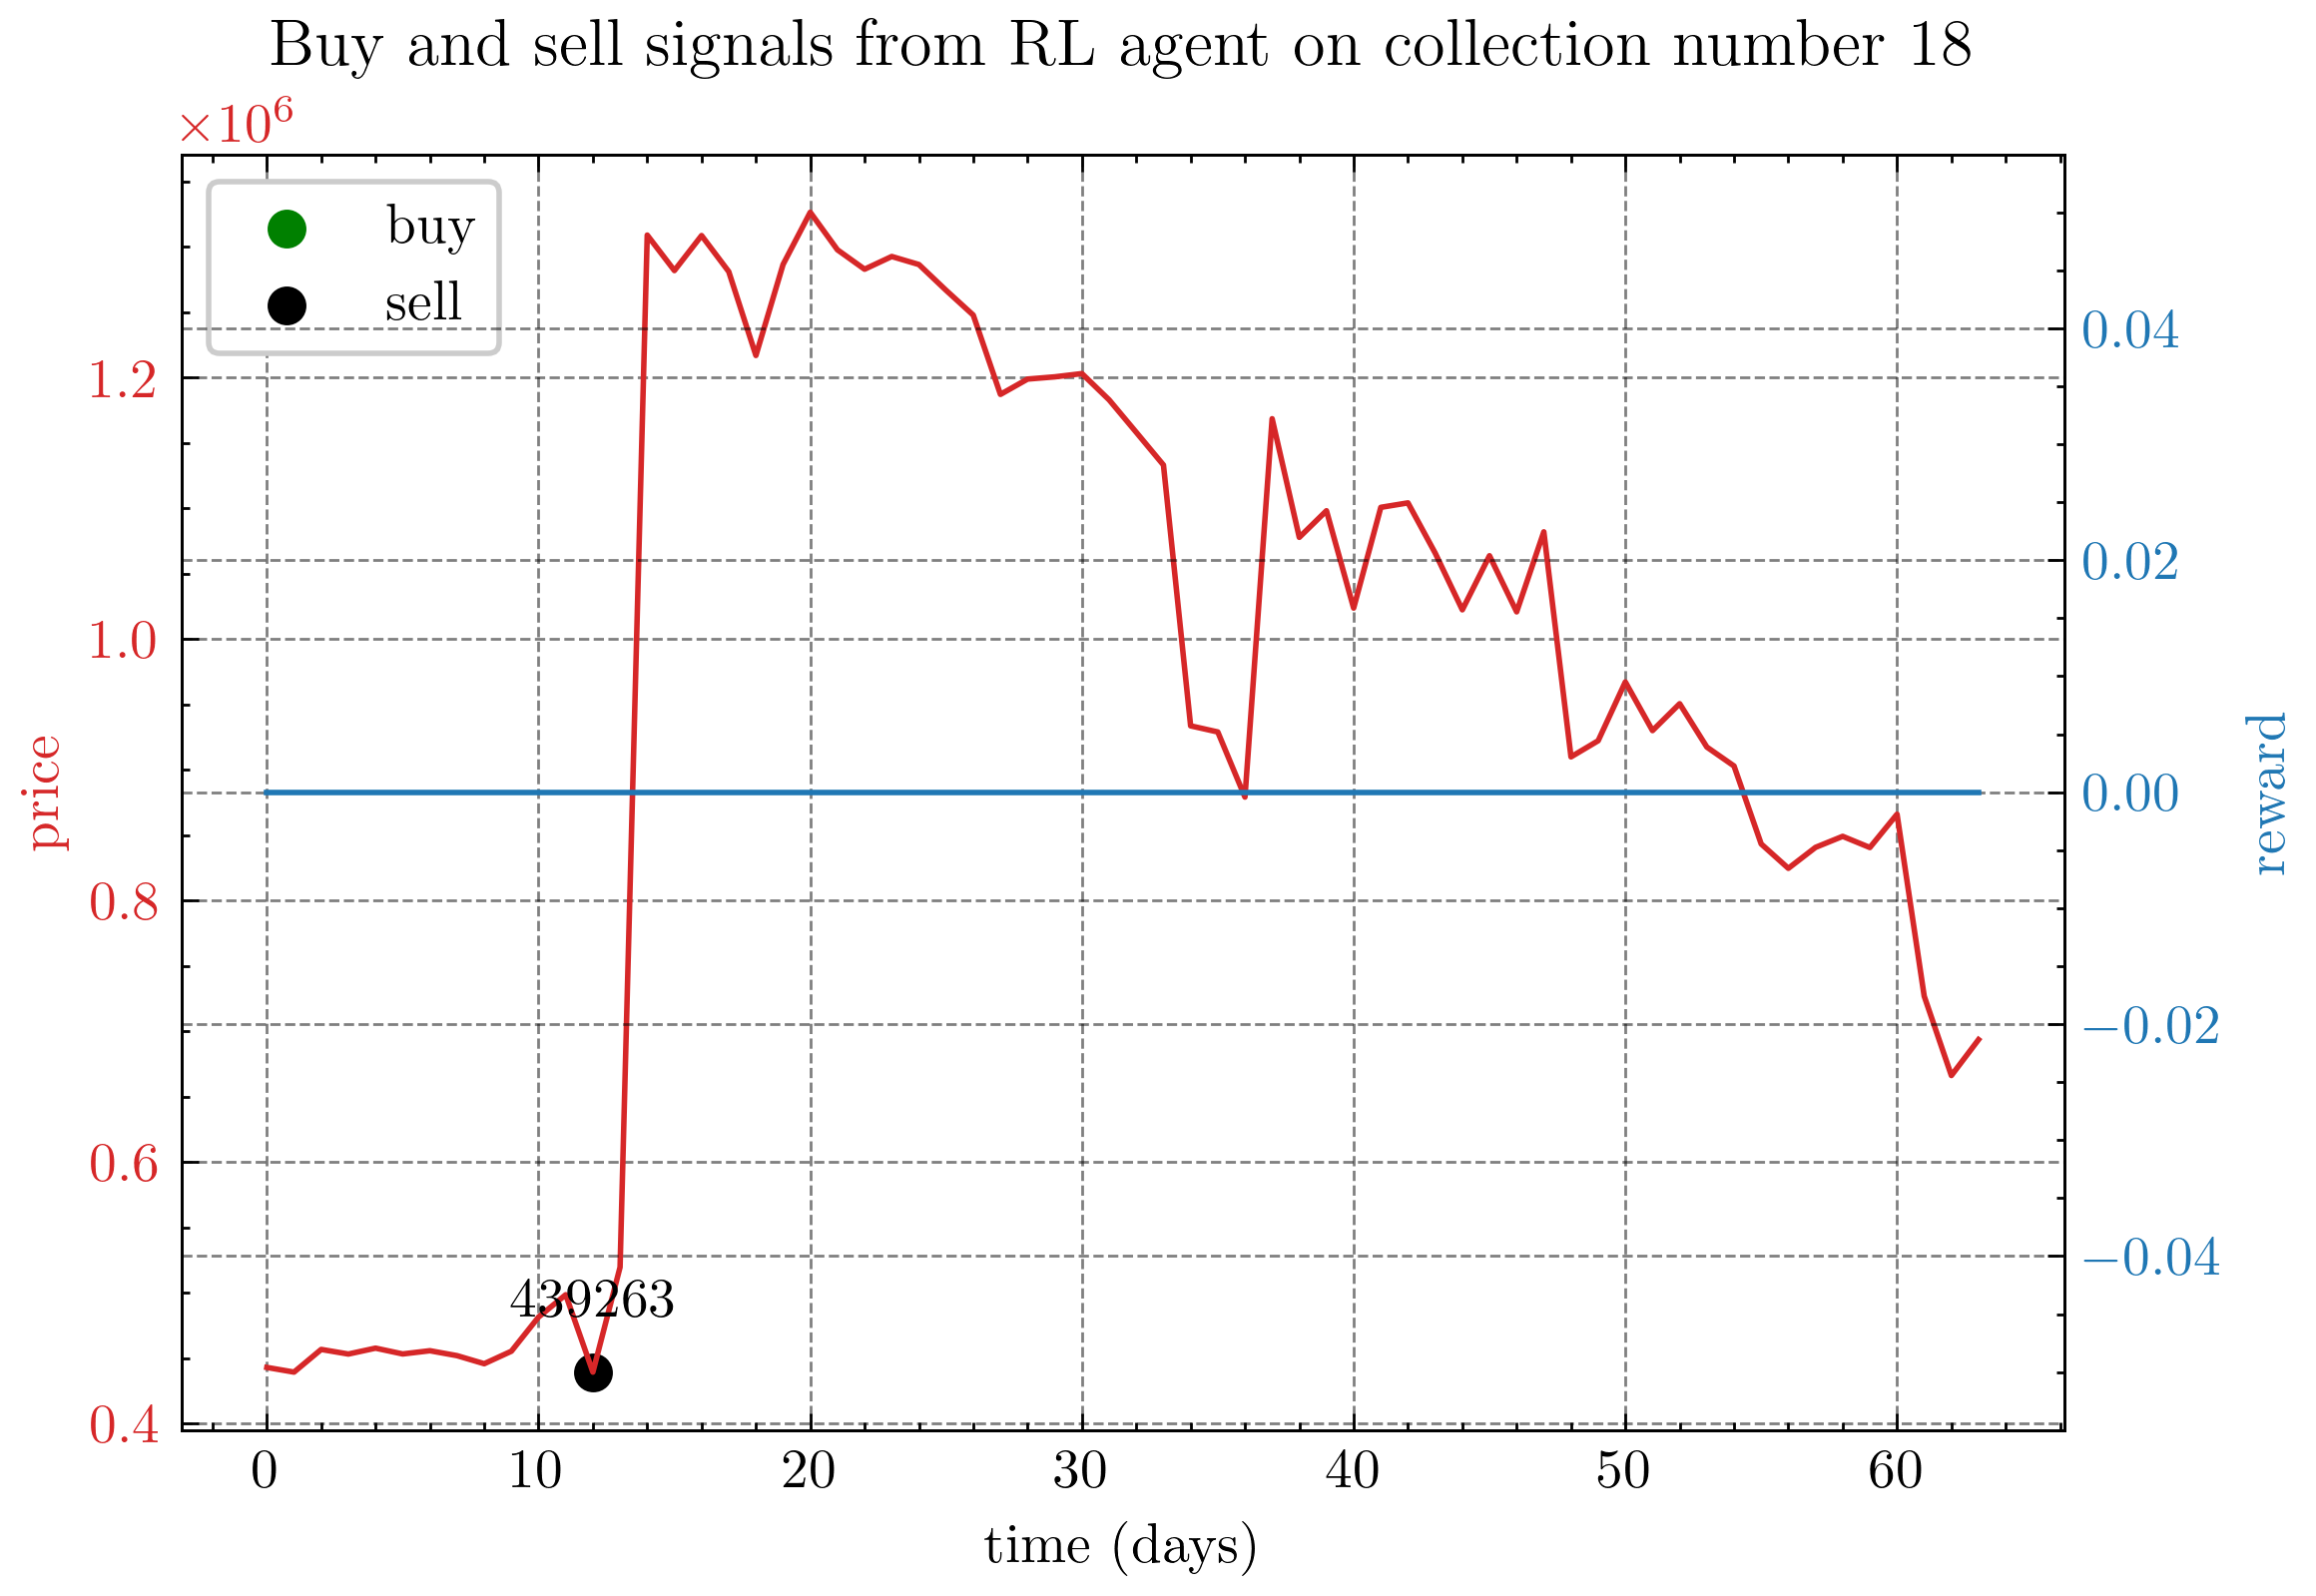

  6%|▋         | 63/1000 [00:05<01:29, 10.52it/s]


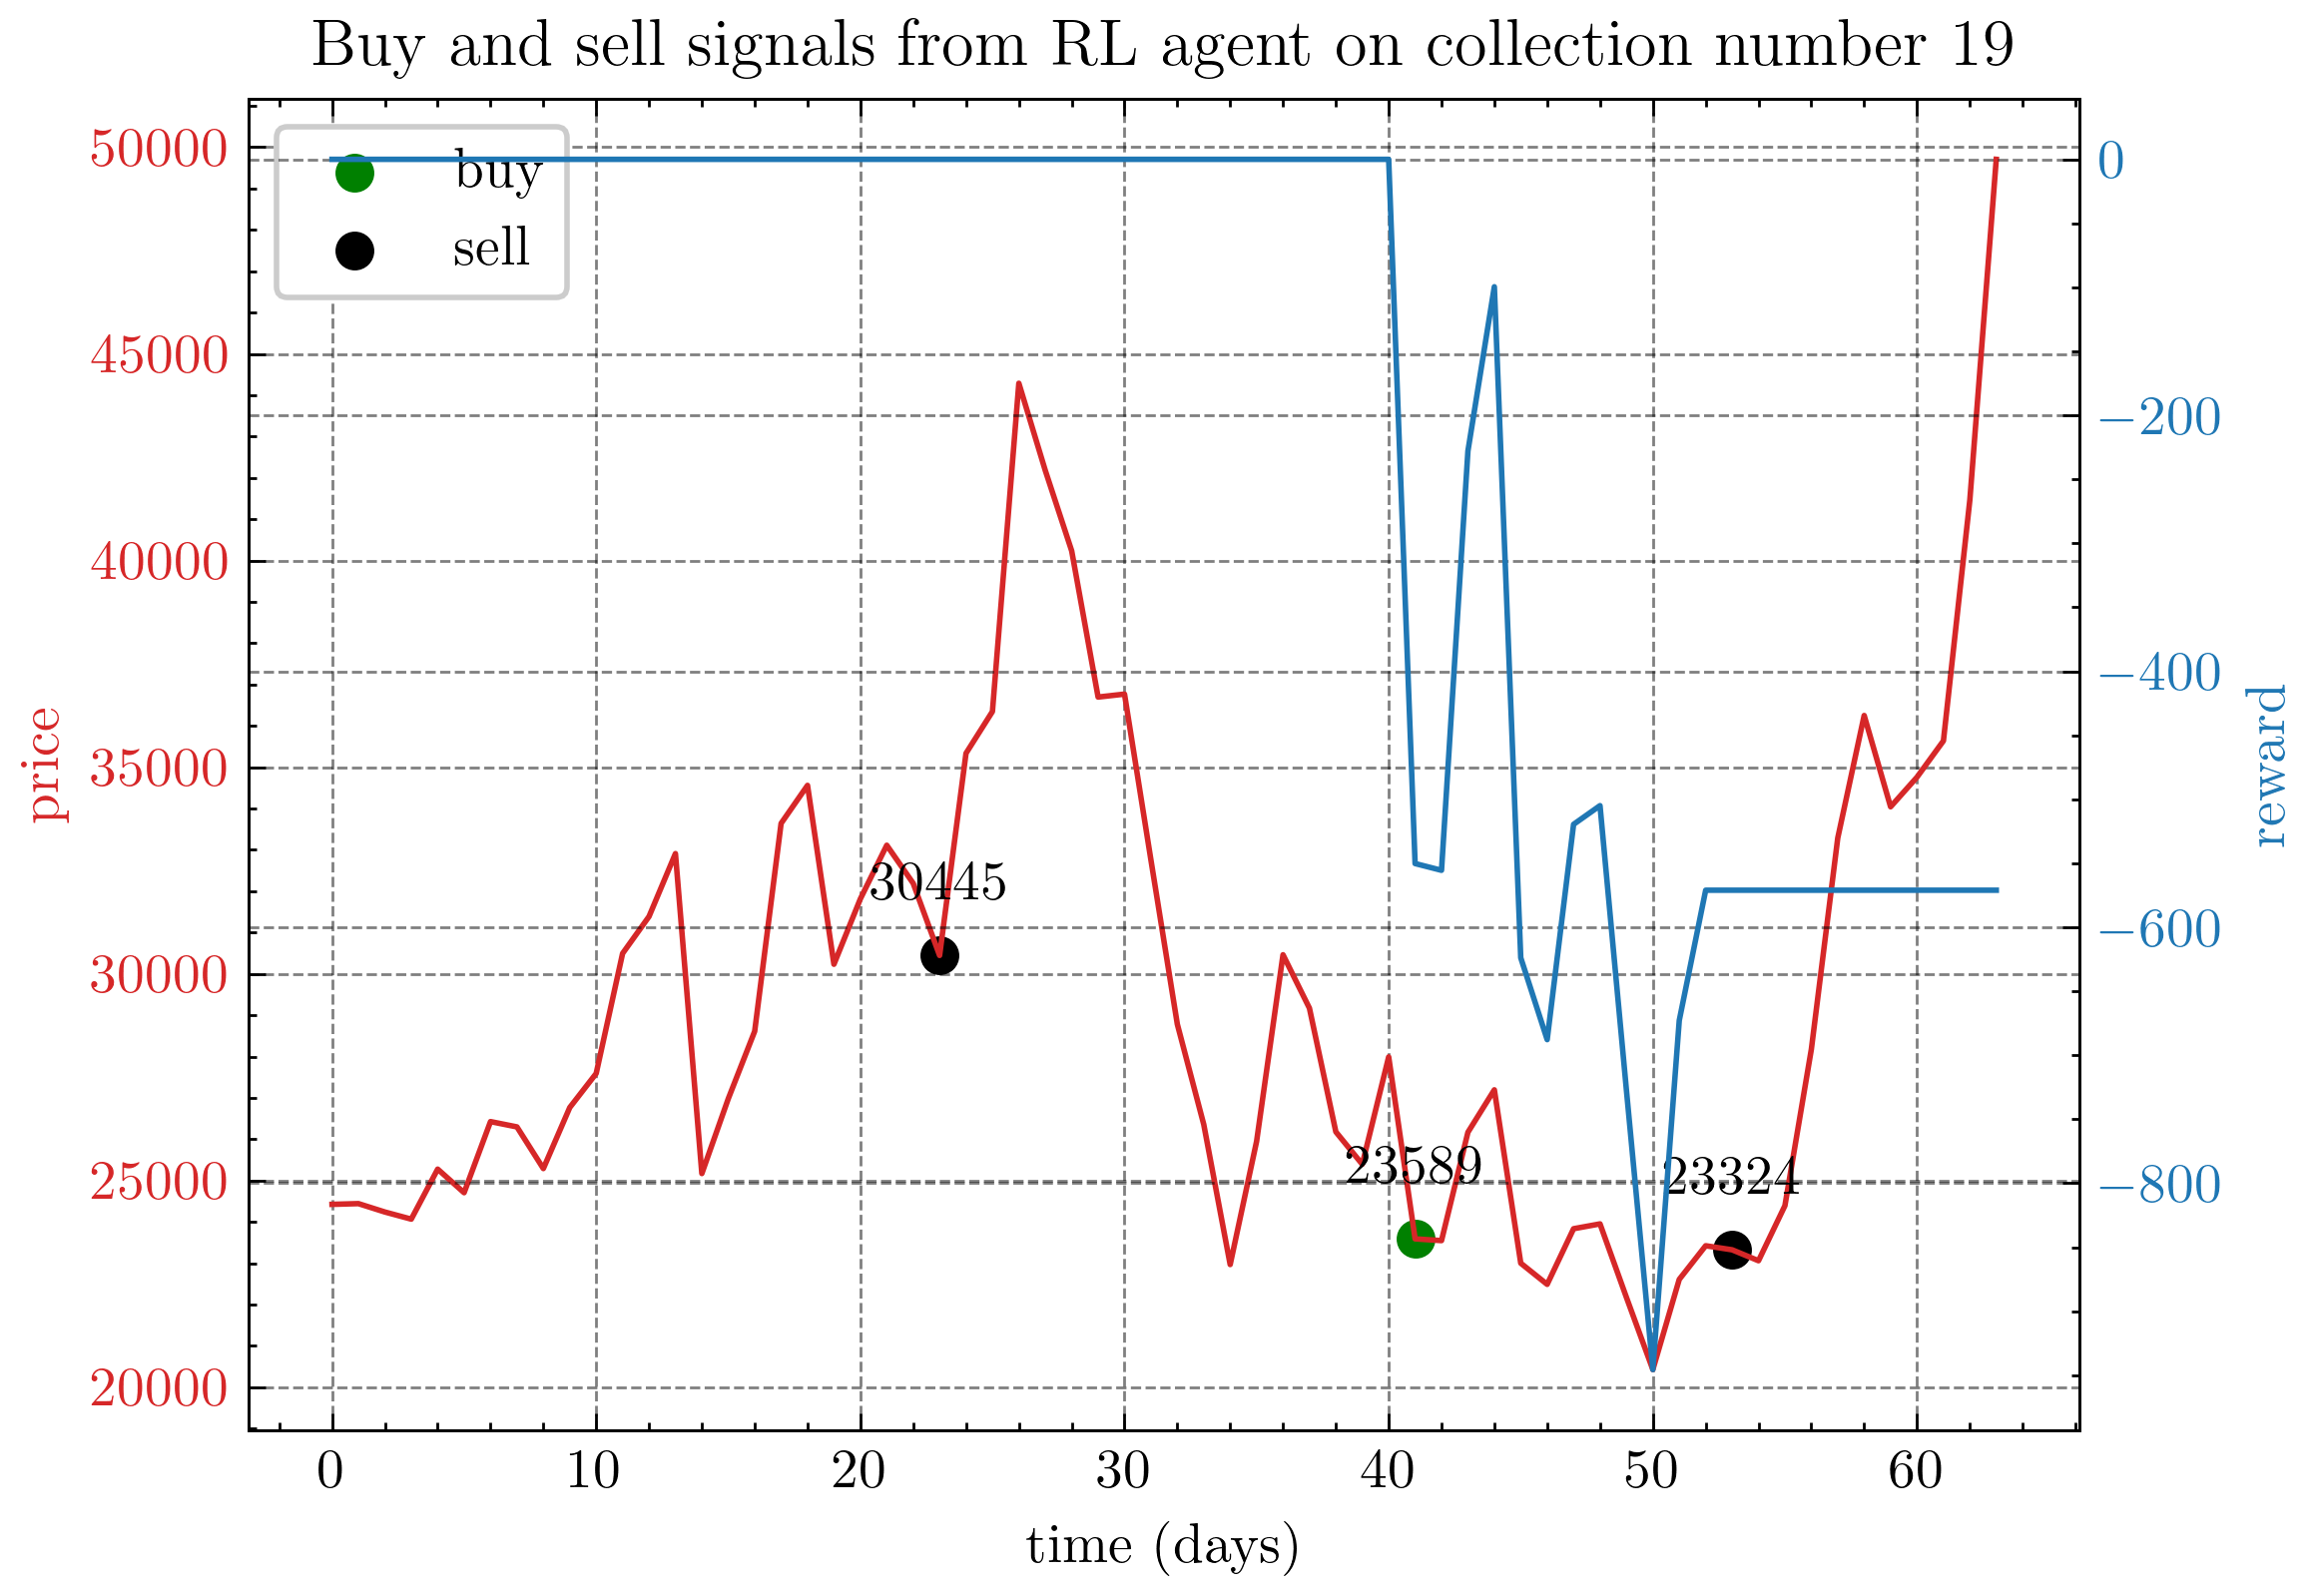

In [127]:
for i in range(7, 20):
    run_eval(i)

## Profit Distribution

In [128]:
env = Environment(train=False)
np.random.seed(42)
torch.random.manual_seed(42)
def check_final_profit():
    observation, info = env.reset()

    actions = []
    rewards = []
    infos = []

    for t in range(1000):
        state = torch.tensor(observation, dtype=torch.float32,
                             device=device).unsqueeze(0)
        with torch.no_grad():
            action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(
            action.item())
        actions.append(action)
        rewards.append(reward)
        infos.append(info)
        if terminated:
            break
    
    return rewards[-1]

rewards = []
for i in tqdm(range(64)):
    rewards.append(check_final_profit())
        

  6%|▋         | 4/64 [00:23<05:58,  5.98s/it]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 13/64 [01:21<05:23,  6.35s/it]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 22%|██▏       | 14/64 [01:27<05:13,  6.27s/it]/Users/crinstaniev/opt/anaco

In [134]:
import seaborn as sns

/var/folders/4n/658q8jnn7b70mncg8lf51wf40000gn/T/ipykernel_44666/3830067213.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rewards, bins=40, kde=True)


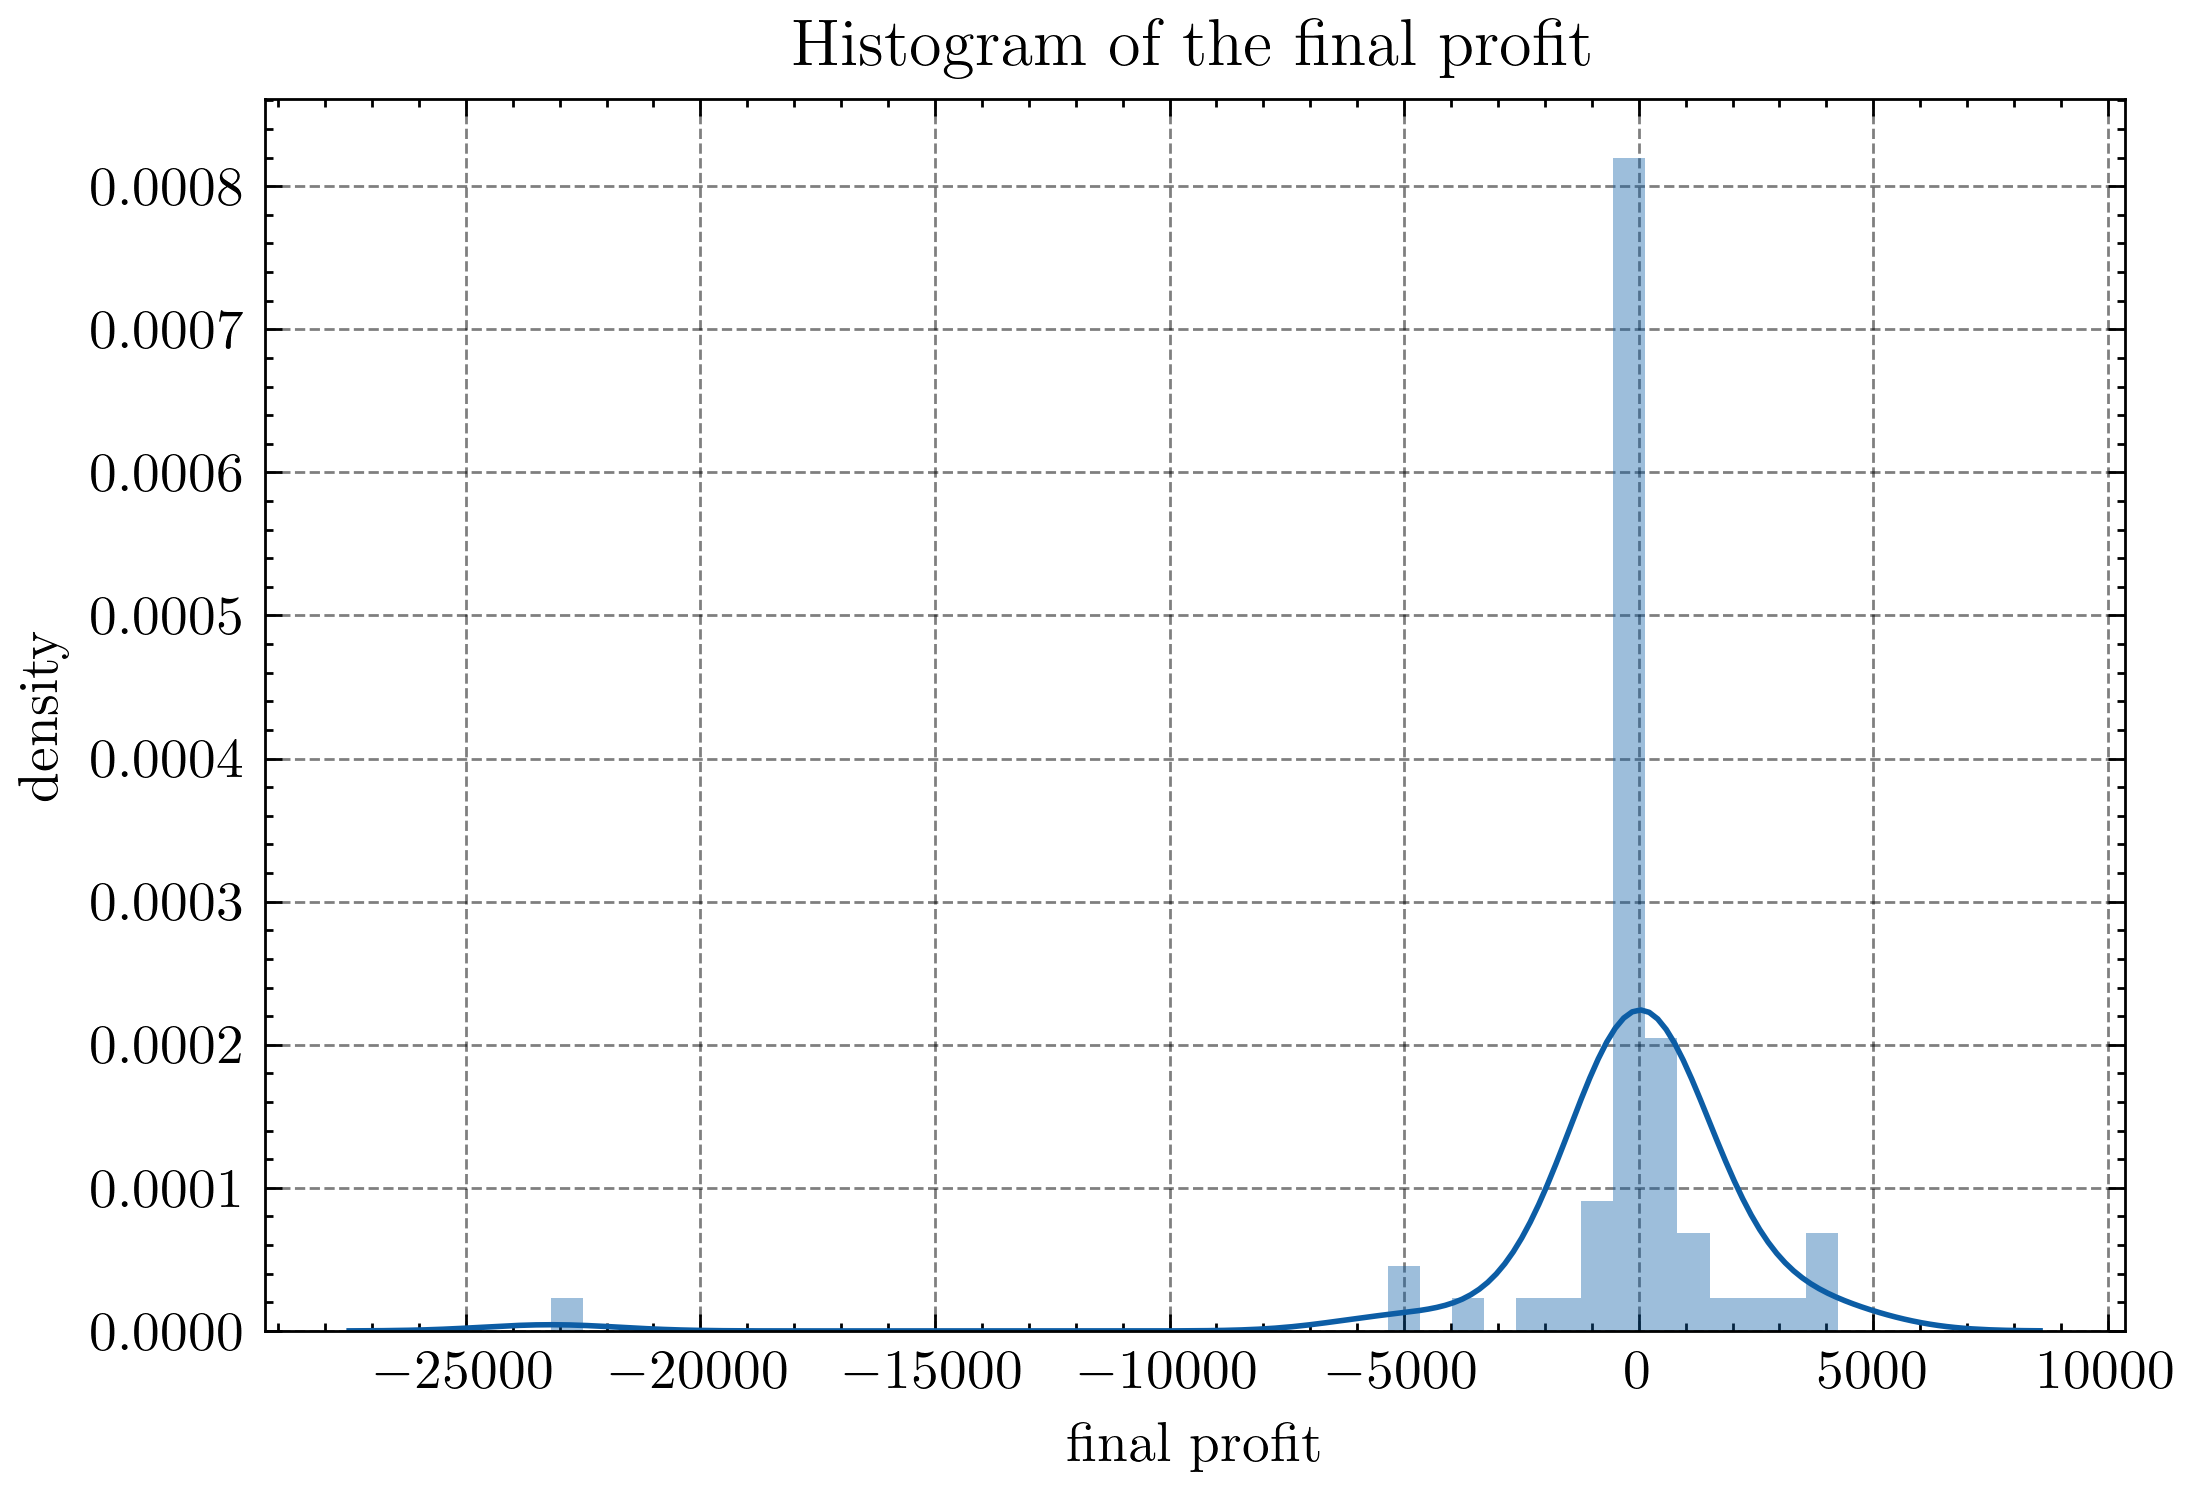

In [140]:
# histogram of the final profit, with density plot
plt.figure(figsize=(6, 4), dpi=400)

sns.distplot(rewards, bins=40, kde=True)
plt.title('Histogram of the final profit')
plt.xlabel('final profit')
plt.ylabel('density')

plt.show()


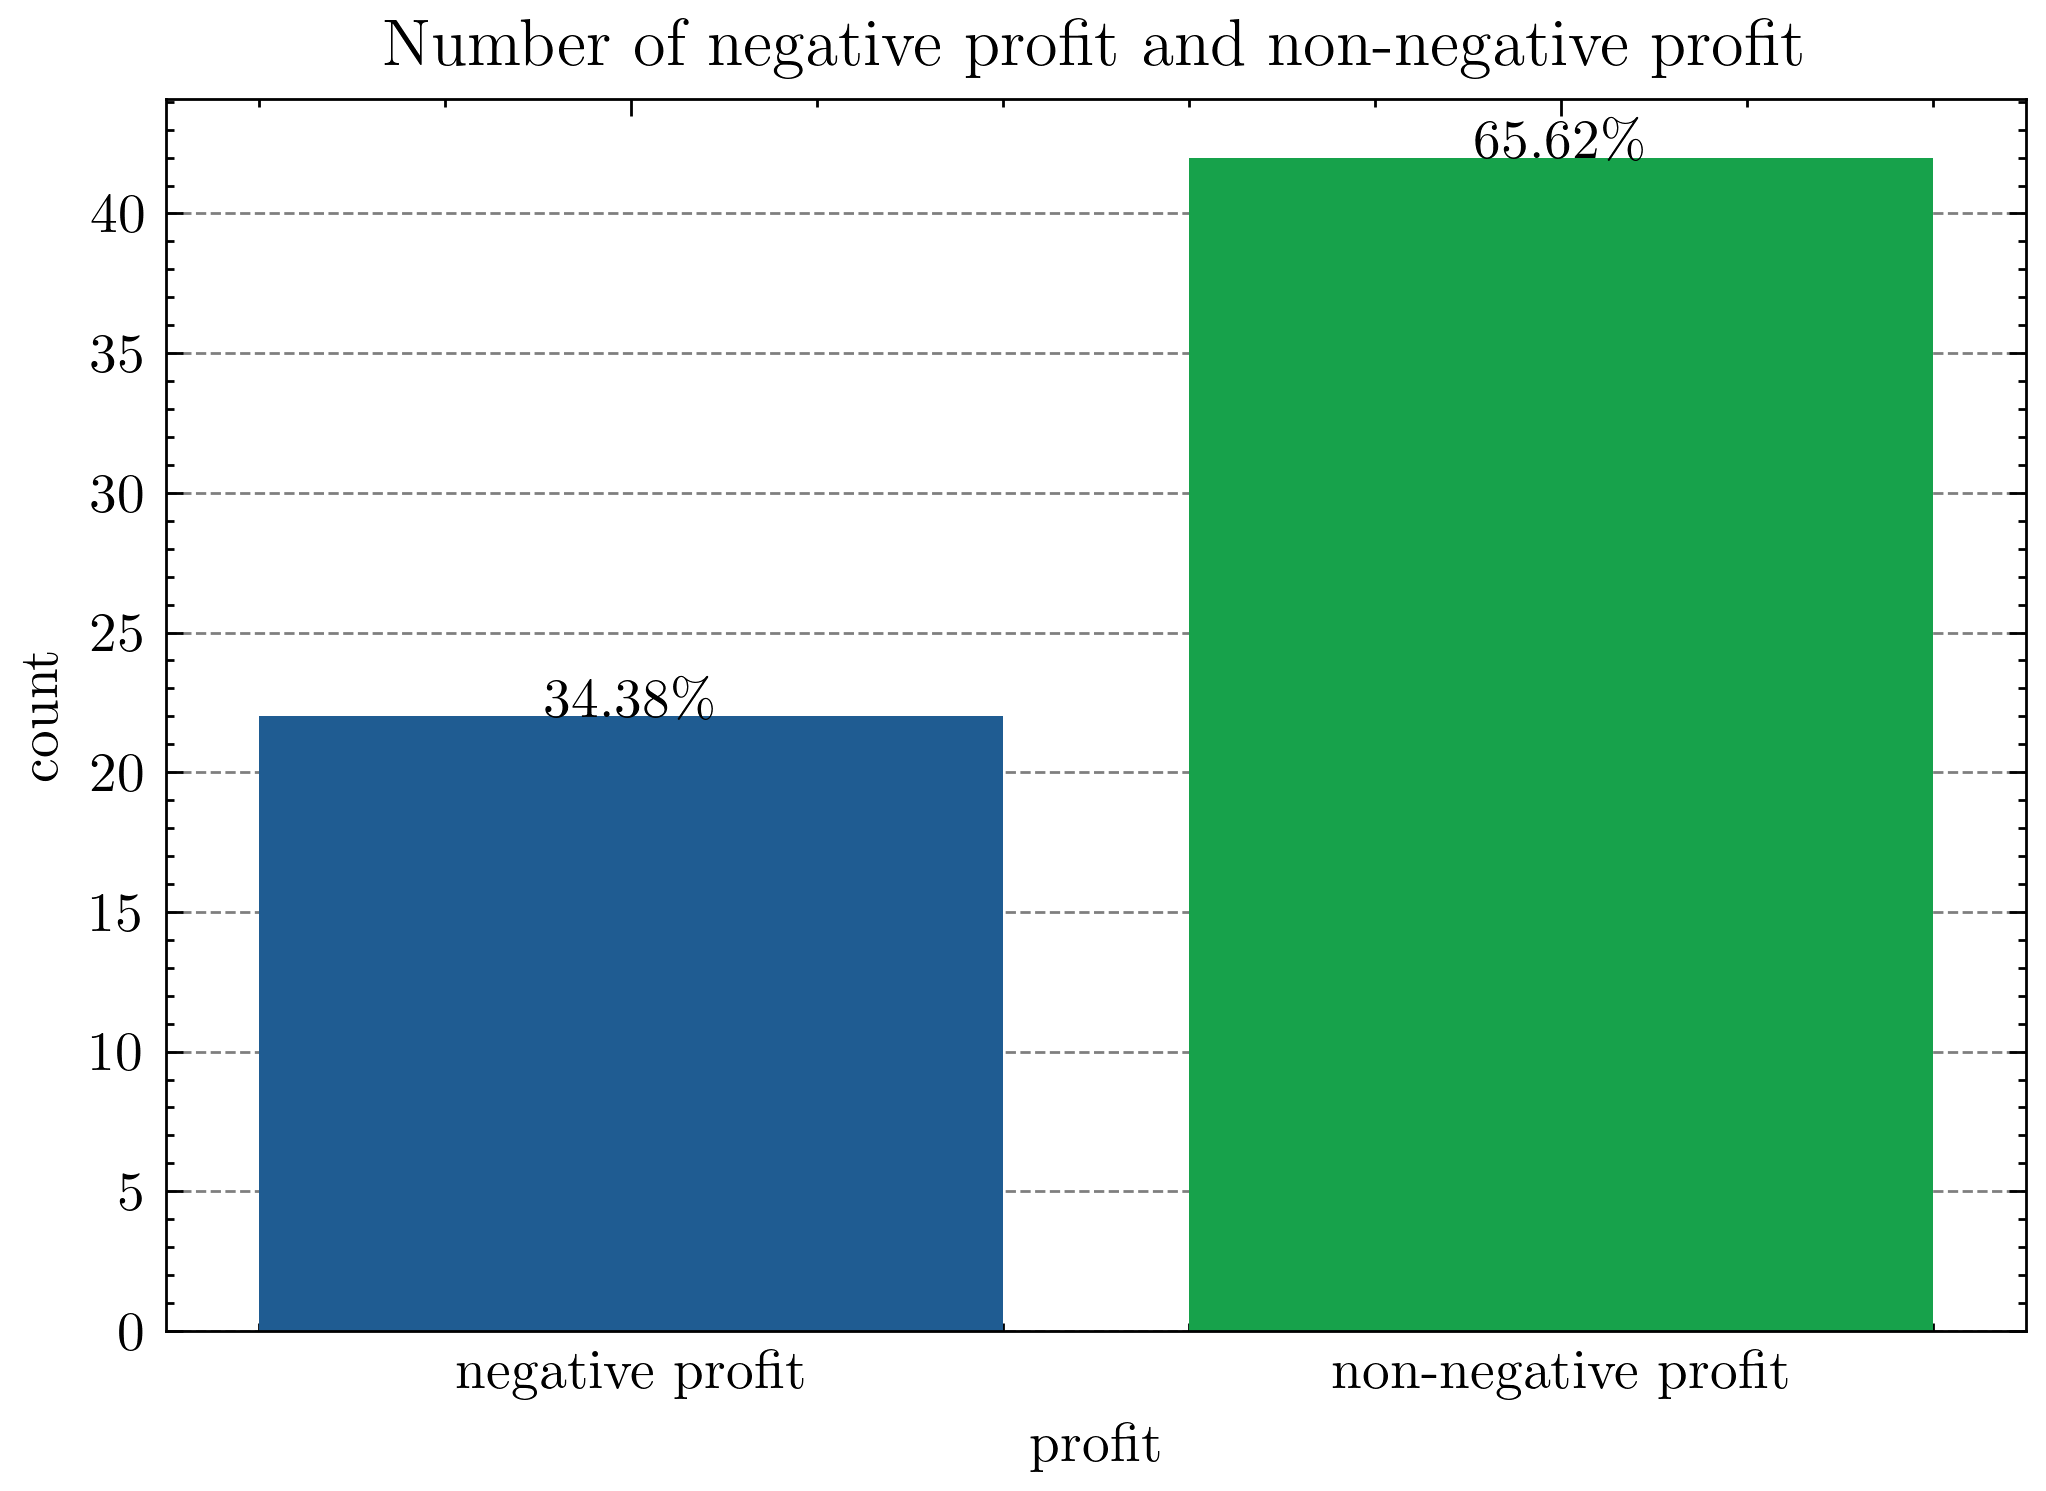

In [148]:
# using seaborn, create a pie chart of the number non-negative profit and negative profit
plt.figure(figsize=(6, 4), dpi=400)

sns.countplot(x=['negative profit' if i <
              0 else 'non-negative profit' for i in rewards])
plt.title('Number of negative profit and non-negative profit')
plt.xlabel('profit')
plt.ylabel('count')

# annotate the percentage of negative profit and non-negative profit
total = len(rewards)
negative_profit = len([i for i in rewards if i < 0])
non_negative_profit = len([i for i in rewards if i >= 0])

plt.annotate('{:.2f}\%'.format(
    negative_profit/total*100), (0, negative_profit), ha='center')
plt.annotate('{:.2f}\%'.format(
    non_negative_profit/total*100), (1, non_negative_profit), ha='center')

plt.show()


## Compare: Buy and Hold vs. Strategy

In [150]:
env = Environment(train=False)
np.random.seed(42)
torch.random.manual_seed(42)
def check_final_profit():
    observation, info = env.reset()

    actions = []
    rewards = []
    infos = []

    for t in range(1000):
        observation, reward, terminated, truncated, info = env.step(0)
        actions.append(action)
        rewards.append(reward)
        infos.append(info)
        if terminated:
            break
    
    return rewards[-1]

rewards = []
for i in tqdm(range(64)):
    rewards.append(check_final_profit())
        

  6%|▋         | 4/64 [00:01<00:27,  2.19it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 20%|██        | 13/64 [00:05<00:22,  2.28it/s]/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/crinstaniev/opt/anaconda3/envs/torch/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 22%|██▏       | 14/64 [00:06<00:21,  2.30it/s]/Users/crinstaniev/opt/anaco

/var/folders/4n/658q8jnn7b70mncg8lf51wf40000gn/T/ipykernel_44666/1041232865.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rewards, bins=40, kde=True)


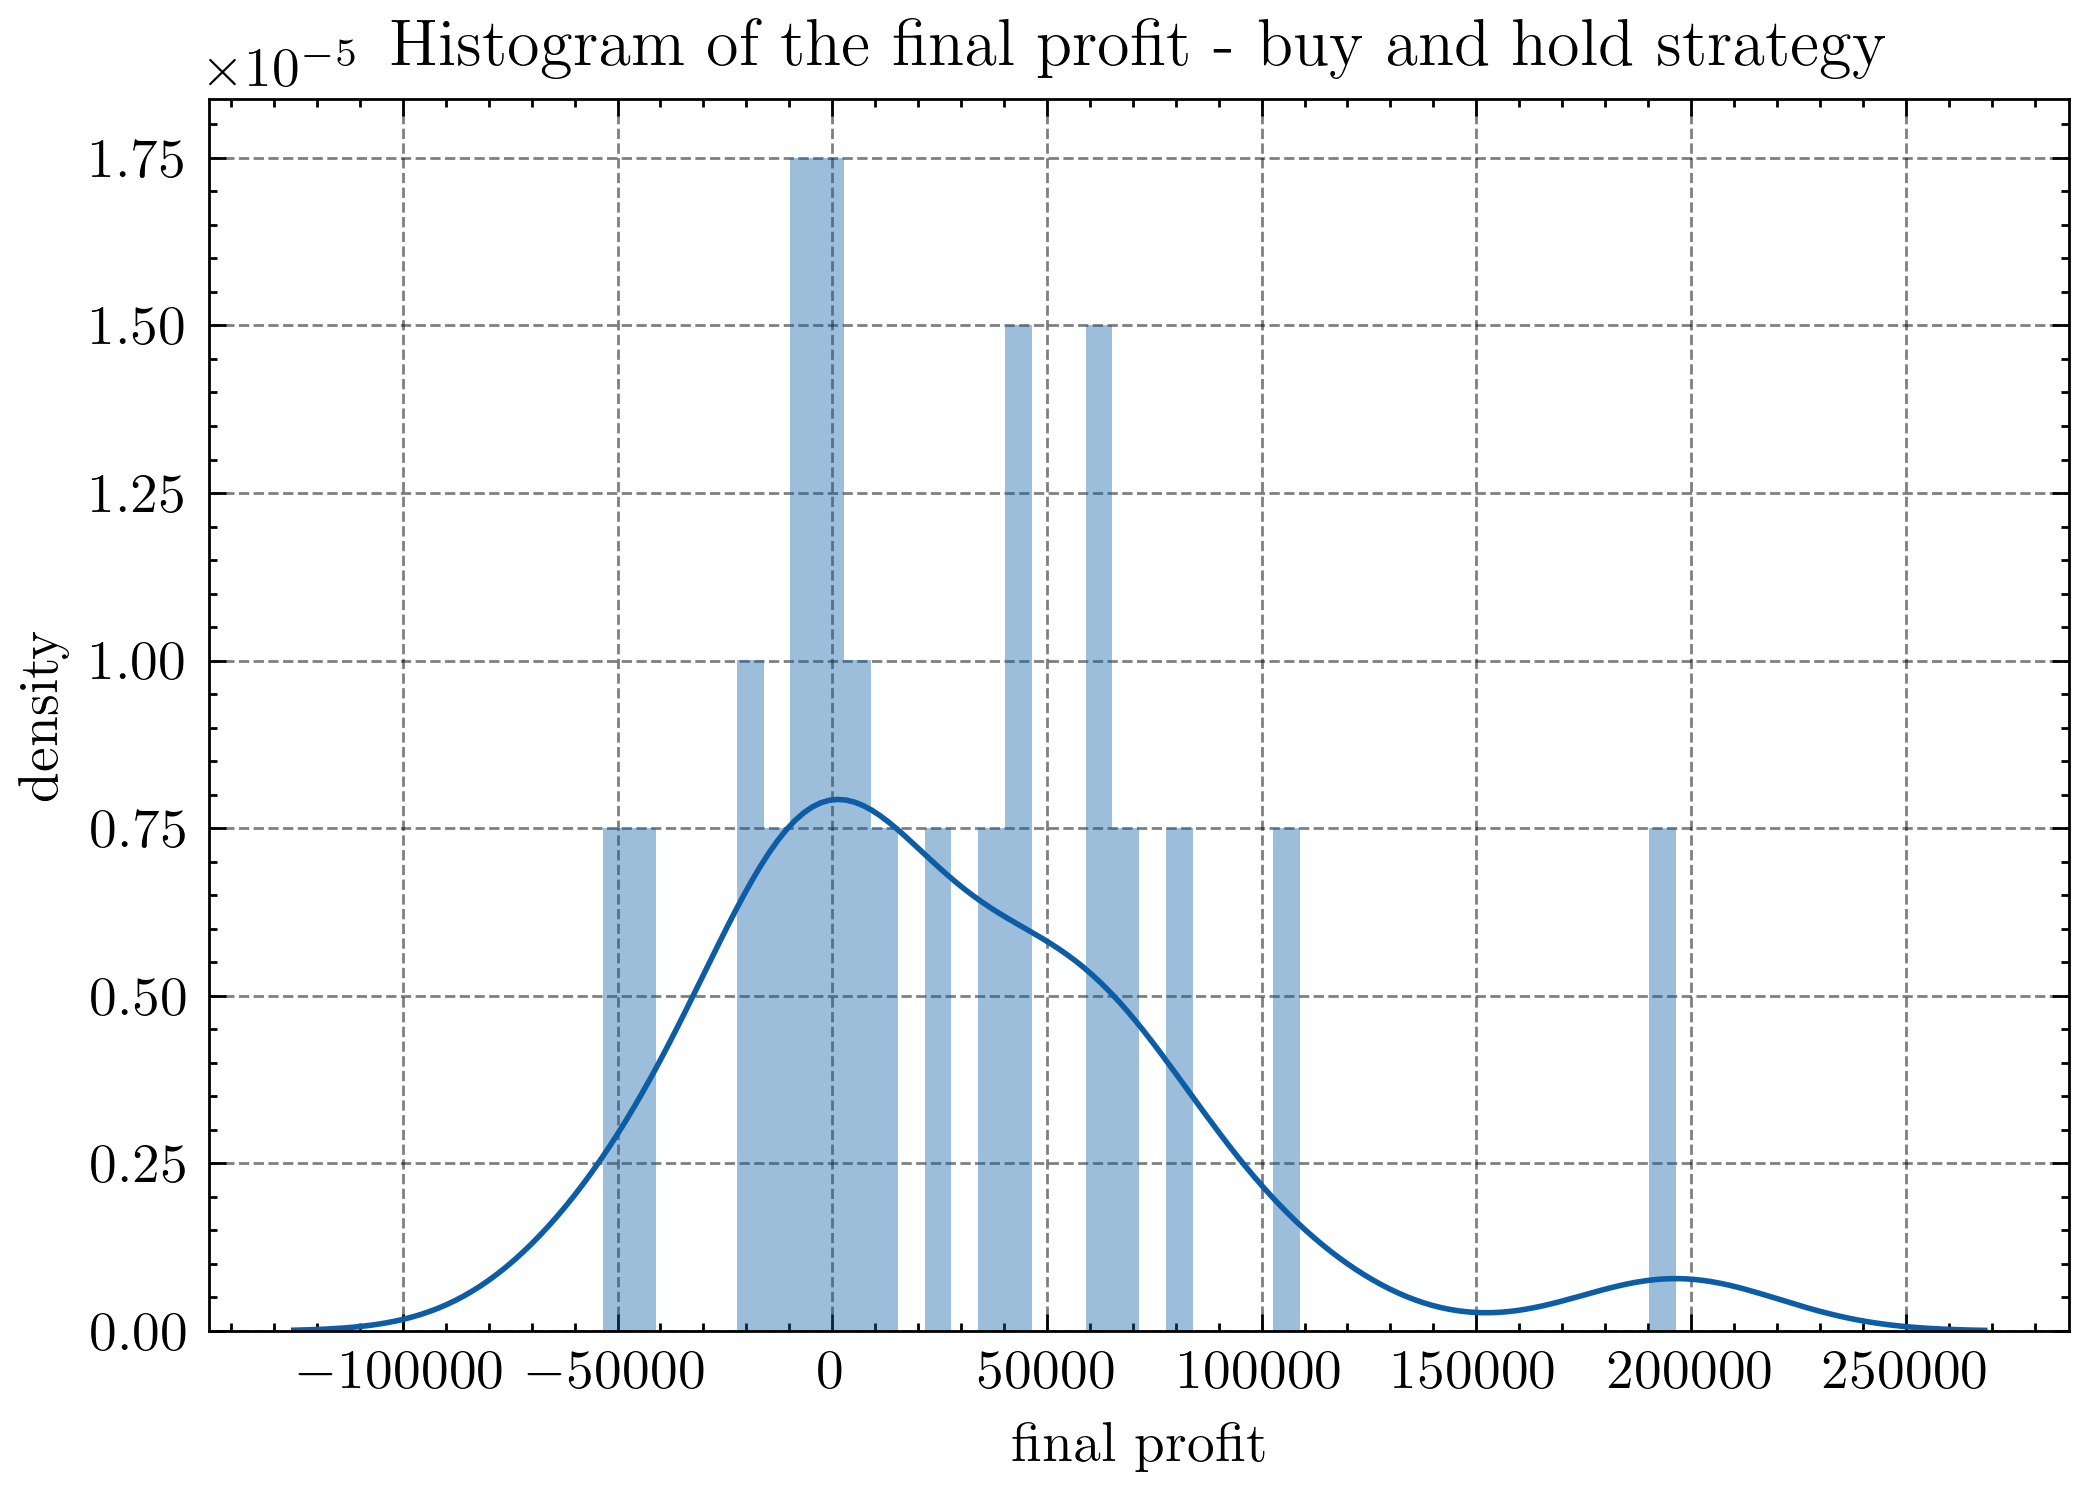

In [152]:
# histogram of the final profit, with density plot
plt.figure(figsize=(6, 4), dpi=400)

sns.distplot(rewards, bins=40, kde=True)
plt.title('Histogram of the final profit - buy and hold strategy')
plt.xlabel('final profit')
plt.ylabel('density')

plt.show()


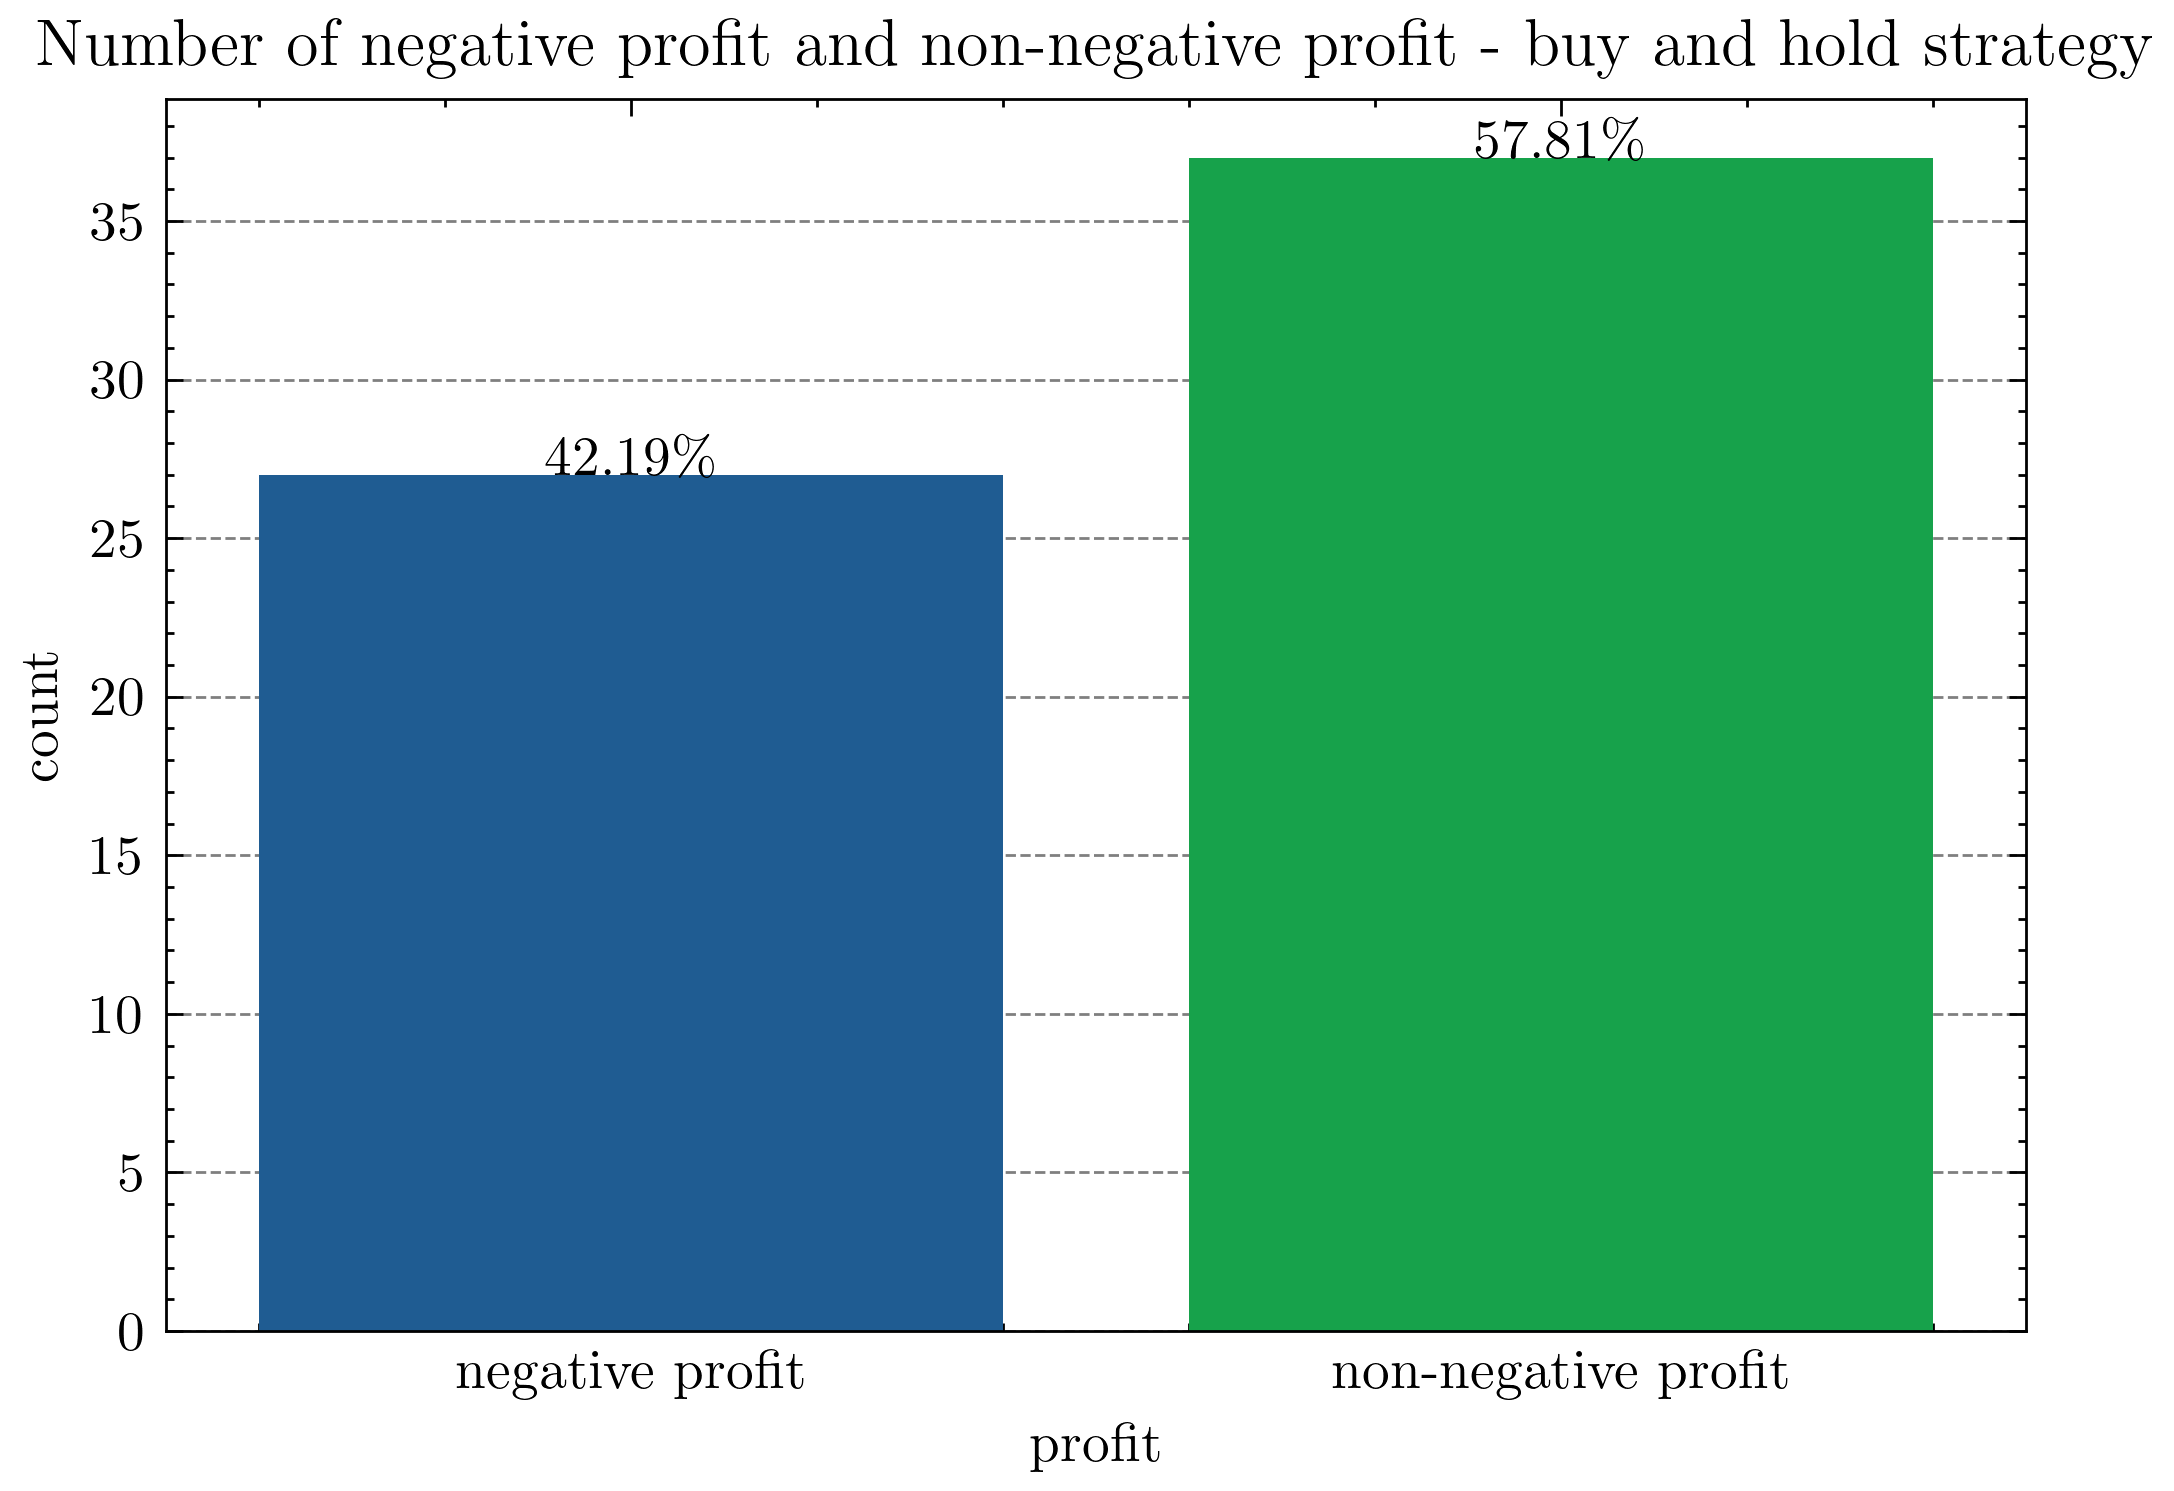

In [154]:
# using seaborn, create a pie chart of the number non-negative profit and negative profit

plt.figure(figsize=(6, 4), dpi=400)

sns.countplot(x=['negative profit' if i <
              0 else 'non-negative profit' for i in rewards])
plt.title('Number of negative profit and non-negative profit - buy and hold strategy')
plt.xlabel('profit')
plt.ylabel('count')

# annotate the percentage of negative profit and non-negative profit
total = len(rewards)
negative_profit = len([i for i in rewards if i < 0])
non_negative_profit = len([i for i in rewards if i >= 0])

plt.annotate('{:.2f}\%'.format(
    negative_profit/total*100), (0, negative_profit), ha='center')
plt.annotate('{:.2f}\%'.format(
    non_negative_profit/total*100), (1, non_negative_profit), ha='center')

plt.show()


In [163]:
env = Environment(train=False)
np.random.seed(42)
torch.random.manual_seed(42)
def run_eval(collection_num):
    observation, info = env.reset()

    actions = []
    rewards = []
    infos = []

    for t in tqdm(range(1000)):
        observation, reward, terminated, truncated, info = env.step(0)
        actions.append(0)
        rewards.append(reward)
        infos.append(info)
        if terminated:
            break

    infos_df = pd.DataFrame(infos)
    infos_df.head()

    # plot the prices and rewards in the same figure, using different y-axis
    fig, ax1 = plt.subplots(figsize=(6, 4))

    fig.set_dpi(400)

    color = 'tab:red'
    ax1.set_xlabel('time (days)')
    ax1.set_ylabel('price', color=color)
    ax1.plot([i['current_price_usd'] for i in infos], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    # we already handled the x-label with ax1
    ax2.set_ylabel('reward', color=color)
    ax2.plot(rewards, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # annotate the buy and sell points from the actions. 0 is buy, 1 is sell, 2 is hold. Annotate the signal with the price, use green point for buy and yellow point for sell
    for i in range(len(actions)):
        if actions[i] == 0:
            ax1.scatter(i, infos[i]['current_price_usd'], color='green')
            # annotate the price, 3 digits after decimal point
            # ax1.annotate('{:.0f}'.format(infos[i]['current_price_usd']), (i, infos[i]['current_price_usd']),
            #              textcoords="offset points",  # how to position the text
            #              xytext=(0, 10),  # distance from text to points (x,y)
            #              ha='center')
        elif actions[i] == 1:
            ax1.scatter(i, infos[i]['current_price_usd'], color='black')
            # ax1.annotate('{:.0f}'.format(infos[i]['current_price_usd']), (i, infos[i]['current_price_usd']),
            #              textcoords="offset points",  # how to position the text
            #              xytext=(0, 10),  # distance from text to points (x,y)
            #              ha='center')

    # legend for buy and sell points
    ax1.scatter([], [], color='green', label='buy')
    ax1.scatter([], [], color='black', label='sell')
    ax1.legend(loc='upper left')

    print(actions)

    plt.title(
        f'Buy and sell signals from RL agent on collection number {collection_num} - buy and hold strategy')

    plt.show()


  6%|▋         | 63/1000 [00:00<00:07, 131.89it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


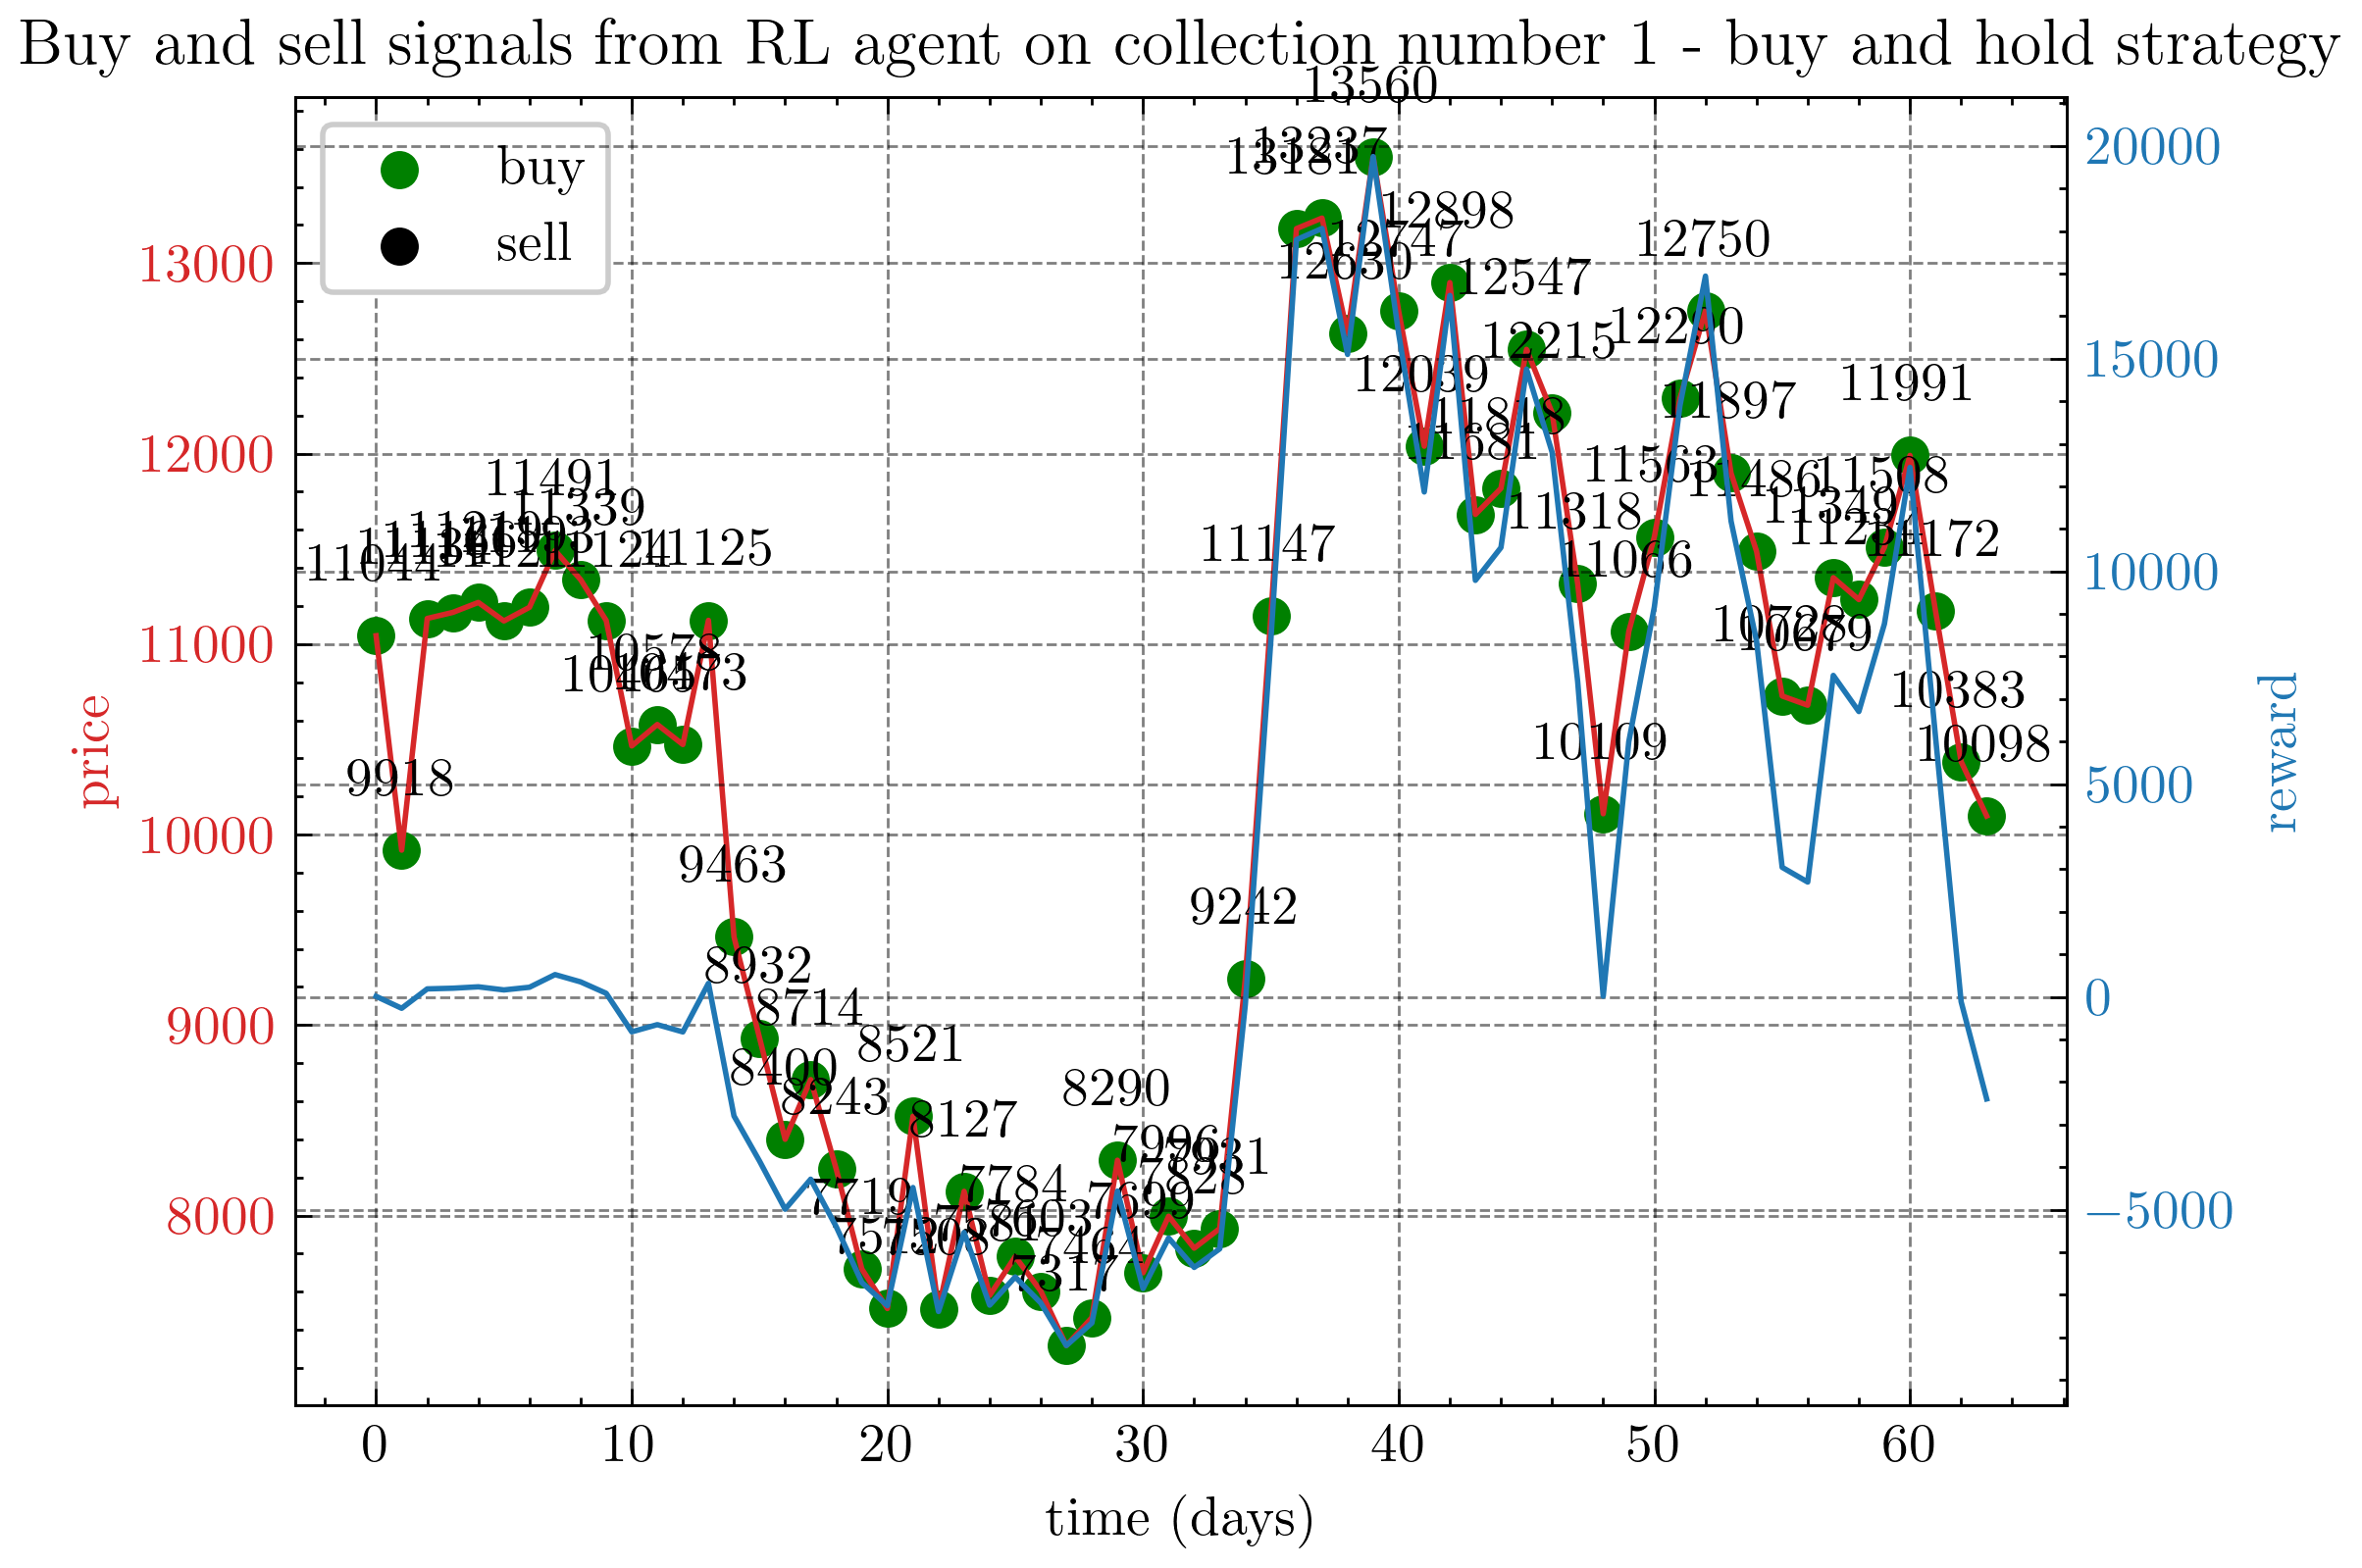

  6%|▋         | 63/1000 [00:01<00:19, 48.50it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


KeyboardInterrupt: 

In [164]:
for i in range(1, 5):
    run_eval(i)